# Introduction

This notebook is used to test ideas and see what does and does not work. This will then form the basis for the construction of the trading system. 

In [1]:
import pandas      as pd
import numpy       as np
from   frankie     import DayForecast, optimize, baseline, cross_val_tpr
from   datetime    import date, timedelta
from   scipy.stats import t
import yfinance    as yf
import matplotlib.pyplot as plt
import gc; gc.enable()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score
from sklearn.datasets import load_breast_cancer, load_iris, make_moons, make_circles, make_classification
from sklearn.linear_model import LogisticRegression
from category_encoders import WOEEncoder

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

from scipy.signal import savgol_filter, argrelmin, argrelmax

import math 
import random

import talib

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Determine split_date (180 days earlier than today)
today = date.today()
split_date = str(today - timedelta(30*6))
print("split_date=", split_date)

split_date= 2019-08-22


# Load Data

In [5]:
DATAPATH = '/Users/frkornet/Flatiron/Stock-Market-Final-Project/data/'
sdf = pd.read_csv(f'{DATAPATH}optimal_params.csv')

sdf = sdf.loc[sdf.up3_tpr > 0.0].reset_index()
if 'index' in sdf.columns:
    del sdf['index']
sdf.head(20)

NAME_OF_ISSUER      CUSIP    VALUE  SHRS_OR_PRN_AMT  \
0             ADURO BIOTECH INC  00739L101     2902          2738200   
1             BMC STK HLDGS INC  05591B109    34168          1305100   
2                CVR ENERGY INC  12662P108    92673          2104769   
3                     GRACO INC  384109104     8329           180900   
4            GULF RESOURCES INC  40251W309     1276          1830162   
5   HANCOCK WHITNEY CORPORATION  410120109     9687           252962   
6                      MBIA INC  55262C100     2108           228374   
7        PALO ALTO NETWORKS INC  697435105  1192028          5848150   
8                   SI BONE INC  825704109      723            40900   
9  SPECTRUM PHARMACEUTICALS INC  84763A108    22936          2765017   

   SOLE_VOTING_AUTH  NO_VOTING_AUTH TICKER up3_period              up3_lags  \
0           2590838          147362   ADRO        15y                   1,3   
1           1175955          129145   BMCH         3y                   1,3   
2           2104769               0    CVI         8y                   1,3   
3             72895          108005    GGG         5y                   1,3   
4           1828362            1800   GURE         5y                   1,3   
5            252962               0    HWC         5y                   1,3   
6            146742           81632    MBI         8y                   1,3   
7           5622490          225660   PANW         3y              1,3,5,10   
8             40900               0   SIBN        15y  1,3,5,10,20,30,45,60   
9           2747310           17707   SPPI         3y              1,3,5,10   

   up3_tpr  ...           up8_lags up8_tpr  up10_period up10_lags up10_tpr  \
0   0.9452  ...     1,3,5,10,20,30  0.9873           3y     1,3,5   0.9595   
1   0.9878  ...              1,3,5  1.0000           3y       1,3   1.0000   
2   0.8873  ...  1,3,5,10,20,30,45  1.0000           5y       1,3   0.9831   
3   0.9053  ...        1,3,5,10,20  1.0000          15y     1,3,5   0.9898   
4   0.7941  ...                1,3  0.9615          15y       1,3   1.0000   
5   0.8846  ...  1,3,5,10,20,30,45  0.9880           3y       1,3   1.0000   
6   0.8824  ...                1,3  1.0000           3y       1,3   0.9865   
7   0.9495  ...                1,3  0.9908           5y       1,3   1.0000   
8   0.8933  ...                1,3  0.9684          15y       1,3   0.9775   
9   0.9125  ...           1,3,5,10  1.0000          10y     1,3,5   0.9722   

   naive1_tpr naive3_tpr naive5_tpr  naive10_tpr  naive8_tpr  
0           0     0.4286     0.4091       0.4286      0.4740  
1           0     0.5519     0.5584       0.6104      0.6104  
2           0     0.4026     0.3831       0.3117      0.3636  
3           0     0.5519     0.6104       0.5649      0.5584  
4           0     0.3377     0.3182       0.2857      0.2792  
5           0     0.4870     0.4870       0.4545      0.4740  
6           0     0.4091     0.4286       0.3831      0.4026  
7           0     0.6234     0.6494       0.5974      0.6299  
8           0     0.4935     0.5260       0.5130      0.5519  
9           0     0.4675     0.4351       0.3831      0.3961  

[10 rows x 24 columns]

# Ticker_stats()

Helper function to retrieve stock data and then print some key statistics for the stock. If verbose is set to False, it will not print the statistics. The function is sued as a wrapper aroubd yfinance. In future period should be a parameter instead of a hard-coded value.

In [6]:
def ticker_stats(ticker, day, verbose):
    period = "10y" # "max"
    asset  = yf.Ticker(ticker)
    hist   = asset.history(period=period)
    col = f'perc_change{day}'
    hist[col] = 100*hist.Close.pct_change(day).shift(-day)
    
    idx = hist[col] <= 0
    neg_count = hist.loc[idx].count()[0]
    pos_count = hist.loc[~idx].count()[0]
    tot_count = len(hist)
    
    if verbose == True:
        print("TICKER:", ticker)
        print("="*(8+len(ticker)))
        print('')
        print('neg_count=', neg_count, f'neg_count %={neg_count}/{tot_count} = {neg_count/tot_count}')
        print('pos_count=', pos_count, f'pos_count %={pos_count}/{tot_count} = {pos_count/tot_count}')
        print('')
        print(hist[col].describe())
        print('')
        print(hist[col].tail(10))
        print('')
        hist[col].plot(figsize=(20,8))
        plt.title(ticker+f" ({day} day % change)")
        plt.show()
        print('')
    
    return hist

Loop through the tickers and print the ticker statistics.

TICKER: ADRO

neg_count= 669 neg_count %=669/1220 = 0.5483606557377049
pos_count= 551 pos_count %=551/1220 = 0.4516393442622951

count    1217.000000
mean       -0.259524
std         8.344113
min       -44.307692
25%        -4.748155
50%        -0.400962
75%         3.987539
max        65.925926
Name: perc_change3, dtype: float64

Date
2020-02-04    28.125000
2020-02-05     1.454545
2020-02-06    11.287129
2020-02-07     3.135889
2020-02-10    15.412186
2020-02-11    20.284698
2020-02-12    23.817568
2020-02-13          NaN
2020-02-14          NaN
2020-02-18          NaN
Name: perc_change3, dtype: float64



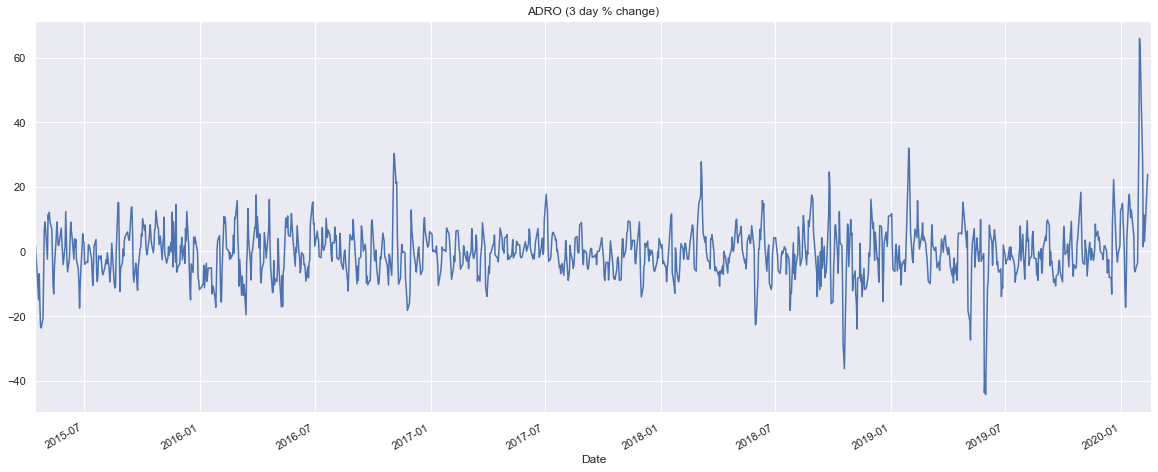


TICKER: BMCH

neg_count= 797 neg_count %=797/1642 = 0.4853836784409257
pos_count= 845 pos_count %=845/1642 = 0.5146163215590743

count    1639.000000
mean        0.206330
std         3.686502
min       -15.024938
25%        -1.851060
50%         0.183936
75%         2.235918
max        22.681029
Name: perc_change3, dtype: float64

Date
2020-02-04    2.646048
2020-02-05   -2.607856
2020-02-06    0.619498
2020-02-07    2.644794
2020-02-10    2.842975
2020-02-11   -0.518471
2020-02-12    0.000000
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



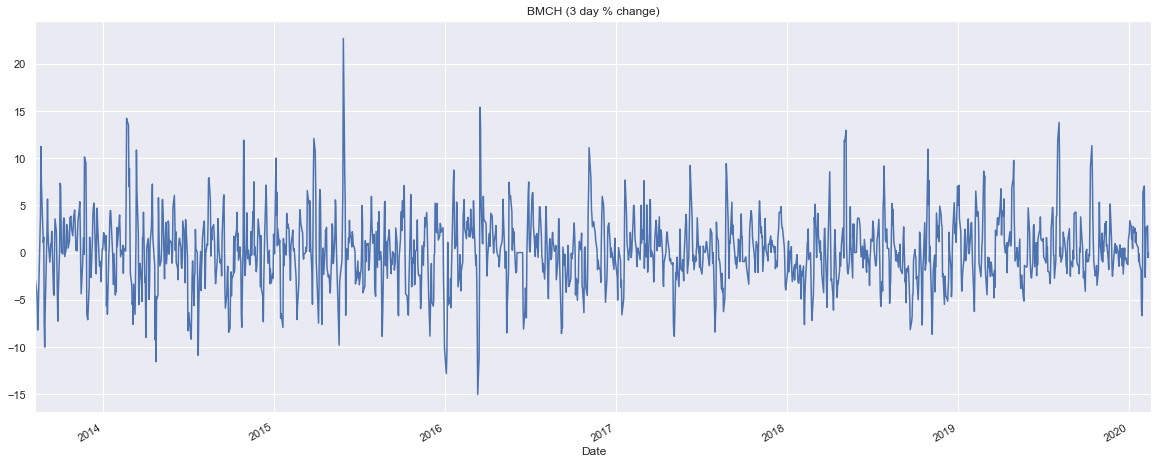


TICKER: CVI

neg_count= 1185 neg_count %=1185/2516 = 0.4709856915739269
pos_count= 1331 pos_count %=1331/2516 = 0.5290143084260731

count    2513.000000
mean        0.370736
std         4.710302
min       -21.504339
25%        -2.336786
50%         0.317316
75%         3.069839
max        37.171286
Name: perc_change3, dtype: float64

Date
2020-02-04    0.682898
2020-02-05    0.490620
2020-02-06    4.221165
2020-02-07    2.152757
2020-02-10   -1.924182
2020-02-11   -3.508272
2020-02-12   -4.070439
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



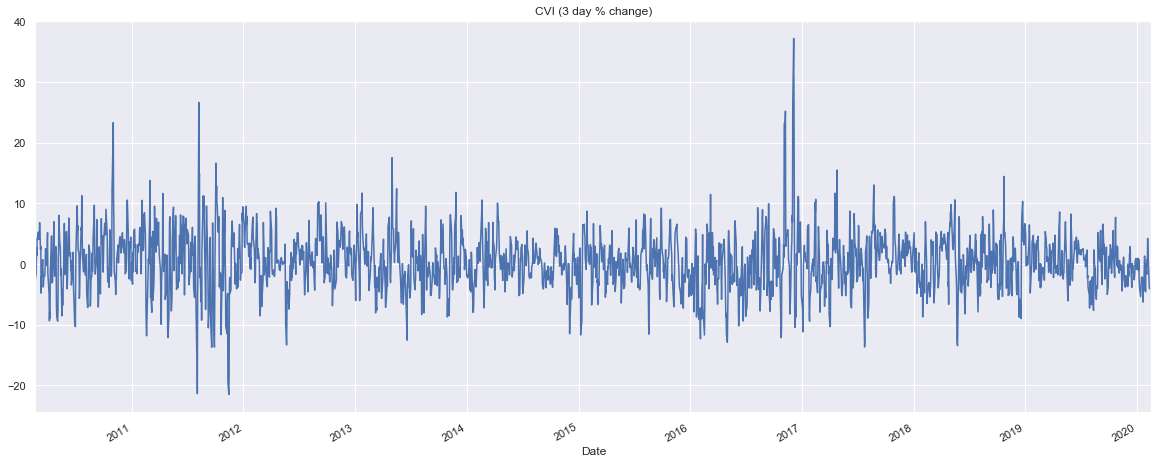


TICKER: GGG

neg_count= 1077 neg_count %=1077/2516 = 0.428060413354531
pos_count= 1439 pos_count %=1439/2516 = 0.571939586645469

count    2513.000000
mean        0.314184
std         2.777834
min       -15.928270
25%        -1.151728
50%         0.404040
75%         1.785714
max        12.260967
Name: perc_change3, dtype: float64

Date
2020-02-04   -0.940666
2020-02-05   -0.252071
2020-02-06    1.536515
2020-02-07    2.775749
2020-02-10    1.714801
2020-02-11   -0.249243
2020-02-12    0.177683
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



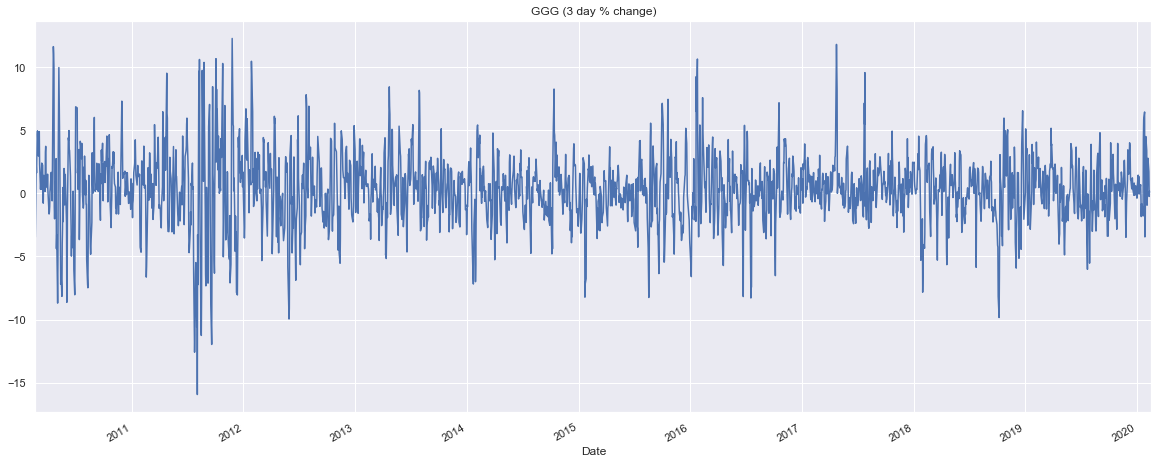


TICKER: GURE

neg_count= 1459 neg_count %=1459/2516 = 0.5798887122416534
pos_count= 1057 pos_count %=1057/2516 = 0.4201112877583466

count    2513.000000
mean       -0.049937
std         7.263939
min       -37.333333
25%        -3.703704
50%        -0.602410
75%         2.857143
max        66.101695
Name: perc_change3, dtype: float64

Date
2020-02-04    -6.971154
2020-02-05     6.281407
2020-02-06    10.962567
2020-02-07     5.167959
2020-02-10    -1.654846
2020-02-11     0.481928
2020-02-12    -0.982801
2020-02-13          NaN
2020-02-14          NaN
2020-02-18          NaN
Name: perc_change3, dtype: float64



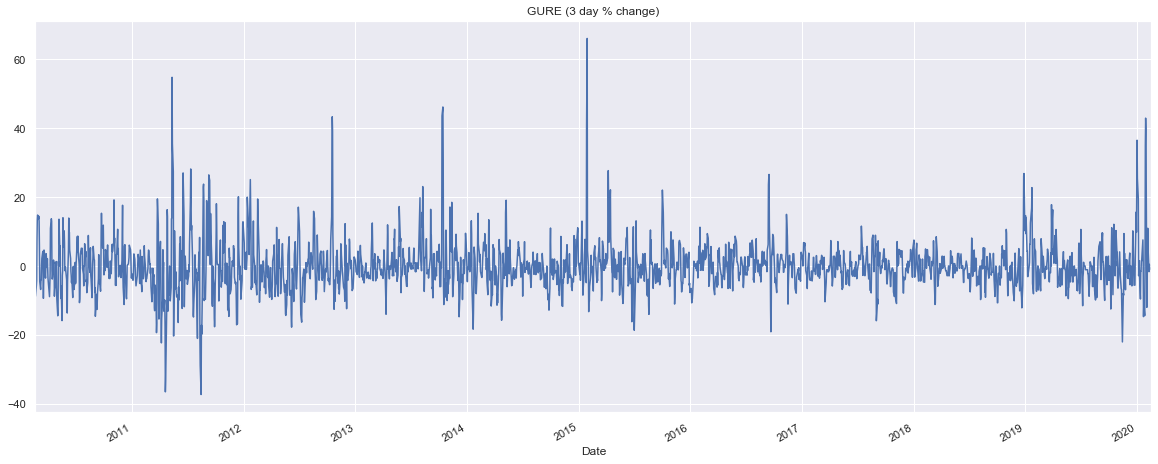


TICKER: HWC

neg_count= 1245 neg_count %=1245/2516 = 0.49483306836248014
pos_count= 1271 pos_count %=1271/2516 = 0.5051669316375199

count    2513.000000
mean        0.080535
std         3.076510
min       -15.586481
25%        -1.579192
50%         0.045496
75%         1.824353
max        12.291307
Name: perc_change3, dtype: float64

Date
2020-02-04    0.571003
2020-02-05   -2.343561
2020-02-06   -1.169876
2020-02-07    0.715873
2020-02-10    1.311232
2020-02-11   -0.271270
2020-02-12   -2.818627
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



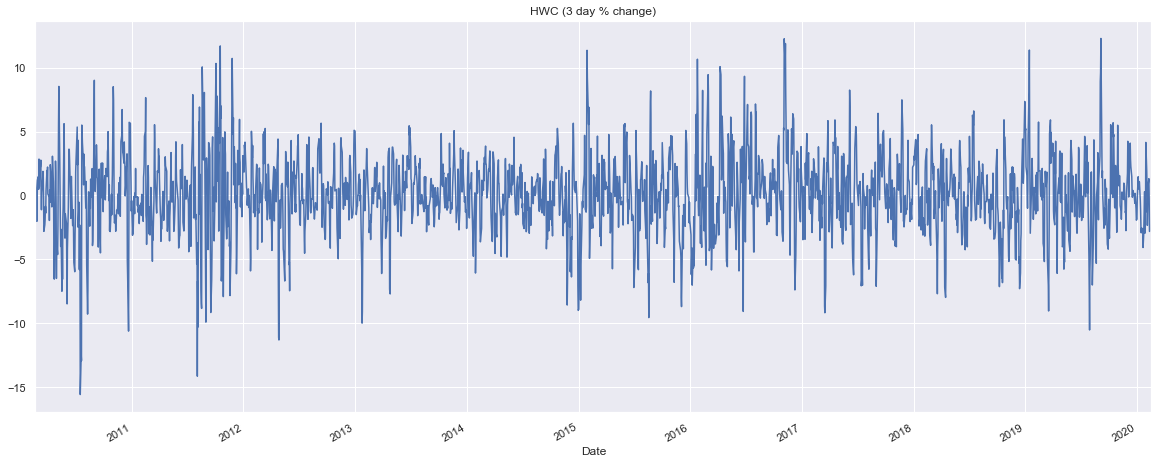


TICKER: MBI

neg_count= 1319 neg_count %=1319/2516 = 0.5242448330683624
pos_count= 1197 pos_count %=1197/2516 = 0.4757551669316375

count    2513.000000
mean        0.236525
std         5.781760
min       -30.278422
25%        -2.908068
50%        -0.108108
75%         2.623907
max        58.480176
Name: perc_change3, dtype: float64

Date
2020-02-04    0.758397
2020-02-05    0.107066
2020-02-06    1.391863
2020-02-07    1.505376
2020-02-10    0.427807
2020-02-11   -1.055966
2020-02-12   -1.059322
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



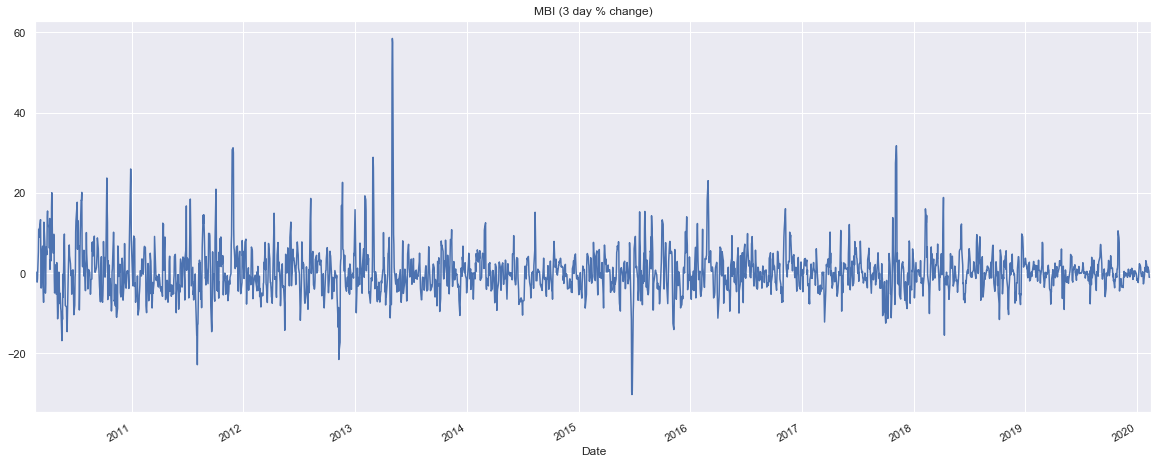


TICKER: PANW

neg_count= 863 neg_count %=863/1906 = 0.4527806925498426
pos_count= 1043 pos_count %=1043/1906 = 0.5472193074501573

count    1903.000000
mean        0.323870
std         4.019269
min       -24.704268
25%        -1.775665
50%         0.337158
75%         2.492485
max        18.492284
Name: perc_change3, dtype: float64

Date
2020-02-04    2.343978
2020-02-05    2.424894
2020-02-06    0.308855
2020-02-07   -0.447482
2020-02-10   -0.771655
2020-02-11    0.170158
2020-02-12    1.838836
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



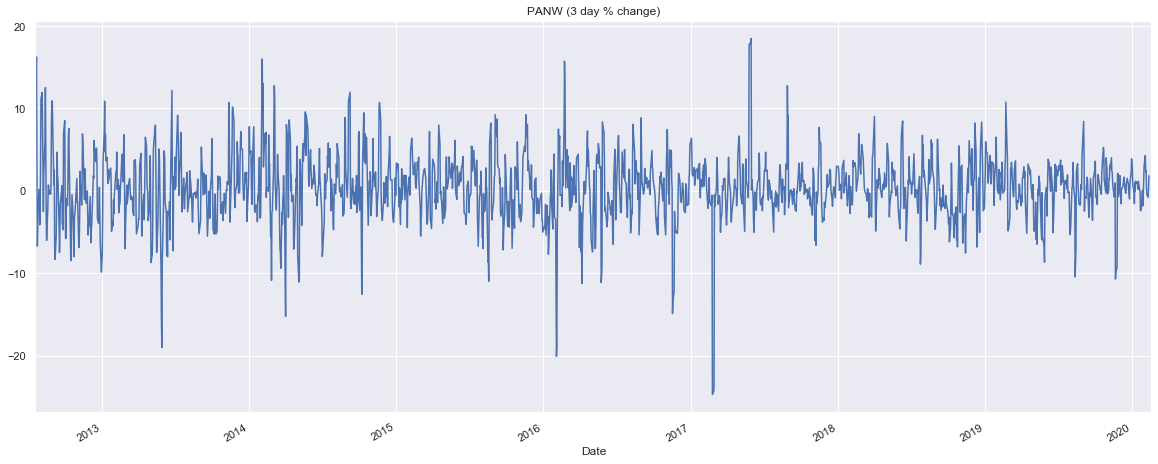


TICKER: SIBN

neg_count= 167 neg_count %=167/335 = 0.49850746268656715
pos_count= 168 pos_count %=168/335 = 0.5014925373134328

count    332.000000
mean       0.112039
std        4.635696
min      -11.677852
25%       -2.871275
50%        0.000000
75%        2.734664
max       16.816817
Name: perc_change3, dtype: float64

Date
2020-02-04   -2.536900
2020-02-05   -2.980284
2020-02-06    0.380952
2020-02-07   -0.615239
2020-02-10   -2.693762
2020-02-11   -2.229602
2020-02-12   -1.952381
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



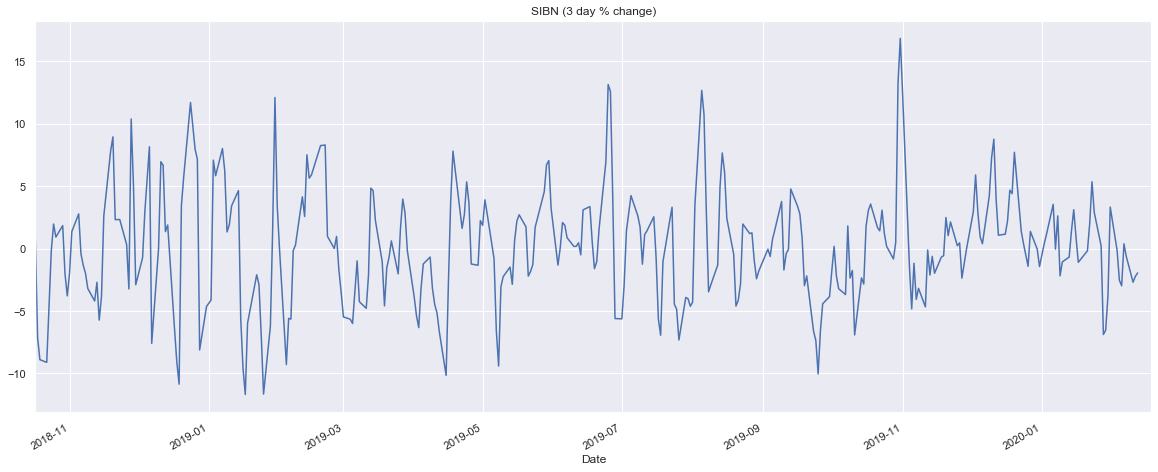


TICKER: SPPI

neg_count= 1254 neg_count %=1254/2516 = 0.4984101748807631
pos_count= 1262 pos_count %=1262/2516 = 0.5015898251192369

count    2513.000000
mean        0.162840
std         6.498354
min       -59.584296
25%        -2.926864
50%         0.084818
75%         3.096774
max        48.513302
Name: perc_change3, dtype: float64

Date
2020-02-04    5.363985
2020-02-05    1.454545
2020-02-06   -2.456140
2020-02-07    7.636364
2020-02-10    1.792115
2020-02-11    1.798561
2020-02-12   -6.081081
2020-02-13         NaN
2020-02-14         NaN
2020-02-18         NaN
Name: perc_change3, dtype: float64



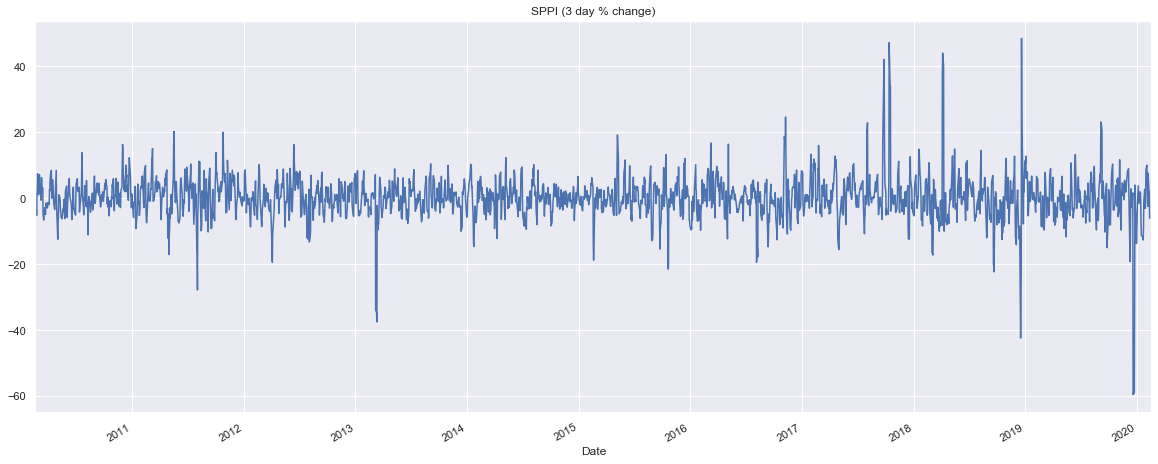

In [7]:
tickers = sdf.TICKER.to_list()
day=3

for ticker in tickers:
    ticker_stats(ticker, day, True)

# Probabilities for UP and Down streaks

The following cells calculate the probability of a two day up/down streak given that the first day was up/down. This is repeated for three days as well. It was used to test whether the probabilities change. They do not and this makes sense. There is no reason why this shoukd be different.

In [8]:
print('2 day up streak probability:')
print('============================')
print('')

sdf['up2_streak_prob'] = 0

for ticker in tickers:
    hist = ticker_stats(ticker, 3, False)
    
    hist['pct_change3'] = hist.Close.pct_change(3).shift(-3)
    hist['diff_1'] = hist.Close.diff()
    idx=(hist.diff_1 > 0)
    
    hist = hist.loc[idx]
    
    up_2_days_in_a_row        = hist.loc[hist.pct_change3 > 0].count()[0]
    down_today_after_1_day_up = hist.loc[hist.pct_change3 <= 0].count()[0]
    
    prob = round(up_2_days_in_a_row/(down_today_after_1_day_up + up_2_days_in_a_row),2)
    print(ticker, ":", 
          f'{up_2_days_in_a_row}/({down_today_after_1_day_up}+{up_2_days_in_a_row})=',
          prob)
    
    sdf['up2_streak_prob'].loc[sdf.TICKER == ticker] = prob

2 day up streak probability:

ADRO : 267/(303+267)= 0.47
BMCH : 428/(376+428)= 0.53
CVI : 702/(594+702)= 0.54
GGG : 779/(567+779)= 0.58
GURE : 414/(615+414)= 0.4
HWC : 629/(636+629)= 0.5
MBI : 576/(612+576)= 0.48
PANW : 553/(455+553)= 0.55
SIBN : 79/(87+79)= 0.48
SPPI : 591/(623+591)= 0.49


In [9]:
print('3 day up streak probability:')
print('============================')
print('')

sdf['up3_streak_prob'] = 0

for ticker in tickers:
    hist = ticker_stats(ticker, 3, False)
    
    hist['pct_change3'] = hist.Close.pct_change(3).shift(-3)
    hist['diff_1'] = hist.Close.diff(1)
    hist['diff_2'] = hist['diff_1'].shift(1)
    idx=(hist.diff_1 > 0) & (hist.diff_2 > 0)
    
    hist = hist.loc[idx]
    
    up_3_days_in_a_row        = hist.loc[hist.pct_change3 > 0].count()[0]
    down_today_after_2_days_up = hist.loc[hist.pct_change3 <= 0].count()[0]
    
    prob = round(up_3_days_in_a_row/(down_today_after_2_days_up + up_3_days_in_a_row),2)
    print(ticker, ":", 
          f'{up_3_days_in_a_row}/({down_today_after_2_days_up}+{up_3_days_in_a_row})=',
          prob)
    
    sdf['up3_streak_prob'].loc[sdf.TICKER == ticker] = prob

3 day up streak probability:

ADRO : 135/(134+135)= 0.5
BMCH : 200/(193+200)= 0.51
CVI : 391/(300+391)= 0.57
GGG : 407/(311+407)= 0.57
GURE : 163/(266+163)= 0.38
HWC : 314/(300+314)= 0.51
MBI : 270/(299+270)= 0.47
PANW : 284/(239+284)= 0.54
SIBN : 39/(50+39)= 0.44
SPPI : 283/(304+283)= 0.48


In [10]:
print('2 day down streak probability:')
print('============================')
print('')

sdf['down2_streak_prob'] = 0

for ticker in tickers:
    hist = ticker_stats(ticker, 3, False)
    
    hist['pct_change3'] = hist.Close.pct_change(3).shift(-3)
    hist['diff_1'] = hist.Close.diff()
    idx=(hist.diff_1 <= 0)
    
    hist = hist.loc[idx]
    
    down_2_days_in_a_row      = hist.loc[hist.pct_change3 <= 0].count()[0]
    up_today_after_1_day_down = hist.loc[hist.pct_change3 > 0].count()[0]
    
    prob = round(down_2_days_in_a_row/(up_today_after_1_day_down + down_2_days_in_a_row), 2)
    print(ticker, ":", 
          f'{down_2_days_in_a_row}/({up_today_after_1_day_down}+{down_2_days_in_a_row})=',
          prob)
    
    sdf['down2_streak_prob'].loc[sdf.TICKER == ticker] = prob

2 day down streak probability:

ADRO : 366/(280+366)= 0.57
BMCH : 420/(414+420)= 0.5
CVI : 590/(626+590)= 0.49
GGG : 509/(657+509)= 0.44
GURE : 843/(640+843)= 0.57
HWC : 609/(638+609)= 0.49
MBI : 706/(618+706)= 0.53
PANW : 408/(486+408)= 0.46
SIBN : 80/(85+80)= 0.48
SPPI : 630/(668+630)= 0.49


In [11]:
print('3 day down streak probability:')
print('==============================')
print('')

sdf['down3_streak_prob'] = 0

for ticker in tickers:
    hist = ticker_stats(ticker, 3, False)
    
    hist['pct_change3'] = hist.Close.pct_change(3).shift(-3)
    hist['diff_1'] = hist.Close.diff()
    hist['diff_2'] = hist['diff_1'].shift(1)
    idx=(hist.diff_1 <= 0) & (hist.diff_2 <= 0)
    
    hist = hist.loc[idx]
    
    down_3_days_in_a_row       = hist.loc[hist.pct_change3 <= 0].count()[0]
    up_today_after_2_days_down = hist.loc[hist.pct_change3 > 0].count()[0]
    
    prob = round(down_3_days_in_a_row/(up_today_after_2_days_down + down_3_days_in_a_row), 2)
    print(ticker, ":", 
          f'{down_3_days_in_a_row}/({up_today_after_2_days_down}+{down_3_days_in_a_row})=',
          prob)
    
    sdf['down3_streak_prob'].loc[sdf.TICKER == ticker] = prob

3 day down streak probability:

ADRO : 195/(150+195)= 0.57
BMCH : 220/(203+220)= 0.52
CVI : 301/(309+301)= 0.49
GGG : 234/(304+234)= 0.43
GURE : 487/(395+487)= 0.55
HWC : 287/(310+287)= 0.48
MBI : 377/(327+377)= 0.54
PANW : 189/(219+189)= 0.46
SIBN : 46/(42+46)= 0.52
SPPI : 321/(350+321)= 0.48


The up/.down streak cells above store the result in sdf data frame. The cell below summarizes the results in a simple table.

In [12]:
cols = [col for col in sdf.columns.to_list() if 'streak' in col or 'TICKER' in col]
cols=sorted(cols)
sdf[cols]

TICKER  down2_streak_prob  down3_streak_prob  up2_streak_prob  \
0   ADRO               0.57               0.57             0.47   
1   BMCH               0.50               0.52             0.53   
2    CVI               0.49               0.49             0.54   
3    GGG               0.44               0.43             0.58   
4   GURE               0.57               0.55             0.40   
5    HWC               0.49               0.48             0.50   
6    MBI               0.53               0.54             0.48   
7   PANW               0.46               0.46             0.55   
8   SIBN               0.48               0.52             0.48   
9   SPPI               0.49               0.48             0.49   

   up3_streak_prob  
0             0.50  
1             0.51  
2             0.57  
3             0.57  
4             0.38  
5             0.51  
6             0.47  
7             0.54  
8             0.44  
9             0.48

# Up Models Balanced Scorecard

There is little benefit knowing whether a stock went down or compared the day before when prediciting whether a stock will be up in three days. It remains roughly a 50/50 deal.

Now the question is, can I do better than the naive approach of checking whether stock went up today to predict whether or not it goes up three days from now? Check that by testing this on a weighted evidence scorecard.

This is done by calculating a balanced scorecard. The following are helper functions:L `create_target()`, `preprocess()` (calculate days up, days down, and turns), `create_features()`, `split_data()`, `print_stats()`, `stringify()`, `print_stats_with_streshold()`, and `balanced_scorecard()`.

In [13]:
def create_target(stock_df, day):
    col='target_'+ str(day)
    stock_df[col] = stock_df['Close'].pct_change(day).apply(lambda x: 1 if x > 0 else 0).shift(-day)
    
    return stock_df

In [14]:
def preprocess(stock_df, day):
    stock_df['days_up']   = 0
    stock_df['days_down'] = 0
    stock_df['turn'] = 0
    stock_df['diff'] = stock_df['Close'].diff()

    days_up = 0
    days_down = 0
    turns = 0

    diff_col = "diff"
    
    for i in range(1, len(stock_df)):

        if days_down == 0 and days_up == 0:
           if stock_df[diff_col].iloc[i] < 0:
              days_down = 1
              stock_df['days_down'].iloc[i] = days_down
           else:
              days_up = 1
              stock_df['days_up'].iloc[i] = days_up
           continue

        # stock up and in up trend
        if stock_df[diff_col].iloc[i] > 0 and days_up > 0:
           turns = 0
           days_up += 1
           stock_df['days_up'].iloc[i] = days_up
           continue

        # stock up and in down trend
        if stock_df[diff_col].iloc[i] > 0 and days_down > 0:
           turns += 1
           days_up += 1
           days_down = 0
           stock_df['days_up'].iloc[i] = days_up
           stock_df['turn'].iloc[i] = turns
           continue

        # stock down and in down trend
        if stock_df[diff_col].iloc[i] < 0 and days_down > 0:
           turns = 0
           days_down += 1
           stock_df['days_down'].iloc[i] = days_down
           continue

        # stock down and in up trend
        if stock_df[diff_col].iloc[i] < 0 and days_up > 0:
           days_up = 0
           days_down += 1
           turns += 1
           stock_df['days_down'].iloc[i] = days_down
           stock_df['turn'].iloc[i] = turns
           continue
    
    return stock_df

In [15]:
def create_features(stock_df):

    stock_df['slope'] = stock_df.Close.diff(1)
    stock_df['slope_minus_1'] = stock_df.slope.shift(1)
    stock_df['slope_minus_2'] = stock_df.slope_minus_1.shift(1)
    
    for days in [10, 15]:
        stock_df['tema_'+str(days)] = round(talib.TEMA(stock_df.Close, days), 2)
  
        col='RSI_'+str(days)
        stock_df[col] = round(talib.RSI(stock_df['Close'], days), 2)
        
    stock_df['sma50'] = round(stock_df.Close.rolling(50).mean(), 2)

    stock_df['sma50_below'] = stock_df.Close - stock_df.sma50
    stock_df.sma50_below = stock_df.sma50_below.apply(lambda x: 1 if x < 0 else 0)
    
    stock_df['day_minus_1_3d'] = stock_df.Close.pct_change(3).shift(-2)

    return stock_df

In [16]:
def split_data(stock_df, used_cols, target):
    # set how many rows to discard (from start) and where test starts
    sacrifice = 0 # 50
    test_starts_at = int(len(stock_df)*0.6)
    
    X = stock_df[used_cols].iloc[sacrifice:]
    y = stock_df[target].iloc[sacrifice:]

    X_train = stock_df[used_cols].iloc[sacrifice:test_starts_at]
    X_test  = stock_df[used_cols].iloc[test_starts_at:]
    y_train = stock_df[target].iloc[sacrifice:test_starts_at]
    y_test  = stock_df[target].iloc[test_starts_at:]
    
    return X, y, X_train, X_test, y_train, y_test

In [17]:
def print_stats(pipe, stock_df, target, train_preds, test_preds):
    print("TRAIN CONFUSION MATRIX:")
    print(confusion_matrix(y_train, train_preds))
    print('')
    print("TEST CONFUSION MATRIX:")
    print(confusion_matrix(y_test, test_preds), "\n")
    
    up_count = sum(stock_df[target][stock_df[target] != 0])
    print(f"Up percentage for {target} in data =", up_count / len(stock_df), "\n")
    
    print("Accuracy:"); print("="*len("Accuracy:"))
    print("TRAIN:", accuracy_score(y_train, train_preds))
    print("TEST:", accuracy_score(y_test, test_preds), "\n")
    
    train_preds = pipe.predict_proba(X_train)[:,1]
    test_preds = pipe.predict_proba(X_test)[:,1]
    
    scores = cross_val_score(pipe, X, y.values, cv=5, scoring='accuracy')
    print("Cross validation:", scores.mean(), "+/-", scores.std(), "\n")
    
    coeffs = pipe['logisticregression'].coef_
    print("coef_=", coeffs, "\n")
    
    key = [np.abs(coeffs) > 0]
    display(pd.DataFrame(X.columns).iloc[key[0][0]])

In [18]:
def stringify(data):
    df = pd.DataFrame(data)
    for c in df.columns.tolist():
        df[c] = df[c].astype(str)
    return df

In [19]:
def print_stats_with_threshold(stock_df, ticker, pipe,threshold):

    train_preds_probs = (pipe.predict_proba(X_train) > threshold).astype(int)[:,1]
    test_preds_probs = (pipe.predict_proba(X_test)  > threshold).astype(int)[:,1]

    print("len(X_train)=", len(X_train))
    print("len(X_test)=", len(X_test))
    print("len(train_preds_probs)=", len(train_preds_probs), "sum=", sum(train_preds_probs))
    print("len(y_train)=", len(y_train), "sum=", sum(y_train), "\n")
    print("len(test_preds_probs)=", len(test_preds_probs),  "sum=", sum(test_preds_probs))
    print("len(y_test)=", len(y_test), "sum=", sum(y_test), "\n")

    print("TRAIN CONFUSION MATRIX:")
    train_conf_m = confusion_matrix(y_train, train_preds_probs)
    tn, fn, fp, tp = train_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(train_conf_m)
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )

    print('')

    print("TEST CONFUSION MATRIX:")
    test_conf_m = confusion_matrix(y_test, test_preds_probs)
    tn, fn, fp, tp = test_conf_m.ravel()
    print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
    print(test_conf_m, "\n")
    print("TP/(FN+TP)=", tp/(fn + tp), "FN+TP=", fn+tp)
    print("share of data=", (tp + fn)/(tp+fp+tn+fn) )
    
    tpr = round(tp/(fn + tp), 2)
    sdf['up2_scorecard_tpr'].loc[sdf.TICKER == ticker] = tpr

A cell to print scatter plots. It is commented out for now as it is not that useful. The code is left in so I can re-use it later if needed without having to rerwrite the code.

In [20]:
# for ticker in tickers:
#     gc.collect()

#     print("*******************")
#     print("***", ticker, " "*5, "***" )
#     print("*******************")
#     print('')

#     hist = ticker_stats(ticker, 3, False)
#     hist = create_target(hist, 3)
#     hist = create_features(hist)
#     hist = preprocess(hist, 3)
#     hist = hist.dropna()

#     hist['slopes'] = hist.slope * hist.slope_minus_1 * hist.slope_minus_2

#     # Note 'day_minus_1_3d' contains information from the 'future'
#     # it cannot be used. It is included to show what it does
#     used_cols = ['Close', 'RSI_15', 
#                  'slope', 'slope_minus_1', 'slope_minus_2', 
#                  'sma50', 'tema_15',
#                  'days_down', 'days_up', 'turn', 'slopes', 'day_minus_1_3d']

#     target = 'target_3'
#     for col in used_cols:
#         hist.plot.scatter(x=col, y='target_3', c='Blue')
#         plt.title(col+" vs target_3")
#         plt.show()

In [21]:
def balanced_scorecard(stock_df, ticker, used_cols, target):

    binner = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
    objectify = FunctionTransformer(func=stringify, validate=False)
    encoder = WOEEncoder()
    scaler = MinMaxScaler()

    lr = LogisticRegression(class_weight='balanced', penalty='l2')

    # pipe = make_pipeline(binner, objectify, encoder, lr)
    pipe = make_pipeline(scaler, lr)

    pipe.fit(X_train, y_train.values)

    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)

    print_stats(pipe, stock_df, 'target_3', train_preds, test_preds)
    print('')
    print_stats_with_threshold(stock_df, ticker, pipe, 0.6)

In [22]:
#     used_cols = ['Close', 'RSI_10', 'RSI_15', 
#                  'slope', 'slope_minus_1', 'slope_minus_2', 
#                  'sma50', 'sma50_below', 'tema_10', 'tema_15',
#                  'days_down', 'days_up', 'turn']
#
# columns currently leaking data: 'perc_change3', 'target_3', 'day_minus_1_3d'

The main loop that calls the above helper functions for each of the stock tickers. As can be seen in the output, the balanced scofrecard is not able to pick up a signal for the market going up in 3 days. The probability is basically the same as for the naive baseline (choose market going up as you will then be 50% wrong).

An outstanding todo item is to incorporate the features used in the local minima/maxima models below to see if they can help in amplifying the signal.

In [23]:
sdf['up2_scorecard_tpr'] = 0

for ticker in tickers:
    gc.collect()
    
    print("*******************")
    print("***", ticker, " "*5, "***" )
    print("*******************")
    print('')
    
    hist = ticker_stats(ticker, 3, False)
    hist = create_target(hist, 3)
    hist = create_features(hist)
    hist = preprocess(hist, 3)
    hist = hist.dropna()
    
    hist['slopes'] = hist.slope * hist.slope_minus_1 * hist.slope_minus_2
    
    # Try without 'day_minus_1_3d' as this is leaking info on 'target_3'
    used_cols = ['Close', 'RSI_15', 'slopes', 'sma50', 'tema_15',
                 'days_down', 'days_up', 'turn']
    
    target = 'target_3'
    X, y, X_train, X_test, y_train, y_test = split_data(hist, used_cols, target)
    
    print("*** Training data starts at :", min(X_train.index))
    print("*** Test data starts at     :", min(X_test.index))
    print('')
    
    balanced_scorecard(hist, ticker, used_cols, target)
    print('')

*******************
*** ADRO       ***
*******************

*** Training data starts at : 2015-06-24 00:00:00
*** Test data starts at     : 2018-04-05 00:00:00

TRAIN CONFUSION MATRIX:
[[197 198]
 [129 176]]

TEST CONFUSION MATRIX:
[[  2 249]
 [  1 216]] 

Up percentage for target_3 in data = 0.4469178082191781 

Accuracy:
TRAIN: 0.5328571428571428
TEST: 0.4658119658119658 

Cross validation: 0.5127398114522579 +/- 0.04980732695558603 

coef_= [[-0.20321201 -0.10662044  0.13676778 -0.54192438  0.18703055  0.08422658
   0.75821475  0.56139147]] 



0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 700
len(X_test)= 468
len(train_preds_probs)= 700 sum= 13
len(y_train)= 700 sum= 305.0 

len(test_preds_probs)= 468 sum= 49
len(y_test)= 468 sum= 217.0 

TRAIN CONFUSION MATRIX:
tn= 390 fn= 5 tp= 8 fp= 297
[[390   5]
 [297   8]]
TP/(FN+TP)= 0.6153846153846154 FN+TP= 13
share of data= 0.018571428571428572

TEST CONFUSION MATRIX:
tn= 218 fn= 33 tp= 16 fp= 201
[[218  33]
 [201  16]] 

TP/(FN+TP)= 0.32653061224489793 FN+TP= 49
share of data= 0.1047008547008547

*******************
*** BMCH       ***
*******************

*** Training data starts at : 2013-10-18 00:00:00
*** Test data starts at     : 2017-08-03 00:00:00

TRAIN CONFUSION MATRIX:
[[273 180]
 [227 274]]

TEST CONFUSION MATRIX:
[[276  47]
 [253  60]] 

Up percentage for target_3 in data = 0.5119496855345912 

Accuracy:
TRAIN: 0.5733752620545073
TEST: 0.5283018867924528 

Cross validation: 0.5169811320754717 +/- 0.026875296376379233 

coef_= [[-0.95851452  0.3984295  -0.09264501 -0.13103106 -0.64981299  0.11644403
 

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 954
len(X_test)= 636
len(train_preds_probs)= 954 sum= 118
len(y_train)= 954 sum= 501.0 

len(test_preds_probs)= 636 sum= 6
len(y_test)= 636 sum= 313.0 

TRAIN CONFUSION MATRIX:
tn= 416 fn= 37 tp= 81 fp= 420
[[416  37]
 [420  81]]
TP/(FN+TP)= 0.6864406779661016 FN+TP= 118
share of data= 0.12368972746331237

TEST CONFUSION MATRIX:
tn= 322 fn= 1 tp= 5 fp= 308
[[322   1]
 [308   5]] 

TP/(FN+TP)= 0.8333333333333334 FN+TP= 6
share of data= 0.009433962264150943

*******************
*** CVI       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[404 275]
 [401 398]]

TEST CONFUSION MATRIX:
[[342 140]
 [346 158]] 

Up percentage for target_3 in data = 0.528814935064935 

Accuracy:
TRAIN: 0.5426251691474966
TEST: 0.5070993914807302 

Cross validation: 0.5291998548788733 +/- 0.037559177479936555 

coef_= [[-0.26282089  0.49031379  0.34558785  0.28574407 -0.758354    0.01324808
   

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 39
len(y_train)= 1478 sum= 799.0 

len(test_preds_probs)= 986 sum= 0
len(y_test)= 986 sum= 504.0 

TRAIN CONFUSION MATRIX:
tn= 663 fn= 16 tp= 23 fp= 776
[[663  16]
 [776  23]]
TP/(FN+TP)= 0.5897435897435898 FN+TP= 39
share of data= 0.02638700947225981

TEST CONFUSION MATRIX:
tn= 482 fn= 0 tp= 0 fp= 504
[[482   0]
 [504   0]] 

TP/(FN+TP)= nan FN+TP= 0
share of data= 0.0

*******************
*** GGG       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[347 303]
 [369 459]]

TEST CONFUSION MATRIX:
[[397  18]
 [550  21]] 

Up percentage for target_3 in data = 0.567775974025974 

Accuracy:
TRAIN: 0.5453315290933695
TEST: 0.4239350912778905 

Cross validation: 0.5137889806889955 +/- 0.04413375397865899 

coef_= [[-0.33092131 -0.55278548  0.29526732  0.24206303 -0.44576071 -1.24418275
  -0.19953408  0.19535512]] 



0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 49
len(y_train)= 1478 sum= 828.0 

len(test_preds_probs)= 986 sum= 2
len(y_test)= 986 sum= 571.0 

TRAIN CONFUSION MATRIX:
tn= 636 fn= 14 tp= 35 fp= 793
[[636  14]
 [793  35]]
TP/(FN+TP)= 0.7142857142857143 FN+TP= 49
share of data= 0.033152909336941816

TEST CONFUSION MATRIX:
tn= 415 fn= 0 tp= 2 fp= 569
[[415   0]
 [569   2]] 

TP/(FN+TP)= 1.0 FN+TP= 2
share of data= 0.002028397565922921

*******************
*** GURE       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[522 325]
 [347 284]]

TEST CONFUSION MATRIX:
[[352 232]
 [228 174]] 

Up percentage for target_3 in data = 0.419237012987013 

Accuracy:
TRAIN: 0.5453315290933695
TEST: 0.5334685598377282 

Cross validation: 0.5272003166279127 +/- 0.019961659244507518 

coef_= [[-0.19333156 -0.13631269 -0.05320068 -0.24773053  0.32522118  1.03144422
  -0.28533317 -

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 84
len(y_train)= 1478 sum= 631.0 

len(test_preds_probs)= 986 sum= 52
len(y_test)= 986 sum= 402.0 

TRAIN CONFUSION MATRIX:
tn= 817 fn= 30 tp= 54 fp= 577
[[817  30]
 [577  54]]
TP/(FN+TP)= 0.6428571428571429 FN+TP= 84
share of data= 0.056833558863328824

TEST CONFUSION MATRIX:
tn= 552 fn= 32 tp= 20 fp= 382
[[552  32]
 [382  20]] 

TP/(FN+TP)= 0.38461538461538464 FN+TP= 52
share of data= 0.05273833671399594

*******************
*** HWC       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[402 343]
 [321 412]]

TEST CONFUSION MATRIX:
[[452  28]
 [469  37]] 

Up percentage for target_3 in data = 0.5028409090909091 

Accuracy:
TRAIN: 0.550744248985115
TEST: 0.49594320486815413 

Cross validation: 0.5251488316100199 +/- 0.020089672198503262 

coef_= [[-0.70919064 -0.60122384 -0.07121787  0.15150439 -0.36491267  0.35188

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 72
len(y_train)= 1478 sum= 733.0 

len(test_preds_probs)= 986 sum= 7
len(y_test)= 986 sum= 506.0 

TRAIN CONFUSION MATRIX:
tn= 717 fn= 28 tp= 44 fp= 689
[[717  28]
 [689  44]]
TP/(FN+TP)= 0.6111111111111112 FN+TP= 72
share of data= 0.04871447902571042

TEST CONFUSION MATRIX:
tn= 476 fn= 4 tp= 3 fp= 503
[[476   4]
 [503   3]] 

TP/(FN+TP)= 0.42857142857142855 FN+TP= 7
share of data= 0.007099391480730223

*******************
*** MBI       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[437 356]
 [299 386]]

TEST CONFUSION MATRIX:
[[181 328]
 [130 347]] 

Up percentage for target_3 in data = 0.4715909090909091 

Accuracy:
TRAIN: 0.5568335588633289
TEST: 0.5354969574036511 

Cross validation: 0.5405819687000115 +/- 0.01928138089909964 

coef_= [[-0.45254757 -0.04854826 -0.17836946  0.19034147 -1.1640771   0.0916012
  

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 153
len(y_train)= 1478 sum= 685.0 

len(test_preds_probs)= 986 sum= 38
len(y_test)= 986 sum= 477.0 

TRAIN CONFUSION MATRIX:
tn= 734 fn= 59 tp= 94 fp= 591
[[734  59]
 [591  94]]
TP/(FN+TP)= 0.6143790849673203 FN+TP= 153
share of data= 0.10351826792963464

TEST CONFUSION MATRIX:
tn= 489 fn= 20 tp= 18 fp= 459
[[489  20]
 [459  18]] 

TP/(FN+TP)= 0.47368421052631576 FN+TP= 38
share of data= 0.038539553752535496

*******************
*** PANW       ***
*******************

*** Training data starts at : 2012-09-28 00:00:00
*** Test data starts at     : 2017-03-03 00:00:00

TRAIN CONFUSION MATRIX:
[[215 294]
 [227 376]]

TEST CONFUSION MATRIX:
[[114 217]
 [164 247]] 

Up percentage for target_3 in data = 0.5469255663430421 

Accuracy:
TRAIN: 0.5314748201438849
TEST: 0.4865229110512129 

Cross validation: 0.5011014788373279 +/- 0.038865469885436064 

coef_= [[-0.11839641  0.06535658 -0.2498554   0.26619984 -0.16319829 -0.56

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1112
len(X_test)= 742
len(train_preds_probs)= 1112 sum= 3
len(y_train)= 1112 sum= 603.0 

len(test_preds_probs)= 742 sum= 2
len(y_test)= 742 sum= 411.0 

TRAIN CONFUSION MATRIX:
tn= 507 fn= 2 tp= 1 fp= 602
[[507   2]
 [602   1]]
TP/(FN+TP)= 0.3333333333333333 FN+TP= 3
share of data= 0.002697841726618705

TEST CONFUSION MATRIX:
tn= 330 fn= 1 tp= 1 fp= 410
[[330   1]
 [410   1]] 

TP/(FN+TP)= 0.5 FN+TP= 2
share of data= 0.0026954177897574125

*******************
*** SIBN       ***
*******************

*** Training data starts at : 2018-12-28 00:00:00
*** Test data starts at     : 2019-08-30 00:00:00

TRAIN CONFUSION MATRIX:
[[52 34]
 [30 53]]

TEST CONFUSION MATRIX:
[[34 23]
 [30 27]] 

Up percentage for target_3 in data = 0.49469964664310956 

Accuracy:
TRAIN: 0.621301775147929
TEST: 0.5350877192982456 

Cross validation: 0.5229323308270677 +/- 0.060485374053310434 

coef_= [[-0.67058308 -0.22752561  0.40713919 -0.80022246 -0.9321139  -0.41528703
  -1.09821858 -0.10185472

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 169
len(X_test)= 114
len(train_preds_probs)= 169 sum= 43
len(y_train)= 169 sum= 83.0 

len(test_preds_probs)= 114 sum= 29
len(y_test)= 114 sum= 57.0 

TRAIN CONFUSION MATRIX:
tn= 74 fn= 12 tp= 31 fp= 52
[[74 12]
 [52 31]]
TP/(FN+TP)= 0.7209302325581395 FN+TP= 43
share of data= 0.25443786982248523

TEST CONFUSION MATRIX:
tn= 47 fn= 10 tp= 19 fp= 38
[[47 10]
 [38 19]] 

TP/(FN+TP)= 0.6551724137931034 FN+TP= 29
share of data= 0.2543859649122807

*******************
*** SPPI       ***
*******************

*** Training data starts at : 2010-04-30 00:00:00
*** Test data starts at     : 2016-03-15 00:00:00

TRAIN CONFUSION MATRIX:
[[349 386]
 [338 405]]

TEST CONFUSION MATRIX:
[[302 193]
 [270 221]] 

Up percentage for target_3 in data = 0.5008116883116883 

Accuracy:
TRAIN: 0.510148849797023
TEST: 0.5304259634888439 

Cross validation: 0.49229538745691725 +/- 0.016798435803693484 

coef_= [[ 0.23025053 -0.25171786 -0.055485   -0.31532561 -0.21133026  0.02076858
  -0.16412422  

0
0      Close
1     RSI_15
2     slopes
3      sma50
4    tema_15
5  days_down
6    days_up
7       turn


len(X_train)= 1478
len(X_test)= 986
len(train_preds_probs)= 1478 sum= 0
len(y_train)= 1478 sum= 743.0 

len(test_preds_probs)= 986 sum= 0
len(y_test)= 986 sum= 491.0 

TRAIN CONFUSION MATRIX:
tn= 735 fn= 0 tp= 0 fp= 743
[[735   0]
 [743   0]]
TP/(FN+TP)= nan FN+TP= 0
share of data= 0.0

TEST CONFUSION MATRIX:
tn= 495 fn= 0 tp= 0 fp= 491
[[495   0]
 [491   0]] 

TP/(FN+TP)= nan FN+TP= 0
share of data= 0.0



The above loop stores the achieved cross_val_score() in the sdf data frame. The below cell prints a summary of the results achieved.

In [24]:
cols = ['TICKER', 'up2_streak_prob', 'up2_scorecard_tpr']
sdf[cols]

TICKER  up2_streak_prob  up2_scorecard_tpr
0   ADRO             0.47               0.33
1   BMCH             0.53               0.83
2    CVI             0.54                NaN
3    GGG             0.58               1.00
4   GURE             0.40               0.38
5    HWC             0.50               0.43
6    MBI             0.48               0.47
7   PANW             0.55               0.50
8   SIBN             0.48               0.66
9   SPPI             0.49                NaN

This is result with running the weighted evidence balanced scorecard with only positive values for day_minus_1_3d in the data frame. Basically on a slice of the data. day_minus_1_3d is a proxy for target and that is why it is doibng so well. See above for the scatter plots to see what is going on. Unfortunately, we cannot use day_minus_1_3d as that leaks information from the target. So, this is an unrrealistic high result. I left it in for record purposes.


| index |TICKER| up2_streak_prob   |  up2_scorecard_tpr  |
| ----- | ---- | ----------------- | ------------------- |
| 0	    | ADRO |	0.47           |	        0.79     |
| 1     | BMCH |	0.53           |	        0.90     |
| 2     | CVI  |    0.54           |	        0.84     |
| 3     | GGG  |    0.55           |	        0.89     |
| 4     | GURE |	0.41           |	        0.86     |
| 5     | HWC  |    0.48           |	        0.87     |
| 6     | MBI  |    0.50           |	        0.88     |
| 7     | PANW |	0.55           |	        0.88     |
| 8     | SIBN |	0.48           |	        0.84     |
| 9     | SPPI |	0.47           |	        0.86     |

# Local Minimna/Maxima Models

The code below implements the local minima/maxima models for the ten stocks that I'm working with. There are two helper functions. One is `smooth()` to smooth out the Close curve. It uses the savgol_filiter function. More details can be found at https://en.wikipedia.org/wiki/Savitzky–Golay_filter. The second helper function `features()` creates the features. The function creates MACD, PctDiff, and StdDev for each of the windows listed.

NB: the code is derived from the notebook provided by Bryan Arnold (15_into_to_hmms.ipynb).

In [25]:
def smooth(hist):
    window = 15
    hist['smooth'] = savgol_filter(hist.Close, 2*window+1, polyorder=3)
    hist['smooth'] = savgol_filter(hist.smooth, 2*window+1, polyorder=1)
    hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=3)
    hist['smooth'] = savgol_filter(hist.smooth, window, polyorder=1)
    return hist

Question: unsure why the features function divides by factor. The only thing that I can think of is that it forces the values to be between zero and one (at least most of the time).

In [26]:
def features(data, target):
    
    windows = [3, 5, 10, 15, 20, 30, 45, 60]

    for i in windows:
        ma = data.Close.rolling(i).mean()
        # Moving Average Convergence Divergence (MACD)
        data['MACD_'+str(i)] = ma - data.Close
        data['PctDiff_'+str(i)] = data.Close.diff(i)
        data['StdDev_'+str(i)] = data.Close.rolling(i).std()

    factor = data.Close.copy()
    for c in data.columns.tolist():
        data[c] = data[c] / factor

    data[target] = hist[target]
    data = data.dropna()
    del data['Close']

    display(data.head())
    
    return data

The main loop to identify the buy signals. Thge plot shows both the buy and sell signals. The balanced scorecard only works on the buy signal and ignores the sell signal. This is done further down below in the notebook. It is important to observe that the model does not use the smoothed curve as a feature.

**To Do**: see whether adding the slopes of the smoothed close curve improves the balanced scorecard model.

*******************
*** ADRO        ***
*******************

min_ids= [23, 104, 286, 385, 433, 511, 711, 767, 838, 929, 1137]
max_ids= [42, 162, 339, 401, 449, 573, 743, 785, 863, 984]


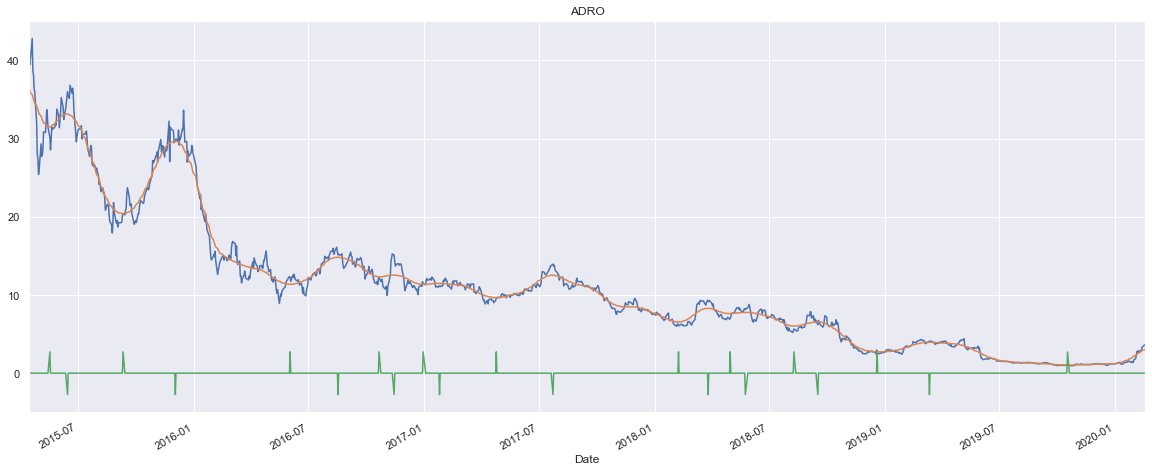

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2015-07-10  0.995749  0.981360  1.001635 -0.010028  -0.034663  0.010492   
2015-07-13  1.004254  0.994437  1.025851 -0.002618   0.020288  0.005111   
2015-07-14  0.995136  0.983463  1.003891 -0.005837   0.017510  0.005065   
2015-07-15  0.991599  0.980937  1.001939 -0.005385   0.011955  0.006497   
2015-07-16  1.040844  0.995648  1.043857  0.022877  -0.023100  0.019897   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2015-07-10  0.005494  -0.019948  0.022894  0.008306  ...  0.084369   
2015-07-13  0.001440  -0.023560  0.020754  0.001931  ...  0.081566   
2015-07-14 -0.012840  -0.025940  0.011038 -0.003080  ...  0.069520   
2015-07-15 -0.009822   0.032633  0.008262 -0.004620  ...  0.065245   
2015-07-16  0.023100  -0.014396  0.014075  0.028289  ...  0.100937   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2015-07-10   -0.037606   0.069978  0.062176    0.084696   0.070091  0.066656   
2015-07-13   -0.105366   0.071596  0.064282    0.063482   0.068148  0.062533   
2015-07-14   -0.066796   0.072145  0.054612   -0.000324   0.067535  0.047936   
2015-07-15   -0.014216   0.072285  0.050985    0.005493   0.067195  0.037830   
2015-07-16   -0.084700   0.077203  0.087334   -0.074322   0.070851  0.070444   

            PctDiff_60  StdDev_60  target  
Date                                       
2015-07-10   -0.373447   0.112623       0  
2015-07-13   -0.289267   0.109175       0  
2015-07-14   -0.297017   0.103518       0  
2015-07-15   -0.382876   0.093208       0  
2015-07-16   -0.294610   0.092651       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9663793103448276 std cross_val_score= 0.012610981757179127




*******************
*** BMCH        ***
*******************

min_ids= [26, 110, 184, 251, 304, 381, 443, 622, 723, 807, 867, 959, 1020, 1184, 1351, 1472]
max_ids= [105, 149, 212, 272, 368, 429, 474, 708, 759, 846, 925, 985, 1106, 1267, 1449]


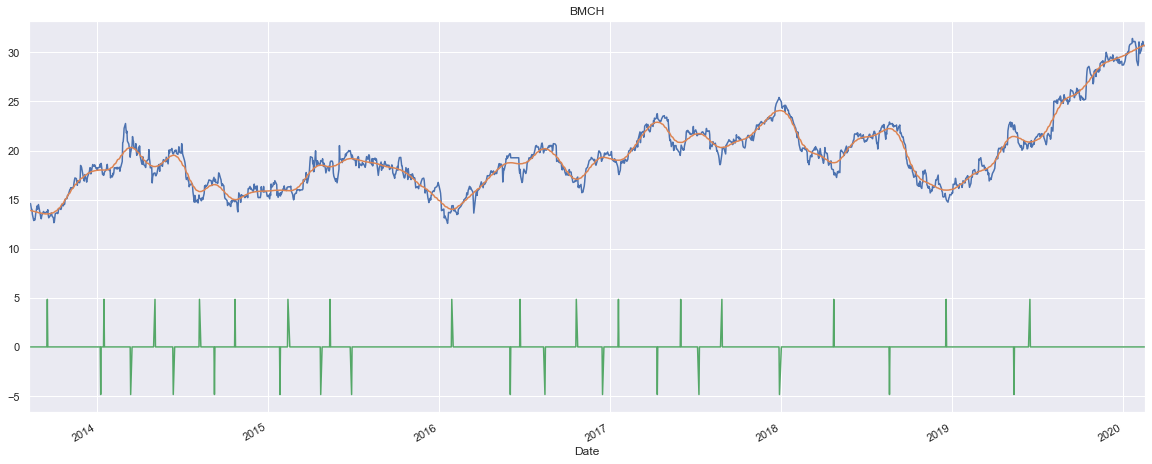

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2013-11-04  0.978763  0.975016  1.011868 -0.023111   0.036852  0.020307   
2013-11-05  0.996259  0.988155  1.003741 -0.011638   0.039900  0.018561   
2013-11-06  0.992597  0.988279  1.011104 -0.007608   0.043183  0.006654   
2013-11-07  1.008723  0.991900  1.008723  0.003115   0.002492  0.005944   
2013-11-08  0.991353  0.989500  1.009883 -0.002471   0.009265  0.005385   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2013-11-04 -0.032605   0.054966  0.020619 -0.055590  ... -0.116531   
2013-11-05 -0.022693   0.058603  0.020041 -0.047631  ... -0.112843   
2013-11-06 -0.023196   0.048735  0.021987 -0.047625  ... -0.116821   
2013-11-07 -0.005358   0.040498  0.016541 -0.028723  ... -0.103011   
2013-11-08 -0.005559   0.042001  0.005728 -0.029895  ... -0.104900   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2013-11-04    0.166771   0.053167 -0.129377    0.110556   0.047841 -0.131376   
2013-11-05    0.160224   0.056634 -0.127071    0.177057   0.051051 -0.131505   
2013-11-06    0.159778   0.059806 -0.131894    0.194941   0.053629 -0.138649   
2013-11-07    0.150156   0.062957 -0.119488    0.168847   0.056720 -0.127954   
2013-11-08    0.176035   0.064311 -0.123423    0.165534   0.059005 -0.133251   

            PctDiff_60  StdDev_60  target  
Date                                       
2013-11-04    0.098688   0.045454       0  
2013-11-05    0.089776   0.048210       0  
2013-11-06    0.117829   0.050972       0  
2013-11-07    0.126480   0.054149       0  
2013-11-08    0.134651   0.056460       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8976200934392844 std cross_val_score= 0.03998704164087625




*******************
*** CVI        ***
*******************

min_ids= [92, 132, 314, 367, 414, 457, 523, 587, 790, 941, 1000, 1169, 1234, 1340, 1524, 1625, 1675, 1794, 1838, 1881, 2029, 2120, 2227, 2404]
max_ids= [21, 115, 288, 360, 384, 418, 510, 554, 761, 824, 973, 1139, 1192, 1292, 1448, 1537, 1660, 1736, 1825, 1857, 1986, 2081, 2187, 2367, 2447]


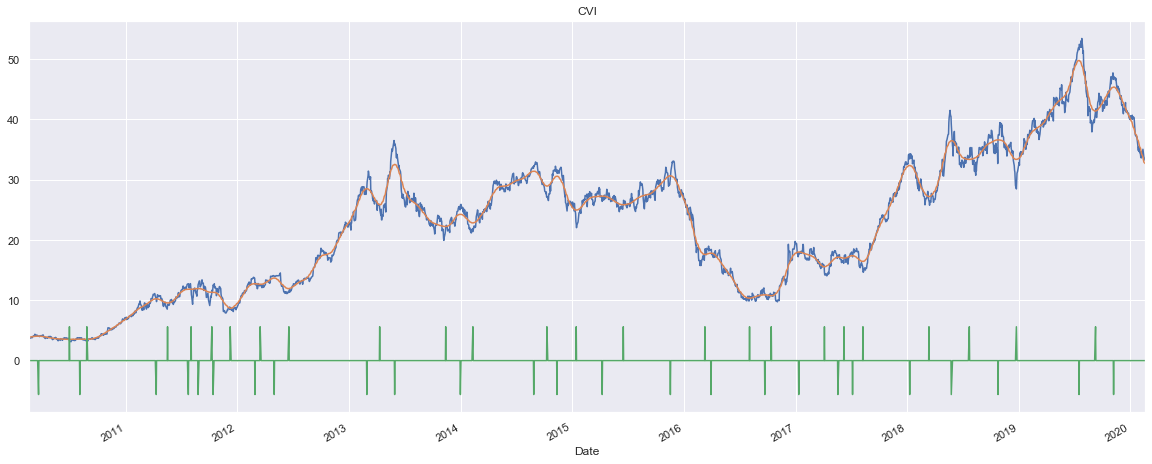

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  0.976684  0.968912  1.005181 -0.018135   0.025907  0.016179   
2010-05-18  1.048649  0.994595  1.054054  0.018018  -0.018919  0.022504   
2010-05-19  1.000000  0.970350  1.035040  0.012579  -0.008086  0.024159   
2010-05-20  1.022663  0.971671  1.022663  0.033050  -0.093484  0.028657   
2010-05-21  0.974648  0.971831  1.036620  0.013146  -0.042254  0.027791   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17 -0.027979   0.056995  0.021316 -0.046373  ... -0.009413   
2010-05-18  0.017838   0.018919  0.015944 -0.007027  ...  0.028288   
2010-05-19  0.012399  -0.013477  0.017322 -0.006739  ...  0.022192   
2010-05-20  0.050425  -0.067989  0.033483  0.043059  ...  0.069594   
2010-05-21  0.033803  -0.053521  0.037950  0.039155  ...  0.060563   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.098446   0.043358  0.015889   -0.113990   0.051653  0.020941   
2010-05-18   -0.154054   0.039440  0.056997   -0.127027   0.053613  0.064459   
2010-05-19   -0.099730   0.036989  0.051453   -0.121294   0.053062  0.061545   
2010-05-20   -0.141643   0.039018  0.100724   -0.195467   0.056177  0.114636   
2010-05-21   -0.090141   0.040136  0.090454   -0.183099   0.055931  0.107277   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.002591   0.053014       0  
2010-05-18   -0.037838   0.055836       0  
2010-05-19   -0.002695   0.055735       0  
2010-05-20   -0.062323   0.060072       0  
2010-05-21   -0.064789   0.061105       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8579048896395278 std cross_val_score= 0.03579618402355505




*******************
*** GGG        ***
*******************

min_ids= [88, 135, 399, 461, 602, 679, 784, 960, 994, 1058, 1118, 1164, 1292, 1358, 1401, 1483, 1573, 1663, 1855, 2017, 2056, 2104, 2189, 2229, 2335, 2415]
max_ids= [50, 111, 343, 440, 546, 646, 763, 940, 969, 1021, 1103, 1137, 1211, 1323, 1374, 1446, 1541, 1580, 1837, 1990, 2042, 2087, 2149, 2208, 2307, 2357]


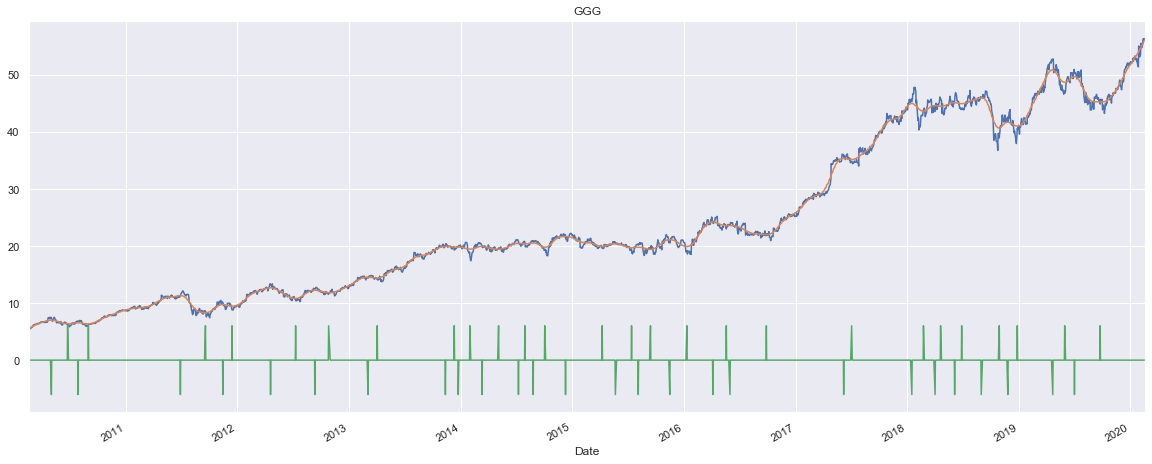

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.028129  0.976090  1.030942  0.025785  -0.056259  0.028421   
2010-05-18  1.030129  0.997131  1.041607  0.020564  -0.077475  0.020808   
2010-05-19  1.017647  0.985294  1.027941  0.023529  -0.067647  0.022830   
2010-05-20  1.018377  0.987749  1.026034  0.036243  -0.088821  0.033979   
2010-05-21  0.956652  0.952167  1.019432 -0.002491  -0.041854  0.020294   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.032349  -0.023910  0.024157  0.011252  ... -0.010361   
2010-05-18  0.043329  -0.048780  0.034469  0.028264  ...  0.010760   
2010-05-19  0.048529  -0.104412  0.040018  0.050147  ...  0.036569   
2010-05-20  0.061868  -0.150077  0.043295  0.088974  ...  0.079020   
2010-05-21  0.019432  -0.085202  0.034086  0.060837  ...  0.053612   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17    0.054852   0.049210 -0.035849    0.118143   0.055211 -0.068776   
2010-05-18    0.037303   0.049455 -0.014315    0.097561   0.054990 -0.046557   
2010-05-19    0.016176   0.050201  0.011797    0.066176   0.055174 -0.019706   
2010-05-20   -0.012251   0.052864  0.054007    0.016845   0.057039  0.023277   
2010-05-21    0.011958   0.051123  0.029663    0.038864   0.054897  0.001470   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.188467   0.077304       0  
2010-05-18    0.210904   0.076223       0  
2010-05-19    0.180882   0.075363       0  
2010-05-20    0.147014   0.075384       0  
2010-05-21    0.159940   0.070568       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8753994668256254 std cross_val_score= 0.022100409086423096




*******************
*** GURE        ***
*******************

min_ids= [109, 151, 335, 391, 463, 622, 651, 798, 989, 1066, 1094, 1215, 1406, 1495, 1564, 1597, 1799, 1852, 1972, 2069, 2222, 2277, 2472]
max_ids= [24, 115, 207, 353, 411, 506, 647, 686, 954, 1023, 1086, 1102, 1315, 1442, 1524, 1596, 1703, 1815, 1913, 1995, 2084, 2261, 2310]


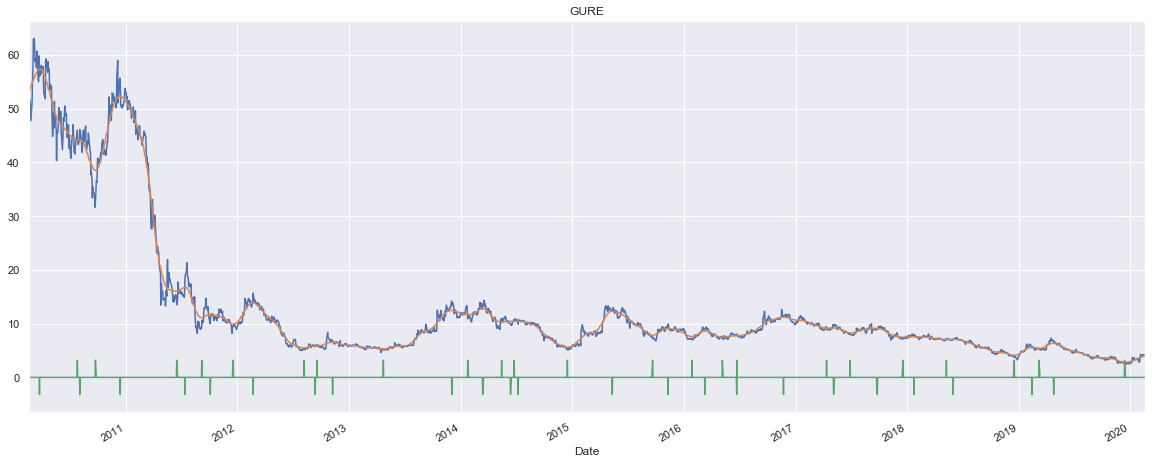

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.030271  0.939457  1.034447  0.032011  -0.063674  0.036673   
2010-05-18  1.053763  0.995699  1.059140  0.028315  -0.104301  0.027463   
2010-05-19  0.987013  0.952381  1.008658  0.014430  -0.061688  0.019640   
2010-05-20  1.070720  0.973945  1.115385  0.100083  -0.188586  0.086754   
2010-05-21  0.870718  0.851934  1.004420 -0.029466  -0.027624  0.070010   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.025470  -0.027140  0.043652  0.013883  ...  0.113187   
2010-05-18  0.056989   0.003226  0.043909  0.034624  ...  0.138566   
2010-05-19  0.043290  -0.102814  0.045435  0.036255  ...  0.139322   
2010-05-20  0.141191  -0.274194  0.083866  0.172829  ...  0.295575   
2010-05-21 -0.000442  -0.083978  0.064419  0.045414  ...  0.148361   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.204593   0.086592  0.144166   -0.240084   0.085076  0.148365   
2010-05-18   -0.244086   0.091122  0.173286   -0.239785   0.091057  0.181183   
2010-05-19   -0.199134   0.094884  0.174868   -0.271645   0.094439  0.187193   
2010-05-20   -0.316377   0.122248  0.335622   -0.506203   0.117259  0.357920   
2010-05-21   -0.164641   0.112405  0.182222   -0.328177   0.105975  0.208195   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.092902   0.092574       0  
2010-05-18   -0.105376   0.097754       0  
2010-05-19   -0.099567   0.100732       0  
2010-05-20   -0.184864   0.122510       0  
2010-05-21   -0.070718   0.110998       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8676593313794646 std cross_val_score= 0.042261659597778646




*******************
*** HWC        ***
*******************

min_ids= [133, 340, 397, 443, 581, 621, 680, 812, 906, 1003, 1066, 1130, 1163, 1240, 1310, 1404, 1496, 1529, 1791, 1893, 2014, 2061, 2108, 2226, 2287, 2347, 2396]
max_ids= [29, 216, 349, 433, 532, 612, 658, 723, 874, 976, 1031, 1094, 1144, 1190, 1285, 1343, 1443, 1524, 1766, 1852, 2008, 2021, 2081, 2139, 2268, 2308, 2361, 2484]


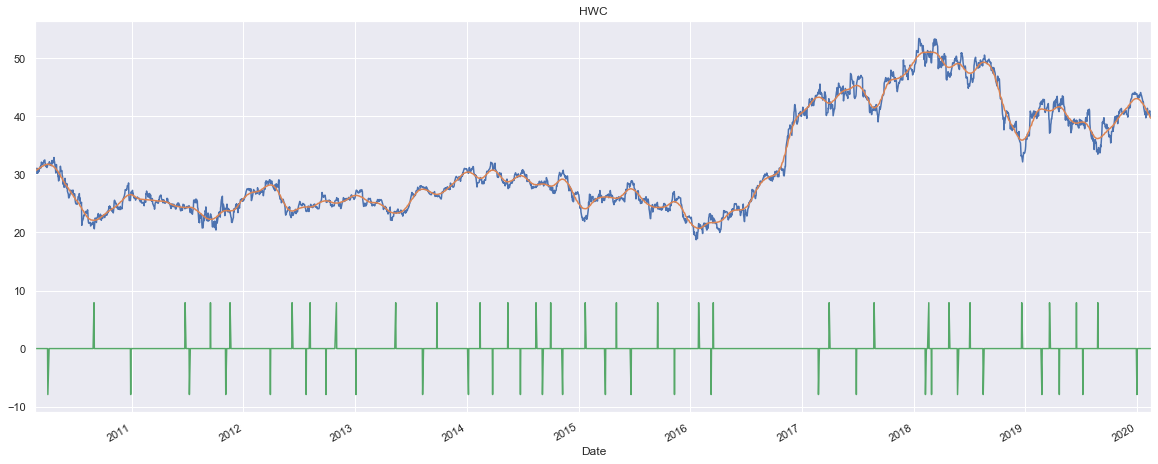

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  0.999348  0.963796  1.012068  0.002718  -0.024462  0.008644   
2010-05-18  1.039597  0.991611  1.040268  0.017785  -0.041611  0.015556   
2010-05-19  1.001346  0.988896  1.025908  0.011440  -0.027254  0.017535   
2010-05-20  1.034556  0.998942  1.042666  0.032910  -0.081100  0.028536   
2010-05-21  0.983287  0.971448  1.022284  0.007428  -0.037604  0.024535   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.005806   0.015003  0.012393 -0.016667  ...  0.016732   
2010-05-18  0.029799  -0.025168  0.020270  0.012248  ...  0.043412   
2010-05-19  0.021198  -0.056864  0.019211  0.015242  ...  0.043854   
2010-05-20  0.051269  -0.094499  0.032276  0.062094  ...  0.090009   
2010-05-21  0.025487  -0.063022  0.032009  0.048015  ...  0.073062   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.034573   0.035064  0.023106   -0.042401   0.030690  0.020238   
2010-05-18   -0.079866   0.036441  0.051245   -0.062416   0.032494  0.049055   
2010-05-19   -0.070996   0.037173  0.052550   -0.068641   0.033479  0.051609   
2010-05-20   -0.117066   0.042278  0.100141   -0.129760   0.038044  0.100447   
2010-05-21   -0.098538   0.043769  0.083759   -0.116643   0.039409  0.085370   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.000326   0.028475       0  
2010-05-18   -0.037584   0.029954       0  
2010-05-19   -0.016151   0.030430       0  
2010-05-20   -0.095557   0.034498       0  
2010-05-21   -0.076950   0.035840       0  

[5 rows x 28 columns]


mean cross_val_score= 0.7882908615236867 std cross_val_score= 0.07368871247308267




*******************
*** MBI        ***
*******************

min_ids= [84, 200, 332, 384, 535, 571, 616, 707, 719, 788, 848, 917, 981, 1064, 1119, 1167, 1249, 1368, 1472, 1591, 1668, 1823, 1934, 1991, 2071, 2224, 2340, 2388, 2492]
max_ids= [48, 172, 232, 351, 483, 541, 601, 648, 714, 769, 824, 853, 949, 1024, 1077, 1137, 1196, 1287, 1435, 1535, 1632, 1730, 1880, 1958, 2047, 2158, 2276, 2365, 2443]


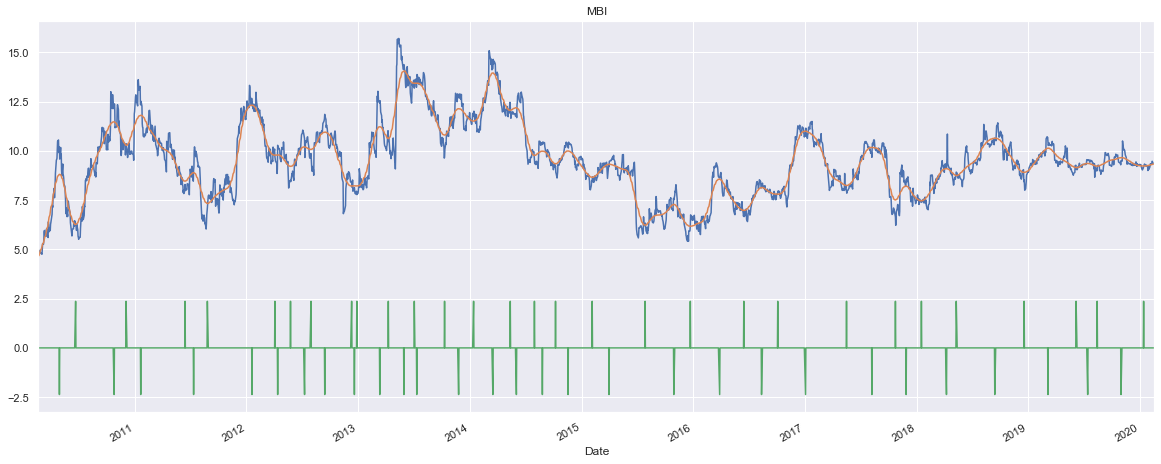

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.012210  0.971917  1.021978  0.022385  -0.068376  0.027092   
2010-05-18  1.068615  0.991105  1.073698  0.032190  -0.095299  0.028901   
2010-05-19  1.029216  0.981408  1.057105  0.044267  -0.103586  0.043831   
2010-05-20  1.066079  0.982379  1.083700  0.087127  -0.202643  0.079476   
2010-05-21  0.922535  0.919718  1.016901  0.006573  -0.108451  0.051023   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.040781  -0.139194  0.031647  0.088767  ...  0.095686   
2010-05-18  0.060737  -0.111817  0.044494  0.110419  ...  0.142906   
2010-05-19  0.076228  -0.162019  0.055568  0.130013  ...  0.196282   
2010-05-20  0.136858  -0.265786  0.088511  0.217181  ...  0.319139   
2010-05-21  0.056338  -0.170423  0.078735  0.144507  ...  0.262488   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17    0.172161   0.121694 -0.024854    0.305250   0.200021 -0.111477   
2010-05-18    0.080051   0.122620  0.021036    0.280813   0.203242 -0.069102   
2010-05-19    0.053121   0.124944  0.072392    0.236388   0.207610 -0.021049   
2010-05-20   -0.108664   0.145205  0.188612    0.127753   0.226363  0.087176   
2010-05-21   -0.083099   0.143776  0.143380    0.149296   0.213709  0.048005   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.389499   0.231002       0  
2010-05-18    0.374841   0.237331       0  
2010-05-19    0.361222   0.244153       0  
2010-05-20    0.283407   0.265905       0  
2010-05-21    0.314085   0.250784       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8591475833291937 std cross_val_score= 0.05680225328228823




*******************
*** PANW        ***
*******************

min_ids= [106, 233, 321, 446, 782, 824, 896, 997, 1113, 1189, 1272, 1346, 1600, 1737, 1795, 1863]
max_ids= [36, 152, 263, 409, 751, 799, 853, 925, 1067, 1143, 1248, 1323, 1547, 1689, 1763, 1847]


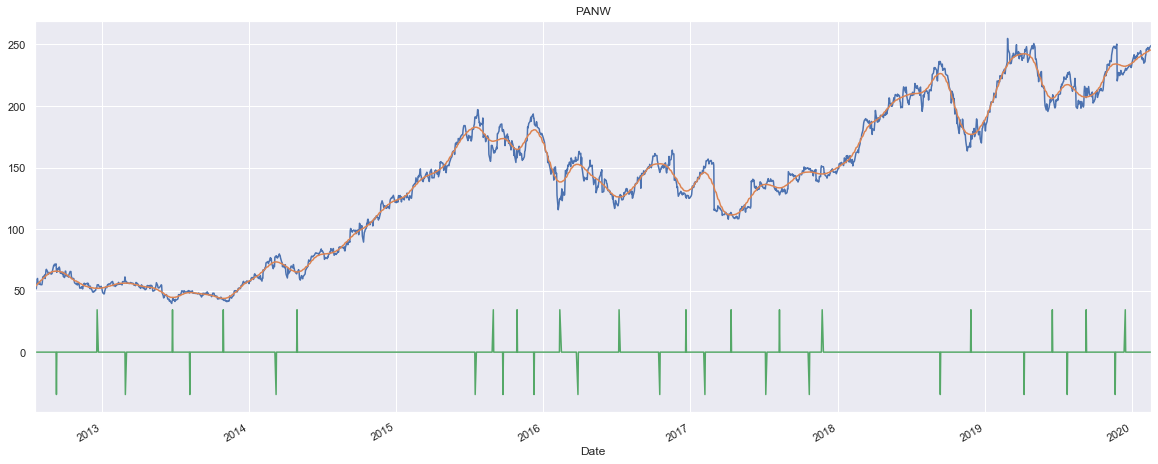

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2012-10-15  0.962777  0.959878  1.003814 -0.036512   0.062700  0.035108   
2012-10-16  1.004880  0.980631  1.005948 -0.013370   0.070307  0.022894   
2012-10-17  0.995878  0.984885  1.022901  0.000611   0.038779  0.000550   
2012-10-18  1.035218  0.996607  1.035218  0.039149  -0.058966  0.033909   
2012-10-19  1.030323  0.983006  1.046151  0.040875  -0.092469  0.046395   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2012-10-15 -0.045400   0.053089  0.027790 -0.038047  ... -0.000976   
2012-10-16 -0.034680   0.055056  0.033470 -0.032896  ... -0.003640   
2012-10-17 -0.021252   0.061985  0.031826 -0.032412  ... -0.004865   
2012-10-18  0.038708   0.015186  0.028180  0.017625  ...  0.047889   
2012-10-19  0.061446  -0.048984  0.043240  0.046201  ...  0.074758   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2012-10-15    0.017849   0.050801 -0.008153    0.064531   0.045064 -0.038416   
2012-10-16   -0.070764   0.048934 -0.007490    0.043465   0.044747 -0.035135   
2012-10-17   -0.068702   0.047109 -0.004495    0.087023   0.043082 -0.031560   
2012-10-18   -0.153635   0.046963  0.053104   -0.013409   0.045898  0.025557   
2012-10-19   -0.178607   0.046939  0.083691   -0.107964   0.048911  0.057720   

            PctDiff_60  StdDev_60  target  
Date                                       
2012-10-15    0.189474   0.069020       0  
2012-10-16    0.214427   0.065191       0  
2012-10-17    0.152672   0.063512       0  
2012-10-18    0.047658   0.066615       0  
2012-10-19    0.002333   0.068667       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9009082252984693 std cross_val_score= 0.05281767469926931




*******************
*** SIBN        ***
*******************

min_ids= [22, 85, 140, 203, 255]
max_ids= [53, 93, 187, 219, 316]


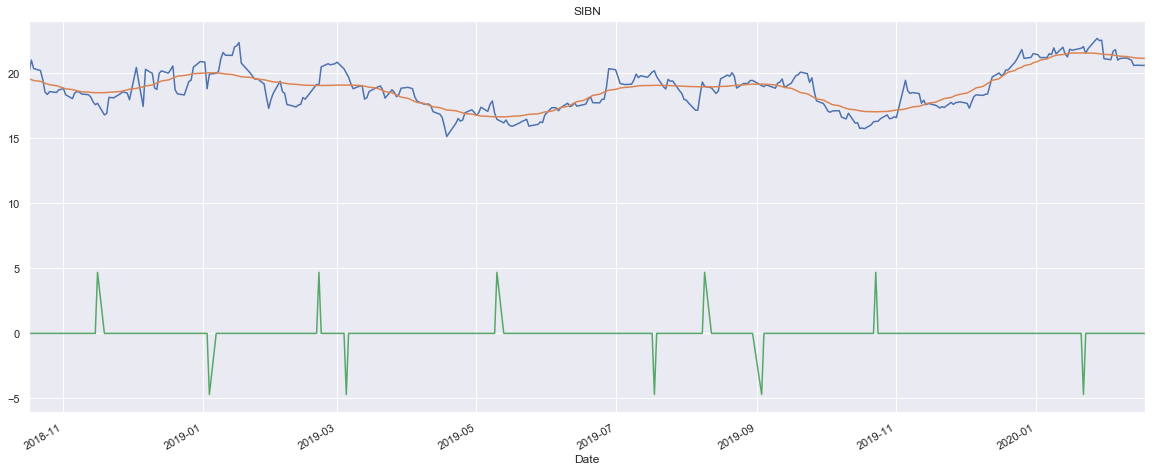

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2019-01-15  0.972727  0.970909  1.024091 -0.019091   0.018636  0.016539   
2019-01-16  1.000000  0.975577  1.041610 -0.012965   0.033017  0.018318   
2019-01-17  0.984340  0.976286  1.027740 -0.008799   0.044295  0.008008   
2019-01-18  1.088108  0.989889  1.088108  0.046862  -0.059220  0.040993   
2019-01-22  1.025513  0.947974  1.046023  0.052360  -0.106053  0.060149   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2019-01-15 -0.023545   0.085000  0.015529 -0.058636  ... -0.095803   
2019-01-16 -0.019086   0.046585  0.015789 -0.057621  ... -0.094045   
2019-01-17 -0.022819   0.034004  0.020017 -0.051857  ... -0.100925   
2019-01-18  0.045643  -0.029369  0.031011  0.024362  ... -0.030332   
2019-01-22  0.072736  -0.068534  0.050905  0.064332  ...  0.011756   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2019-01-15    0.160455   0.051085 -0.124071    0.155000   0.059747 -0.127288   
2019-01-16    0.187698   0.051252 -0.124840    0.161465   0.062219 -0.130793   
2019-01-17    0.085459   0.054056 -0.130311    0.176734   0.064352 -0.138635   
2019-01-18    0.065961   0.058107 -0.061552    0.116996   0.069415 -0.072653   
2019-01-22    0.127564   0.054765 -0.022911    0.091046   0.071501 -0.036060   

            PctDiff_60  StdDev_60  target  
Date                                       
2019-01-15    0.088182   0.055333       0  
2019-01-16    0.050204   0.056674       0  
2019-01-17    0.089485   0.058569       0  
2019-01-18    0.027443   0.063460       0  
2019-01-22    0.024512   0.066087       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9672727272727272 std cross_val_score= 0.007272727272727275




*******************
*** SPPI        ***
*******************

min_ids= [87, 136, 238, 318, 401, 552, 694, 794, 837, 885, 1052, 1118, 1296, 1447, 1504, 1690, 1829, 1972, 2053, 2236, 2342, 2383, 2435]
max_ids= [7, 113, 229, 292, 357, 476, 605, 739, 829, 860, 947, 1089, 1148, 1369, 1466, 1567, 1802, 1952, 2008, 2132, 2259, 2353, 2412, 2459]


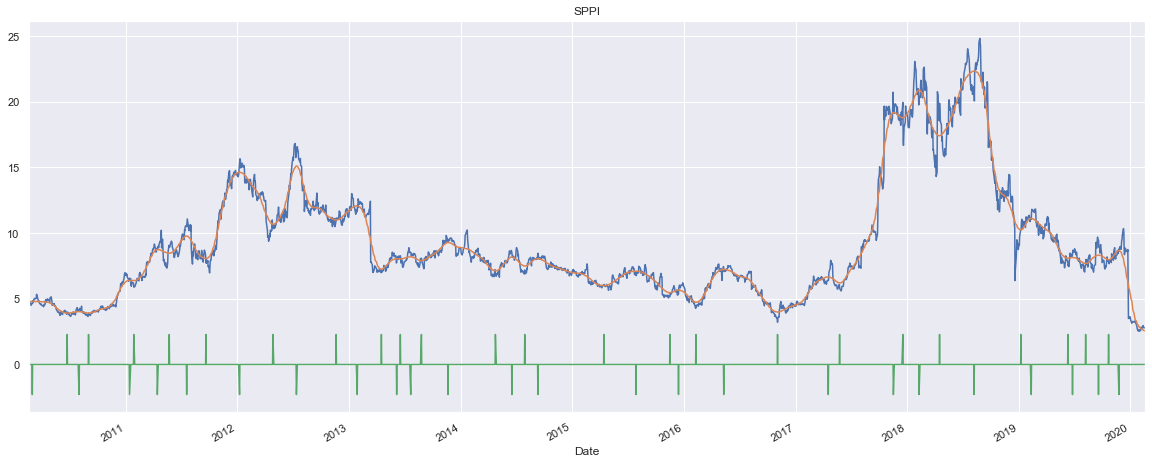

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.008897  0.984459  1.028897  0.014077  -0.044460  0.017260   
2010-05-18  1.017970  0.979775  1.026967  0.010485  -0.044937  0.010133   
2010-05-19  1.030358  0.985981  1.035047  0.030366  -0.060740  0.026938   
2010-05-20  1.004731  0.973941  1.011840  0.022904  -0.066335  0.028267   
2010-05-21  0.990515  0.981005  1.018995  0.006340  -0.057008  0.008996   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.021338  -0.031127  0.017961  0.040008  ...  0.067860   
2010-05-18  0.026516  -0.031454  0.023432  0.038651  ...  0.079401   
2010-05-19  0.047654  -0.098132  0.031714  0.064711  ...  0.120476   
2010-05-20  0.042174  -0.101881  0.033271  0.071557  ...  0.134511   
2010-05-21  0.028981  -0.078386  0.031925  0.063660  ...  0.133889   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.011126   0.050822  0.074380   -0.124462   0.054922  0.075714   
2010-05-18   -0.013483   0.052048  0.083098   -0.150572   0.056120  0.086482   
2010-05-19   -0.053731   0.057259  0.120191   -0.266357   0.057299  0.127525   
2010-05-20   -0.056872   0.061581  0.131010   -0.229844   0.059765  0.141898   
2010-05-21   -0.099764   0.066331  0.128058   -0.254153   0.060274  0.142917   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.068898   0.051549       0  
2010-05-18   -0.078645   0.053337       0  
2010-05-19   -0.126169   0.057925       0  
2010-05-20   -0.099527   0.061360       0  
2010-05-21   -0.102147   0.064063       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8741774708989452 std cross_val_score= 0.0616060525558994






In [27]:
min_tickers = []
min_indexes = []
max_indexes = []

for ticker in tickers:
    
    # free up memory
    gc.collect()
    
    # print ticker heading
    print("*******************")
    print("***", ticker, " "*6, "***" )
    print("*******************")
    print('')

    # get stock data and smooth the Close curve
    hist = ticker_stats(ticker, 3, False)
    hist = smooth(hist)
    
    # set target and calculate mean Close
    target = 'target'
    hist[target] = 0
    mean_close = hist.Close.mean()

    # identify the minima of the curve (save a copy of the data for later)
    min_ids = argrelmin(hist.smooth.values)[0].tolist()
    print("min_ids=", min_ids)
    min_tickers.append(ticker)
    min_indexes.append(min_ids)

    # identify the maxima and save a copy of the data for later processing
    max_ids = argrelmax(hist.smooth.values)[0].tolist()
    print("max_ids=", max_ids)
    max_indexes.append(max_ids)

    # set the local minima to onbe and local maxima to minus one
    hist[target].iloc[min_ids] = 1
    hist[target].iloc[max_ids] = -1

    # plot the Close and smooth curve and the buy and sell signals 
    plt.figure(figsize=(20,8))
    hist.Close.plot()
    hist.smooth.plot()
    (hist[target]*(mean_close/4)).plot()
    plt.title(ticker)
    plt.show()
    
    # NB: we do not include smooth in data!
    data = hist[['Close', 'Open', 'Low', 'High']]
    data = features(data, target)
    
    # Pipeline for weighted evidence balanced scorecard
    encoder   = WOEEncoder()
    binner    = KBinsDiscretizer(n_bins=5, encode='ordinal')
    objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
    imputer   = SimpleImputer(strategy='constant', fill_value=0.0)
    clf       = LogisticRegression(class_weight='balanced', random_state=42)

    pipe = make_pipeline(binner, objectify, encoder, imputer, clf)

    # cross validate after initializing X and y
    used_cols = [c for c in data.columns.tolist() if c not in [target]]
    data[target] = data[target].apply(lambda x: 1 if x == 1 else 0)
    X, y = data[used_cols].values, data[target].values
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    
    # print results of cross validation
    print('')
    print("mean cross_val_score=", scores.mean(), "std cross_val_score=", scores.std())
    print('\n\n\n')

# Ensure Alignment between Buy and Sell signals

The cell below ensures that there is no sell signal before a buy signal for each stock. This is needed for the next code block that plots the buy and sell signal and then calculates how much money is earned or lost.

In [28]:
for i, ticker in enumerate(min_tickers):
    if len(min_indexes) == 0 or len(max_indexes) == 0:
        continue
    
    min_id = min_indexes[i][0]
    max_id = max_indexes[i][0]
    print('Ticker:', ticker, "min_id=", min_id, "max_id=", max_id)
    
    modified=""
    while min_id > max_id:
        modified=" (*)"
        max_indexes[i].pop(0)
        if len(max_indexes) == 0:
            break
        else:
            max_id = max_indexes[i][0]

    print('     ', ticker, "min_id=", min_id, "max_id=", max_id, modified)

Ticker: ADRO min_id= 23 max_id= 42
      ADRO min_id= 23 max_id= 42
Ticker: BMCH min_id= 26 max_id= 105
      BMCH min_id= 26 max_id= 105
Ticker: CVI min_id= 92 max_id= 21
      CVI min_id= 92 max_id= 115
Ticker: GGG min_id= 88 max_id= 50
      GGG min_id= 88 max_id= 111
Ticker: GURE min_id= 109 max_id= 24
      GURE min_id= 109 max_id= 115
Ticker: HWC min_id= 133 max_id= 29
      HWC min_id= 133 max_id= 216
Ticker: MBI min_id= 84 max_id= 48
      MBI min_id= 84 max_id= 172
Ticker: PANW min_id= 106 max_id= 36
      PANW min_id= 106 max_id= 152
Ticker: SIBN min_id= 22 max_id= 53
      SIBN min_id= 22 max_id= 53
Ticker: SPPI min_id= 87 max_id= 7
      SPPI min_id= 87 max_id= 113


# Plot Each Trade

The following cell loops through the tickers and for each ticker identify a buy - sell transaction. For each transaction a plot is produced showing the buy signal and the sell signal. These are shown as red dots on the Close price curve. For each trade transaction it calculates statistics. 

NB: some of the graph will only show a buy signal as the sell signal has not yet occurred. This is the case for ADRO, BMCH, GGG, GURE, MBI and PANW. For those stocks we still need to see a sell signal. 

Note that the code below assumes that the buy and sell signal are exactly as idenbtified by `argrelmin()` and `argrelmax()`. This would only be the case if our cross validation score would be 1.0. Since they are lower, mistakes will be made, and we need to still reflect that in the code. This will be done as part of the back testing code.

*******************
*** ADRO        ***
*******************

    buy_close= 30.13 buy_date= 2015-05-18 00:00:00 buy_id= 23
    sell_close= 36.0 sell_date= 2015-06-15 00:00:00 sell_id= 42
    gain= 5.870000000000001 gain_pct=19.5%
    subset_slopes:
    min= -0.008386127241582386 max= 0.1414892952398148 mean= 0.08640286964343695 std= 0.04570207164104843
    days in trade= 19
    daily compounded return=0.94%
    buy_id= 18 sell_id= 47


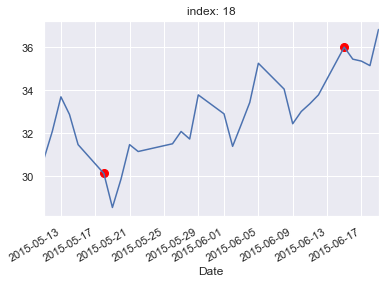

    buy_close= 20.4 buy_date= 2015-09-11 00:00:00 buy_id= 104
    sell_close= 29.79 sell_date= 2015-12-03 00:00:00 sell_id= 162
    gain= 9.39 gain_pct=46.0%
    subset_slopes:
    min= -0.0024640058790659225 max= 0.2645673561281825 mean= 0.15922744944301434 std= 0.08157912361051431
    days in trade= 58
    daily compounded return=0.65%
    buy_id= 99 sell_id= 167


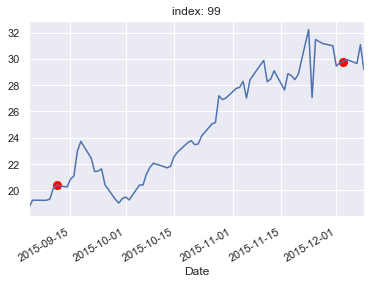

    buy_close= 12.27 buy_date= 2016-06-02 00:00:00 buy_id= 286
    sell_close= 15.13 sell_date= 2016-08-17 00:00:00 sell_id= 339
    gain= 2.860000000000001 gain_pct=23.3%
    subset_slopes:
    min= -0.004329298473898291 max= 0.12647725021616907 mean= 0.06505150227108028 std= 0.039395911480771435
    days in trade= 53
    daily compounded return=0.4%
    buy_id= 281 sell_id= 344


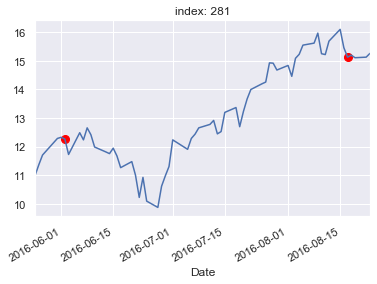

    buy_close= 12.25 buy_date= 2016-10-21 00:00:00 buy_id= 385
    sell_close= 15.1 sell_date= 2016-11-14 00:00:00 sell_id= 401
    gain= 2.8499999999999996 gain_pct=23.3%
    subset_slopes:
    min= -0.004525263677438218 max= 0.022781201666923323 mean= 0.014427227214785399 std= 0.0078643956825217
    days in trade= 16
    daily compounded return=1.32%
    buy_id= 380 sell_id= 406


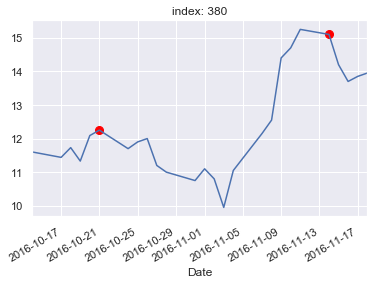

    buy_close= 11.4 buy_date= 2016-12-30 00:00:00 buy_id= 433
    sell_close= 11.15 sell_date= 2017-01-25 00:00:00 sell_id= 449
    gain= -0.25 gain_pct=-2.2%
    subset_slopes:
    min= -0.002490318514686507 max= 0.011666891450483163 mean= 0.0071080288912863665 std= 0.004128455170709454
    days in trade= 16
    daily compounded return=-0.14%
    buy_id= 428 sell_id= 454


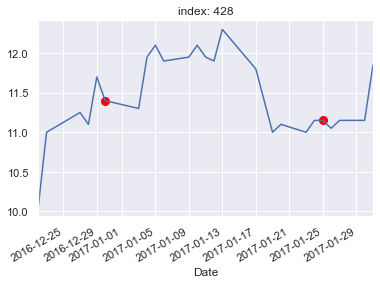

    buy_close= 9.6 buy_date= 2017-04-25 00:00:00 buy_id= 511
    sell_close= 13.95 sell_date= 2017-07-24 00:00:00 sell_id= 573
    gain= 4.35 gain_pct=45.3%
    subset_slopes:
    min= -0.0030657249687457977 max= 0.09281125660992195 mean= 0.0462570810806378 std= 0.02804079955282638
    days in trade= 62
    daily compounded return=0.6%
    buy_id= 506 sell_id= 578


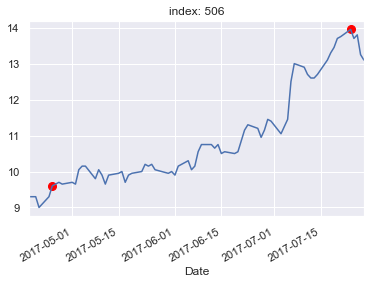

    buy_close= 6.05 buy_date= 2018-02-08 00:00:00 buy_id= 711
    sell_close= 9.3 sell_date= 2018-03-27 00:00:00 sell_id= 743
    gain= 3.250000000000001 gain_pct=53.7%
    subset_slopes:
    min= -0.00024332851917918674 max= 0.08792110515073936 mean= 0.05453190691298615 std= 0.02763217525787379
    days in trade= 32
    daily compounded return=1.35%
    buy_id= 706 sell_id= 748


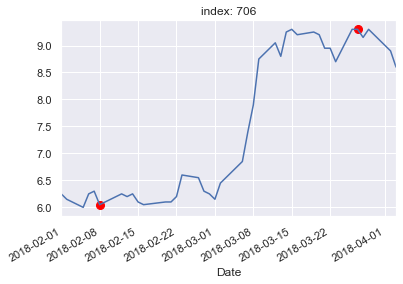

    buy_close= 7.0 buy_date= 2018-05-01 00:00:00 buy_id= 767
    sell_close= 8.15 sell_date= 2018-05-25 00:00:00 sell_id= 785
    gain= 1.1500000000000004 gain_pct=16.4%
    subset_slopes:
    min= -0.0001647515367837471 max= 0.01296017251620274 mean= 0.00867432931549904 std= 0.0038593234651992615
    days in trade= 18
    daily compounded return=0.85%
    buy_id= 762 sell_id= 790


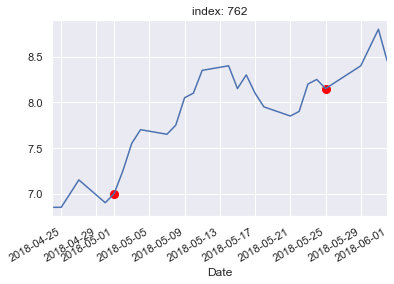

    buy_close= 5.65 buy_date= 2018-08-10 00:00:00 buy_id= 838
    sell_close= 6.2 sell_date= 2018-09-17 00:00:00 sell_id= 863
    gain= 0.5499999999999998 gain_pct=9.7%
    subset_slopes:
    min= -0.0005389016496977206 max= 0.031209523747950385 mean= 0.02118137558338159 std= 0.009261499414934073
    days in trade= 25
    daily compounded return=0.37%
    buy_id= 833 sell_id= 868


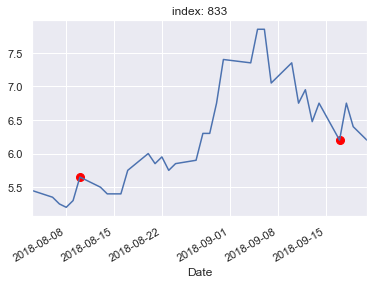

    buy_close= 2.83 buy_date= 2018-12-20 00:00:00 buy_id= 929
    sell_close= 3.95 sell_date= 2019-03-13 00:00:00 sell_id= 984
    gain= 1.12 gain_pct=39.6%
    subset_slopes:
    min= -0.0014455200312633032 max= 0.04136457718282838 mean= 0.022671262858763457 std= 0.013982270602896696
    days in trade= 55
    daily compounded return=0.61%
    buy_id= 924 sell_id= 989


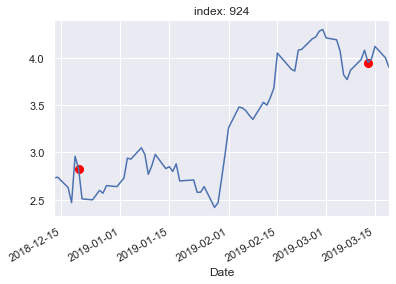

    buy_close= 1.01 buy_date= 2019-10-18 00:00:00 buy_id= 1137
    buy_id= 1132 sell_id= 1152


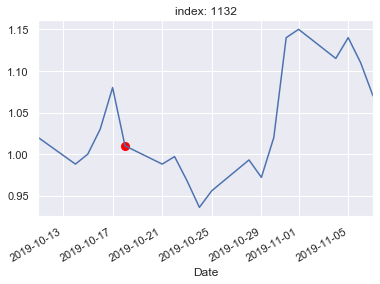


*******************
*** BMCH        ***
*******************

    buy_close= 13.75 buy_date= 2013-09-17 00:00:00 buy_id= 26
    sell_close= 18.32 sell_date= 2014-01-09 00:00:00 sell_id= 105
    gain= 4.57 gain_pct=33.2%
    subset_slopes:
    min= -0.00026288875126923017 max= 0.10686270632581873 mean= 0.05663399775045403 std= 0.03369236986131924
    days in trade= 79
    daily compounded return=0.36%
    buy_id= 21 sell_id= 110


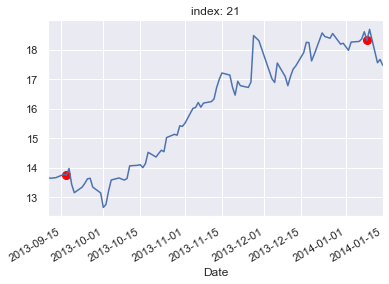

    buy_close= 17.53 buy_date= 2014-01-16 00:00:00 buy_id= 110
    sell_close= 19.77 sell_date= 2014-03-14 00:00:00 sell_id= 149
    gain= 2.2399999999999984 gain_pct=12.8%
    subset_slopes:
    min= -0.0002693003121372328 max= 0.09839695115268299 mean= 0.058942651530498796 std= 0.03279950096344366
    days in trade= 39
    daily compounded return=0.31%
    buy_id= 105 sell_id= 154


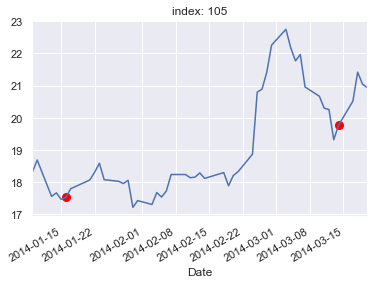

    buy_close= 17.72 buy_date= 2014-05-05 00:00:00 buy_id= 184
    sell_close= 19.63 sell_date= 2014-06-13 00:00:00 sell_id= 212
    gain= 1.9100000000000001 gain_pct=10.8%
    subset_slopes:
    min= -0.004029546541026718 max= 0.06544379355850083 mean= 0.040782077332200926 std= 0.02090064867044323
    days in trade= 28
    daily compounded return=0.37%
    buy_id= 179 sell_id= 217


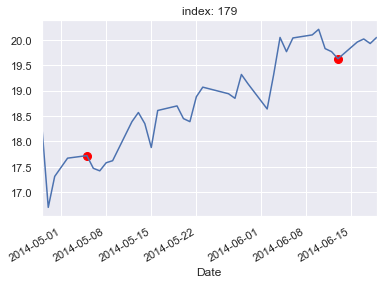

    buy_close= 15.15 buy_date= 2014-08-08 00:00:00 buy_id= 251
    sell_close= 16.85 sell_date= 2014-09-09 00:00:00 sell_id= 272
    gain= 1.700000000000001 gain_pct=11.2%
    subset_slopes:
    min= -0.008043012701040908 max= 0.05286280071465299 mean= 0.033269174171199095 std= 0.017614425858740988
    days in trade= 21
    daily compounded return=0.51%
    buy_id= 246 sell_id= 277


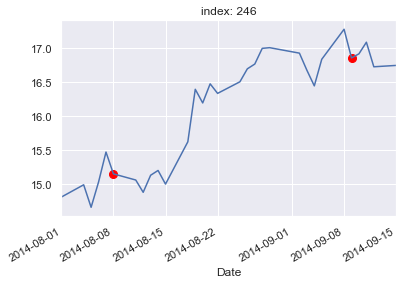

    buy_close= 14.98 buy_date= 2014-10-23 00:00:00 buy_id= 304
    sell_close= 15.62 sell_date= 2015-01-27 00:00:00 sell_id= 368
    gain= 0.6399999999999988 gain_pct=4.3%
    subset_slopes:
    min= -0.006078174215568666 max= 0.041593171987978295 mean= 0.015102763702384336 std= 0.01373182473393925
    days in trade= 64
    daily compounded return=0.07%
    buy_id= 299 sell_id= 373


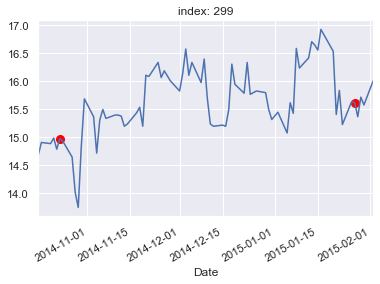

    buy_close= 16.3 buy_date= 2015-02-13 00:00:00 buy_id= 381
    sell_close= 18.98 sell_date= 2015-04-24 00:00:00 sell_id= 429
    gain= 2.6799999999999997 gain_pct=16.4%
    subset_slopes:
    min= -0.0017882773805055763 max= 0.09613139362812717 mean= 0.05413363869871427 std= 0.031792112543547975
    days in trade= 48
    daily compounded return=0.32%
    buy_id= 376 sell_id= 434


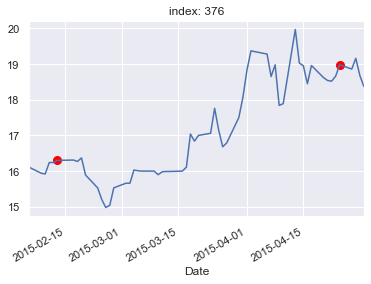

    buy_close= 18.74 buy_date= 2015-05-14 00:00:00 buy_id= 443
    sell_close= 19.28 sell_date= 2015-06-29 00:00:00 sell_id= 474
    gain= 0.5400000000000027 gain_pct=2.9%
    subset_slopes:
    min= -1.5613549777526714e-05 max= 0.04261197467139155 mean= 0.0268584115713646 std= 0.013253305864004559
    days in trade= 31
    daily compounded return=0.09%
    buy_id= 438 sell_id= 479


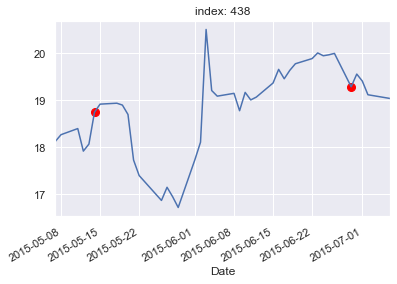

    buy_close= 14.37 buy_date= 2016-01-29 00:00:00 buy_id= 622
    sell_close= 19.65 sell_date= 2016-06-02 00:00:00 sell_id= 708
    gain= 5.279999999999999 gain_pct=36.7%
    subset_slopes:
    min= -0.004272140953361259 max= 0.07420615406991615 mean= 0.05517660058198987 std= 0.017583243057592332
    days in trade= 86
    daily compounded return=0.36%
    buy_id= 617 sell_id= 713


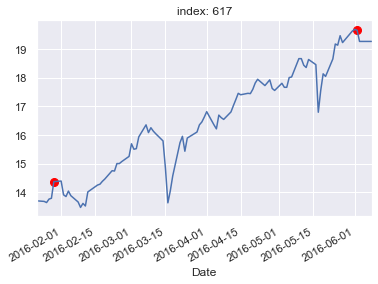

    buy_close= 18.09 buy_date= 2016-06-23 00:00:00 buy_id= 723
    sell_close= 20.19 sell_date= 2016-08-15 00:00:00 sell_id= 759
    gain= 2.1000000000000014 gain_pct=11.6%
    subset_slopes:
    min= -0.0003149889556226526 max= 0.07078350461395644 mean= 0.0425934909443102 std= 0.022345898849956015
    days in trade= 36
    daily compounded return=0.31%
    buy_id= 718 sell_id= 764


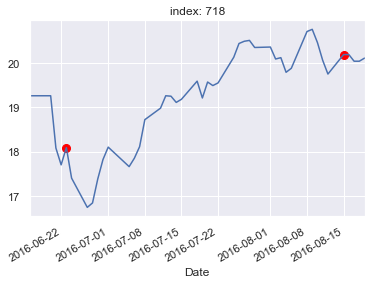

    buy_close= 17.1 buy_date= 2016-10-21 00:00:00 buy_id= 807
    sell_close= 19.15 sell_date= 2016-12-16 00:00:00 sell_id= 846
    gain= 2.049999999999997 gain_pct=12.0%
    subset_slopes:
    min= -0.003805053116796131 max= 0.09174754145559305 mean= 0.05712476018415831 std= 0.028738172200151475
    days in trade= 39
    daily compounded return=0.29%
    buy_id= 802 sell_id= 851


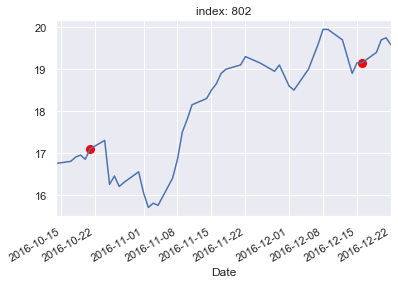

    buy_close= 17.75 buy_date= 2017-01-19 00:00:00 buy_id= 867
    sell_close= 23.75 sell_date= 2017-04-12 00:00:00 sell_id= 925
    gain= 6.0 gain_pct=33.8%
    subset_slopes:
    min= -0.00011038308811706088 max= 0.1016869186470295 mean= 0.06673272090668468 std= 0.030599511744726453
    days in trade= 58
    daily compounded return=0.5%
    buy_id= 862 sell_id= 930


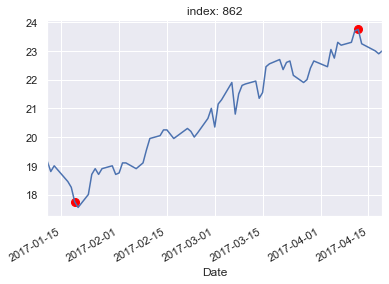

    buy_close= 19.95 buy_date= 2017-06-01 00:00:00 buy_id= 959
    sell_close= 21.65 sell_date= 2017-07-10 00:00:00 sell_id= 985
    gain= 1.6999999999999993 gain_pct=8.5%
    subset_slopes:
    min= -0.000767355952042692 max= 0.05305897870881893 mean= 0.03482014553709689 std= 0.01596484307932491
    days in trade= 26
    daily compounded return=0.31%
    buy_id= 954 sell_id= 990


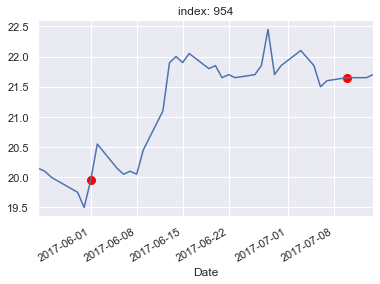

    buy_close= 19.65 buy_date= 2017-08-28 00:00:00 buy_id= 1020
    sell_close= 25.3 sell_date= 2017-12-29 00:00:00 sell_id= 1106
    gain= 5.650000000000002 gain_pct=28.8%
    subset_slopes:
    min= -0.002978712627598412 max= 0.07437905323606486 mean= 0.043691778536155634 std= 0.021266068080158664
    days in trade= 86
    daily compounded return=0.29%
    buy_id= 1015 sell_id= 1111


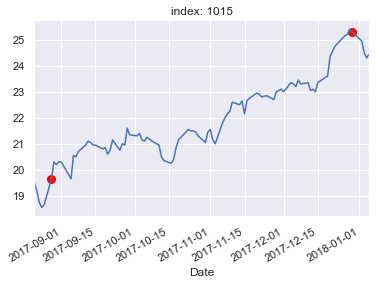

    buy_close= 17.7 buy_date= 2018-04-24 00:00:00 buy_id= 1184
    sell_close= 22.9 sell_date= 2018-08-21 00:00:00 sell_id= 1267
    gain= 5.199999999999999 gain_pct=29.4%
    subset_slopes:
    min= -0.0034677687081128283 max= 0.10158813300067493 mean= 0.04183882119498066 std= 0.029503424214350593
    days in trade= 83
    daily compounded return=0.31%
    buy_id= 1179 sell_id= 1272


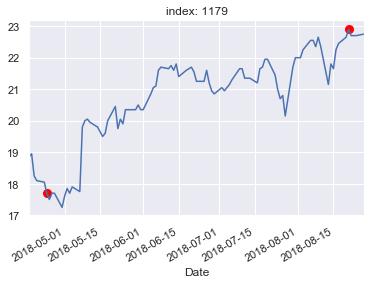

    buy_close= 15.06 buy_date= 2018-12-20 00:00:00 buy_id= 1351
    sell_close= 22.51 sell_date= 2019-05-14 00:00:00 sell_id= 1449
    gain= 7.450000000000001 gain_pct=49.5%
    subset_slopes:
    min= -0.00033892230813847846 max= 0.13604242804958488 mean= 0.05582210055886464 std= 0.03555810733941614
    days in trade= 98
    daily compounded return=0.41%
    buy_id= 1346 sell_id= 1454


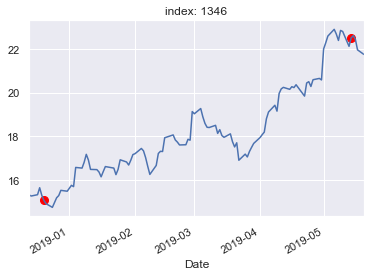

    buy_close= 20.79 buy_date= 2019-06-17 00:00:00 buy_id= 1472
    buy_id= 1467 sell_id= 1487


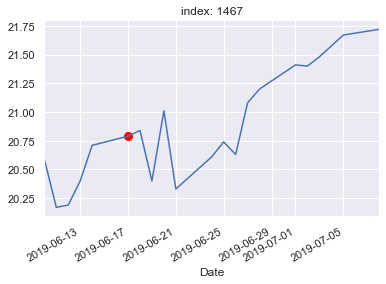


*******************
*** CVI        ***
*******************

    buy_close= 3.32 buy_date= 2010-07-01 00:00:00 buy_id= 92
    sell_close= 3.8 sell_date= 2010-08-04 00:00:00 sell_id= 115
    gain= 0.48 gain_pct=14.5%
    subset_slopes:
    min= -0.00010735360821723106 max= 0.0018565343664795897 mean= 0.0012921110598770663 std= 0.0005583465554121642
    days in trade= 23
    daily compounded return=0.59%
    buy_id= 87 sell_id= 120


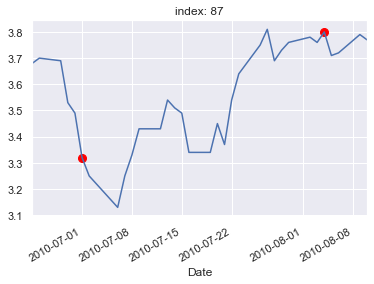

    buy_close= 3.36 buy_date= 2010-08-27 00:00:00 buy_id= 132
    sell_close= 10.27 sell_date= 2011-04-11 00:00:00 sell_id= 288
    gain= 6.91 gain_pct=205.7%
    subset_slopes:
    min= -0.0007290631591359009 max= 0.06465182173022832 mean= 0.043110930431885026 std= 0.015133100790297943
    days in trade= 156
    daily compounded return=0.72%
    buy_id= 127 sell_id= 293


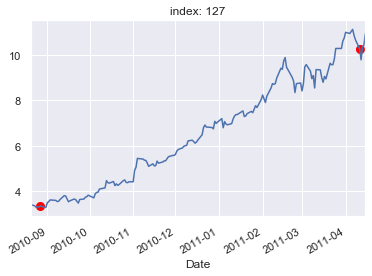

    buy_close= 9.27 buy_date= 2011-05-18 00:00:00 buy_id= 314
    sell_close= 12.75 sell_date= 2011-07-25 00:00:00 sell_id= 360
    gain= 3.4800000000000004 gain_pct=37.5%
    subset_slopes:
    min= -0.005023234928088982 max= 0.08327128716452492 mean= 0.04949838893614572 std= 0.027929094652169008
    days in trade= 46
    daily compounded return=0.69%
    buy_id= 309 sell_id= 365


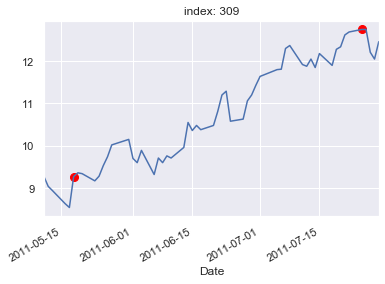

    buy_close= 11.89 buy_date= 2011-08-03 00:00:00 buy_id= 367
    sell_close= 12.58 sell_date= 2011-08-26 00:00:00 sell_id= 384
    gain= 0.6899999999999995 gain_pct=5.8%
    subset_slopes:
    min= -0.00038927735286797827 max= 0.011296244053653481 mean= 0.007144410617650574 std= 0.0036555503648053093
    days in trade= 17
    daily compounded return=0.33%
    buy_id= 362 sell_id= 389


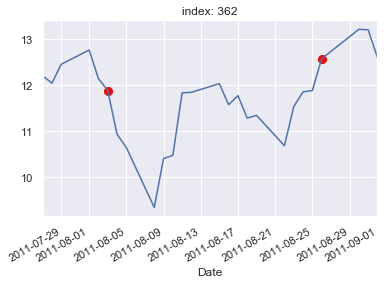

    buy_close= 11.24 buy_date= 2011-10-10 00:00:00 buy_id= 414
    sell_close= 12.54 sell_date= 2011-10-14 00:00:00 sell_id= 418
    gain= 1.299999999999999 gain_pct=11.6%
    subset_slopes:
    min= -0.0010804488849256444 max= 0.0013924123872381955 mean= 0.000528400194230727 std= 0.0009967180576639157
    days in trade= 4
    daily compounded return=2.78%
    buy_id= 409 sell_id= 423


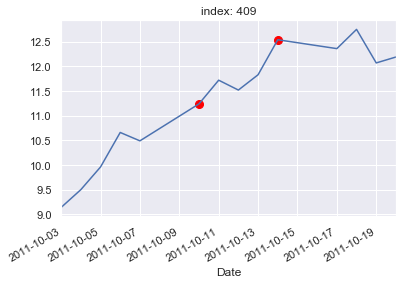

    buy_close= 8.82 buy_date= 2011-12-09 00:00:00 buy_id= 457
    sell_close= 12.86 sell_date= 2012-02-28 00:00:00 sell_id= 510
    gain= 4.039999999999999 gain_pct=45.8%
    subset_slopes:
    min= -0.009732798486888683 max= 0.12842046538697538 mean= 0.0764900699331348 std= 0.04143128042924589
    days in trade= 53
    daily compounded return=0.71%
    buy_id= 452 sell_id= 515


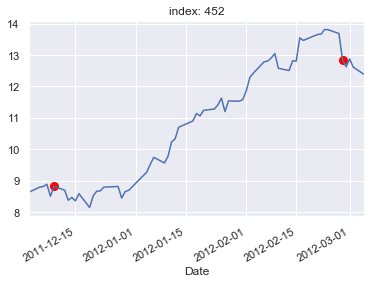

    buy_close= 12.56 buy_date= 2012-03-16 00:00:00 buy_id= 523
    sell_close= 14.0 sell_date= 2012-05-01 00:00:00 sell_id= 554
    gain= 1.4399999999999995 gain_pct=11.5%
    subset_slopes:
    min= -0.002366139160493219 max= 0.053927078269857986 mean= 0.033152474474059675 std= 0.017592618173512972
    days in trade= 31
    daily compounded return=0.35%
    buy_id= 518 sell_id= 559


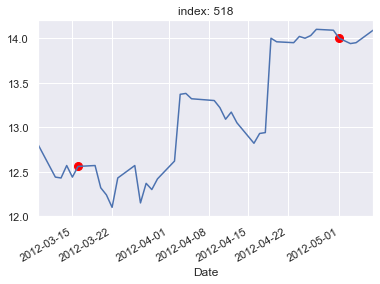

    buy_close= 11.33 buy_date= 2012-06-18 00:00:00 buy_id= 587
    sell_close= 28.77 sell_date= 2013-02-28 00:00:00 sell_id= 761
    gain= 17.439999999999998 gain_pct=153.9%
    subset_slopes:
    min= -0.0013672969454940898 max= 0.18625788182558267 mean= 0.09519477025294719 std= 0.05301284573676803
    days in trade= 174
    daily compounded return=0.54%
    buy_id= 582 sell_id= 766


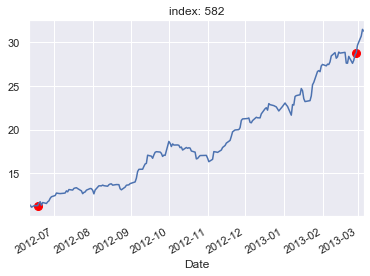

    buy_close= 25.24 buy_date= 2013-04-11 00:00:00 buy_id= 790
    sell_close= 35.77 sell_date= 2013-05-30 00:00:00 sell_id= 824
    gain= 10.530000000000005 gain_pct=41.7%
    subset_slopes:
    min= -0.011044284771692503 max= 0.3134105490872692 mean= 0.19599024011562557 std= 0.09860574906209885
    days in trade= 34
    daily compounded return=1.03%
    buy_id= 785 sell_id= 829


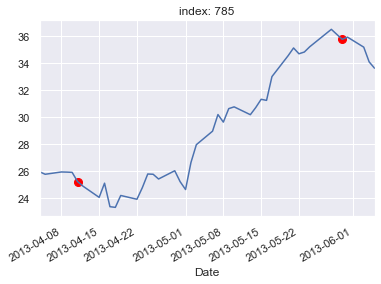

    buy_close= 22.06 buy_date= 2013-11-13 00:00:00 buy_id= 941
    sell_close= 25.78 sell_date= 2013-12-31 00:00:00 sell_id= 973
    gain= 3.7200000000000024 gain_pct=16.9%
    subset_slopes:
    min= -0.002018827143114521 max= 0.1066684077776543 mean= 0.06307688348286333 std= 0.034859451367499336
    days in trade= 32
    daily compounded return=0.49%
    buy_id= 936 sell_id= 978


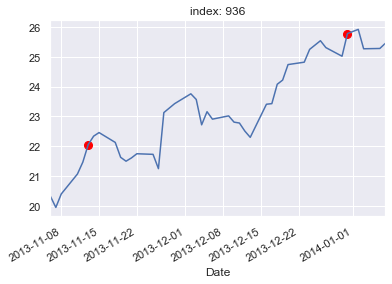

    buy_close= 21.41 buy_date= 2014-02-10 00:00:00 buy_id= 1000
    sell_close= 32.28 sell_date= 2014-08-28 00:00:00 sell_id= 1139
    gain= 10.870000000000001 gain_pct=50.8%
    subset_slopes:
    min= -0.006836186088285956 max= 0.15340196791203553 mean= 0.06166515857146682 std= 0.0439077151988279
    days in trade= 139
    daily compounded return=0.3%
    buy_id= 995 sell_id= 1144


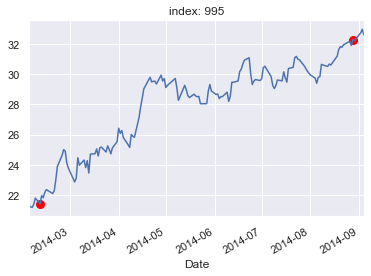

    buy_close= 27.25 buy_date= 2014-10-10 00:00:00 buy_id= 1169
    sell_close= 31.67 sell_date= 2014-11-12 00:00:00 sell_id= 1192
    gain= 4.420000000000002 gain_pct=16.2%
    subset_slopes:
    min= -0.0014160153542412957 max= 0.10982694293462103 mean= 0.07134466295566062 std= 0.03351379744620648
    days in trade= 23
    daily compounded return=0.65%
    buy_id= 1164 sell_id= 1197


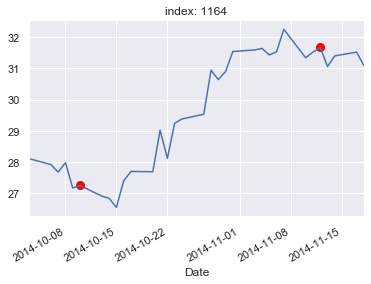

    buy_close= 22.69 buy_date= 2015-01-14 00:00:00 buy_id= 1234
    sell_close= 26.42 sell_date= 2015-04-09 00:00:00 sell_id= 1292
    gain= 3.7300000000000004 gain_pct=16.4%
    subset_slopes:
    min= -0.0039039387746448995 max= 0.09147689449714136 mean= 0.04001732405212015 std= 0.032103730075120636
    days in trade= 58
    daily compounded return=0.26%
    buy_id= 1229 sell_id= 1297


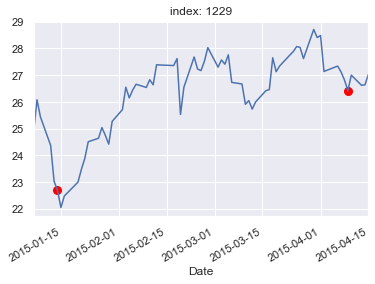

    buy_close= 25.78 buy_date= 2015-06-17 00:00:00 buy_id= 1340
    sell_close= 30.52 sell_date= 2015-11-18 00:00:00 sell_id= 1448
    gain= 4.739999999999998 gain_pct=18.4%
    subset_slopes:
    min= -0.0012557676453965883 max= 0.07875097280293275 mean= 0.044494498976061024 std= 0.023603997683356047
    days in trade= 108
    daily compounded return=0.16%
    buy_id= 1335 sell_id= 1453


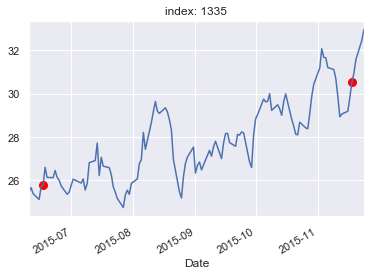

    buy_close= 17.8 buy_date= 2016-03-10 00:00:00 buy_id= 1524
    sell_close= 18.42 sell_date= 2016-03-30 00:00:00 sell_id= 1537
    gain= 0.620000000000001 gain_pct=3.5%
    subset_slopes:
    min= -0.004283131193950851 max= 0.025189097582888564 mean= 0.01617925090583774 std= 0.008699665408795194
    days in trade= 13
    daily compounded return=0.26%
    buy_id= 1519 sell_id= 1542


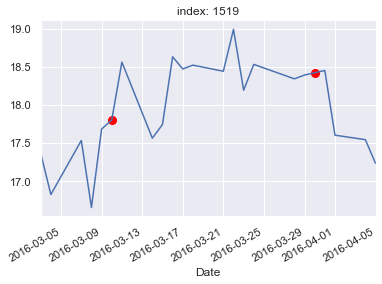

    buy_close= 10.68 buy_date= 2016-08-03 00:00:00 buy_id= 1625
    sell_close= 11.12 sell_date= 2016-09-22 00:00:00 sell_id= 1660
    gain= 0.4399999999999995 gain_pct=4.1%
    subset_slopes:
    min= -0.0027341415759778442 max= 0.027122516924185547 mean= 0.01573266961041208 std= 0.008366173516729783
    days in trade= 35
    daily compounded return=0.11%
    buy_id= 1620 sell_id= 1665


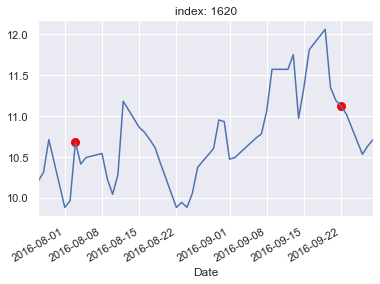

    buy_close= 10.75 buy_date= 2016-10-13 00:00:00 buy_id= 1675
    sell_close= 17.89 sell_date= 2017-01-11 00:00:00 sell_id= 1736
    gain= 7.140000000000001 gain_pct=66.4%
    subset_slopes:
    min= -0.003382778215900828 max= 0.21342688141390198 mean= 0.11885366253639745 std= 0.06854969683405192
    days in trade= 61
    daily compounded return=0.84%
    buy_id= 1670 sell_id= 1741


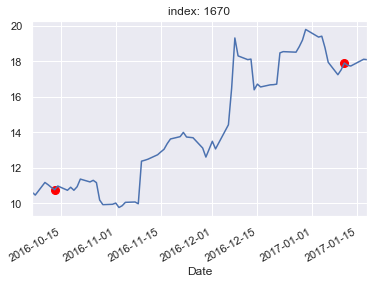

    buy_close= 14.66 buy_date= 2017-04-05 00:00:00 buy_id= 1794
    sell_close= 17.38 sell_date= 2017-05-19 00:00:00 sell_id= 1825
    gain= 2.719999999999999 gain_pct=18.6%
    subset_slopes:
    min= -0.0030105143810139623 max= 0.07771157371269766 mean= 0.05110537076407592 std= 0.02387524664170958
    days in trade= 31
    daily compounded return=0.55%
    buy_id= 1789 sell_id= 1830


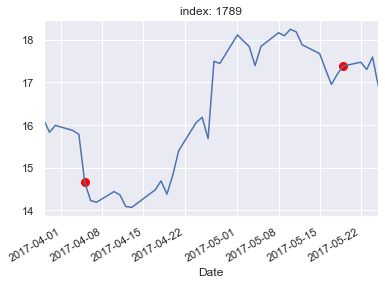

    buy_close= 16.62 buy_date= 2017-06-08 00:00:00 buy_id= 1838
    sell_close= 17.21 sell_date= 2017-07-06 00:00:00 sell_id= 1857
    gain= 0.5899999999999999 gain_pct=3.5%
    subset_slopes:
    min= -0.0031202885203391872 max= 0.034145241295298945 mean= 0.021046542244109196 std= 0.011337115137246957
    days in trade= 19
    daily compounded return=0.18%
    buy_id= 1833 sell_id= 1862


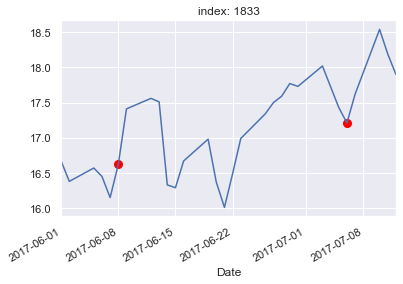

    buy_close= 14.81 buy_date= 2017-08-09 00:00:00 buy_id= 1881
    sell_close= 33.44 sell_date= 2018-01-09 00:00:00 sell_id= 1986
    gain= 18.629999999999995 gain_pct=125.8%
    subset_slopes:
    min= -0.0010145999743755851 max= 0.21744562873950102 mean= 0.1515617890821159 std= 0.0487205073295047
    days in trade= 105
    daily compounded return=0.78%
    buy_id= 1876 sell_id= 1991


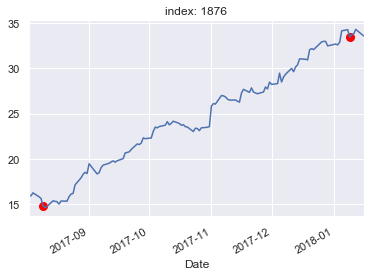

    buy_close= 26.51 buy_date= 2018-03-13 00:00:00 buy_id= 2029
    sell_close= 39.22 sell_date= 2018-05-25 00:00:00 sell_id= 2081
    gain= 12.709999999999997 gain_pct=47.9%
    subset_slopes:
    min= -0.011351231684884056 max= 0.31529707097588755 mean= 0.17771706804373272 std= 0.09940691185832233
    days in trade= 52
    daily compounded return=0.76%
    buy_id= 2024 sell_id= 2086


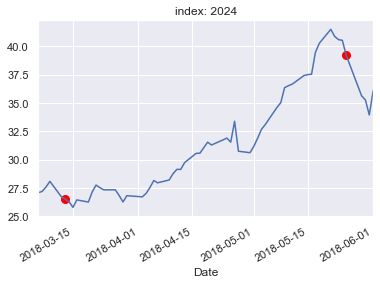

    buy_close= 33.69 buy_date= 2018-07-23 00:00:00 buy_id= 2120
    sell_close= 37.18 sell_date= 2018-10-25 00:00:00 sell_id= 2187
    gain= 3.490000000000002 gain_pct=10.4%
    subset_slopes:
    min= -0.0011473049068797536 max= 0.11262320001714698 mean= 0.04853239207172724 std= 0.03234919693781607
    days in trade= 67
    daily compounded return=0.15%
    buy_id= 2115 sell_id= 2192


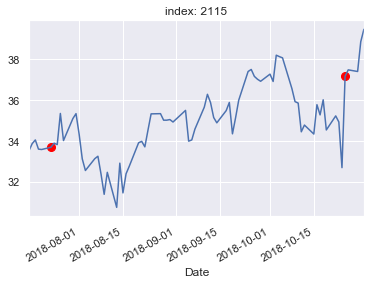

    buy_close= 28.48 buy_date= 2018-12-24 00:00:00 buy_id= 2227
    sell_close= 51.57 sell_date= 2019-07-17 00:00:00 sell_id= 2367
    gain= 23.09 gain_pct=81.1%
    subset_slopes:
    min= -0.0037062132727783137 max= 0.26662866761448356 mean= 0.1172779422376622 std= 0.06325655923443003
    days in trade= 140
    daily compounded return=0.43%
    buy_id= 2222 sell_id= 2372


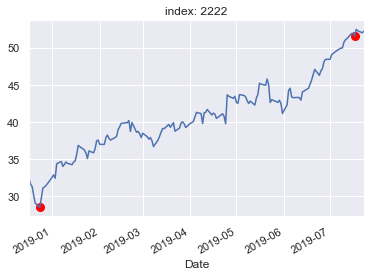

    buy_close= 41.29 buy_date= 2019-09-09 00:00:00 buy_id= 2404
    sell_close= 47.17 sell_date= 2019-11-07 00:00:00 sell_id= 2447
    gain= 5.880000000000003 gain_pct=14.2%
    subset_slopes:
    min= -0.009005454349534148 max= 0.12550732433667378 mean= 0.0919986585747424 std= 0.03663349941321302
    days in trade= 43
    daily compounded return=0.31%
    buy_id= 2399 sell_id= 2452


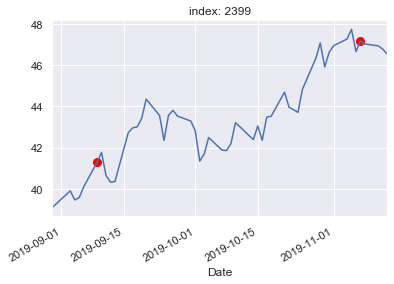


*******************
*** GGG        ***
*******************

    buy_close= 6.32 buy_date= 2010-06-25 00:00:00 buy_id= 88
    sell_close= 6.75 sell_date= 2010-07-29 00:00:00 sell_id= 111
    gain= 0.4299999999999997 gain_pct=6.8%
    subset_slopes:
    min= -0.00028318669248328376 max= 0.011798089804467615 mean= 0.007708732746238574 std= 0.0036632866361512527
    days in trade= 23
    daily compounded return=0.29%
    buy_id= 83 sell_id= 116


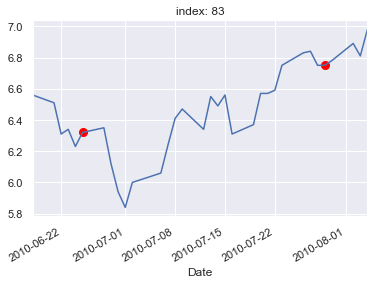

    buy_close= 6.18 buy_date= 2010-09-01 00:00:00 buy_id= 135
    sell_close= 11.33 sell_date= 2011-06-29 00:00:00 sell_id= 343
    gain= 5.15 gain_pct=83.3%
    subset_slopes:
    min= -0.00013047861870596478 max= 0.04790062547879259 mean= 0.02387785033034128 std= 0.012607908949490291
    days in trade= 208
    daily compounded return=0.29%
    buy_id= 130 sell_id= 348


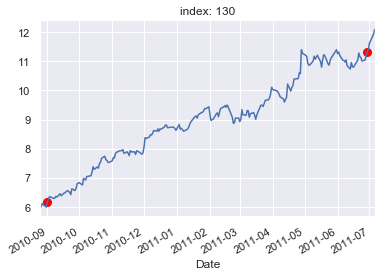

    buy_close= 8.61 buy_date= 2011-09-19 00:00:00 buy_id= 399
    sell_close= 10.1 sell_date= 2011-11-15 00:00:00 sell_id= 440
    gain= 1.4900000000000002 gain_pct=17.3%
    subset_slopes:
    min= -0.0011507941763753138 max= 0.06025072307182988 mean= 0.03487904461256511 std= 0.019586387676623847
    days in trade= 41
    daily compounded return=0.39%
    buy_id= 394 sell_id= 445


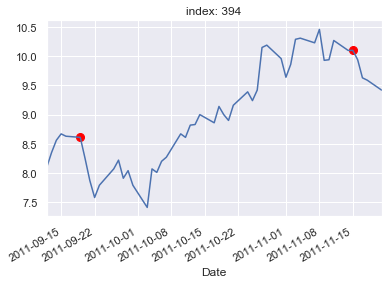

    buy_close= 8.8 buy_date= 2011-12-15 00:00:00 buy_id= 461
    sell_close= 13.13 sell_date= 2012-04-19 00:00:00 sell_id= 546
    gain= 4.33 gain_pct=49.2%
    subset_slopes:
    min= -0.0026229704067315396 max= 0.0745286676996173 mean= 0.03805325266879665 std= 0.02163694581838535
    days in trade= 85
    daily compounded return=0.47%
    buy_id= 456 sell_id= 551


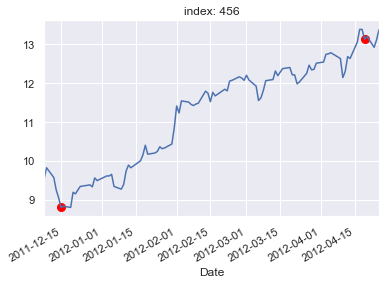

    buy_close= 10.51 buy_date= 2012-07-10 00:00:00 buy_id= 602
    sell_close= 12.5 sell_date= 2012-09-11 00:00:00 sell_id= 646
    gain= 1.9900000000000002 gain_pct=18.9%
    subset_slopes:
    min= -0.002444344823263833 max= 0.05304352784648714 mean= 0.033398931261070804 std= 0.017025606804926874
    days in trade= 44
    daily compounded return=0.39%
    buy_id= 597 sell_id= 651


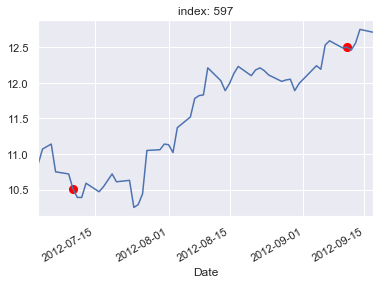

    buy_close= 11.62 buy_date= 2012-10-26 00:00:00 buy_id= 679
    sell_close= 14.4 sell_date= 2013-03-04 00:00:00 sell_id= 763
    gain= 2.780000000000001 gain_pct=23.9%
    subset_slopes:
    min= -0.0018369907392816742 max= 0.05197944749212979 mean= 0.032385551610231655 std= 0.014777262524728727
    days in trade= 84
    daily compounded return=0.26%
    buy_id= 674 sell_id= 768


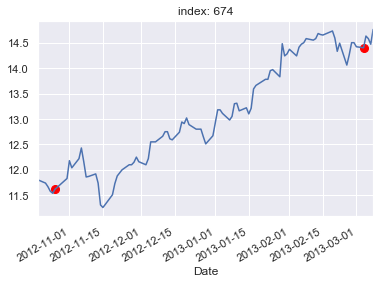

    buy_close= 14.11 buy_date= 2013-04-03 00:00:00 buy_id= 784
    sell_close= 20.02 sell_date= 2013-11-12 00:00:00 sell_id= 940
    gain= 5.91 gain_pct=41.9%
    subset_slopes:
    min= -0.0009014051357603137 max= 0.07570903434978504 mean= 0.035628672469814084 std= 0.01847313445193764
    days in trade= 156
    daily compounded return=0.22%
    buy_id= 779 sell_id= 945


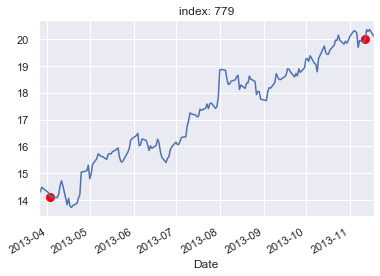

    buy_close= 19.29 buy_date= 2013-12-11 00:00:00 buy_id= 960
    sell_close= 19.9 sell_date= 2013-12-24 00:00:00 sell_id= 969
    gain= 0.6099999999999994 gain_pct=3.2%
    subset_slopes:
    min= -0.000998338955483291 max= 0.003528838655764588 mean= 0.002097277827315638 std= 0.0014759694911748468
    days in trade= 9
    daily compounded return=0.35%
    buy_id= 955 sell_id= 974


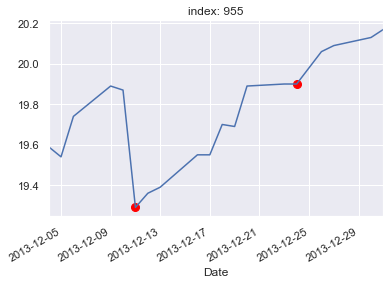

    buy_close= 18.32 buy_date= 2014-01-31 00:00:00 buy_id= 994
    sell_close= 20.05 sell_date= 2014-03-12 00:00:00 sell_id= 1021
    gain= 1.7300000000000004 gain_pct=9.4%
    subset_slopes:
    min= -0.0002858179192450905 max= 0.031220091279635653 mean= 0.019284879596170736 std= 0.00964298359455569
    days in trade= 27
    daily compounded return=0.33%
    buy_id= 989 sell_id= 1026


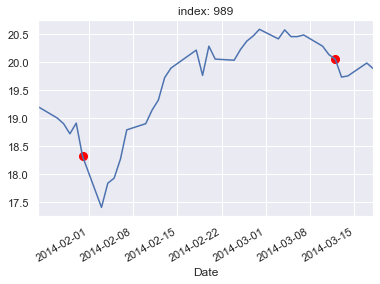

    buy_close= 19.64 buy_date= 2014-05-05 00:00:00 buy_id= 1058
    sell_close= 20.79 sell_date= 2014-07-09 00:00:00 sell_id= 1103
    gain= 1.1499999999999986 gain_pct=5.9%
    subset_slopes:
    min= -0.0005964781920262396 max= 0.040454147430679654 mean= 0.023098475722709427 std= 0.013038623460769255
    days in trade= 45
    daily compounded return=0.13%
    buy_id= 1053 sell_id= 1108


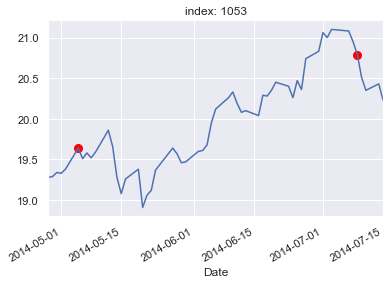

    buy_close= 20.64 buy_date= 2014-07-30 00:00:00 buy_id= 1118
    sell_close= 20.89 sell_date= 2014-08-26 00:00:00 sell_id= 1137
    gain= 0.25 gain_pct=1.2%
    subset_slopes:
    min= -0.0012096410712594263 max= 0.012004400472751087 mean= 0.007640933273257725 std= 0.003983372196408453
    days in trade= 19
    daily compounded return=0.06%
    buy_id= 1113 sell_id= 1142


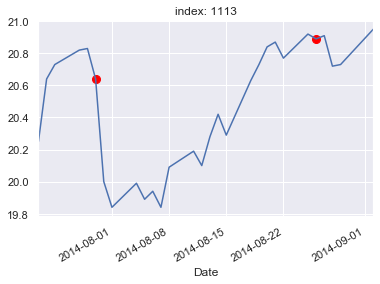

    buy_close= 19.35 buy_date= 2014-10-03 00:00:00 buy_id= 1164
    sell_close= 21.42 sell_date= 2014-12-10 00:00:00 sell_id= 1211
    gain= 2.0700000000000003 gain_pct=10.7%
    subset_slopes:
    min= -0.0019884517433119697 max= 0.0795548158145607 mean= 0.040619141526702575 std= 0.027574020723432405
    days in trade= 47
    daily compounded return=0.22%
    buy_id= 1159 sell_id= 1216


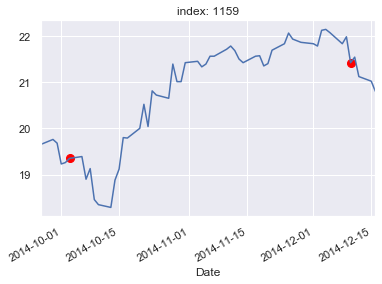

    buy_close= 19.6 buy_date= 2015-04-09 00:00:00 buy_id= 1292
    sell_close= 20.57 sell_date= 2015-05-22 00:00:00 sell_id= 1323
    gain= 0.9699999999999989 gain_pct=4.9%
    subset_slopes:
    min= -0.00024256550980084057 max= 0.022467296871198528 mean= 0.014140814635708918 std= 0.006898726019588112
    days in trade= 31
    daily compounded return=0.15%
    buy_id= 1287 sell_id= 1328


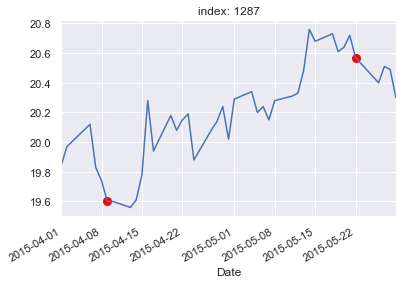

    buy_close= 19.45 buy_date= 2015-07-14 00:00:00 buy_id= 1358
    sell_close= 20.38 sell_date= 2015-08-05 00:00:00 sell_id= 1374
    gain= 0.9299999999999997 gain_pct=4.8%
    subset_slopes:
    min= -0.00016394276769204907 max= 0.007498729267119586 mean= 0.004775308490167829 std= 0.0023036344298530825
    days in trade= 16
    daily compounded return=0.29%
    buy_id= 1353 sell_id= 1379


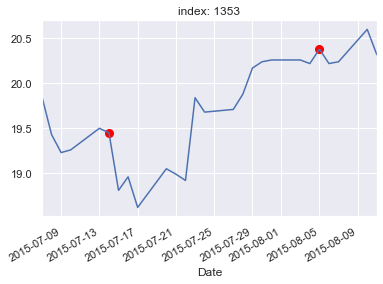

    buy_close= 19.47 buy_date= 2015-09-14 00:00:00 buy_id= 1401
    sell_close= 20.72 sell_date= 2015-11-16 00:00:00 sell_id= 1446
    gain= 1.25 gain_pct=6.4%
    subset_slopes:
    min= -0.0009569059591676421 max= 0.0615365005056816 mean= 0.038326805984175 std= 0.018533335454056655
    days in trade= 45
    daily compounded return=0.14%
    buy_id= 1396 sell_id= 1451


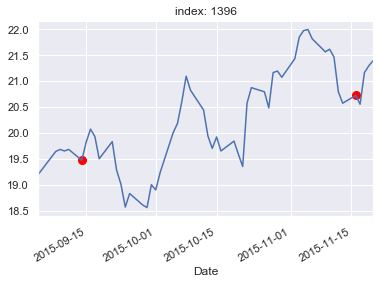

    buy_close= 19.06 buy_date= 2016-01-11 00:00:00 buy_id= 1483
    sell_close= 24.08 sell_date= 2016-04-05 00:00:00 sell_id= 1541
    gain= 5.02 gain_pct=26.3%
    subset_slopes:
    min= -0.003239350498503768 max= 0.12932716415383894 mean= 0.07394587256256493 std= 0.04055365052186081
    days in trade= 58
    daily compounded return=0.4%
    buy_id= 1478 sell_id= 1546


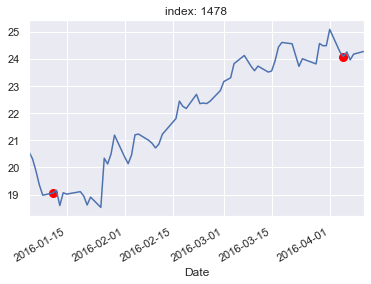

    buy_close= 23.0 buy_date= 2016-05-19 00:00:00 buy_id= 1573
    sell_close= 23.68 sell_date= 2016-05-31 00:00:00 sell_id= 1580
    gain= 0.6799999999999997 gain_pct=3.0%
    subset_slopes:
    min= -0.001093342195780167 max= 0.0015271777696810318 mean= 0.0007331656264116962 std= 0.0008702463042693291
    days in trade= 7
    daily compounded return=0.42%
    buy_id= 1568 sell_id= 1585


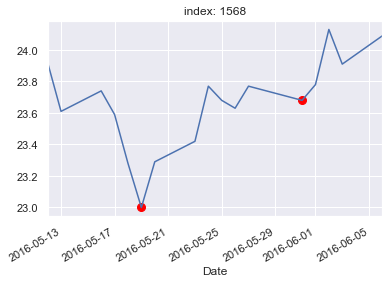

    buy_close= 21.89 buy_date= 2016-09-27 00:00:00 buy_id= 1663
    sell_close= 35.57 sell_date= 2017-06-07 00:00:00 sell_id= 1837
    gain= 13.68 gain_pct=62.5%
    subset_slopes:
    min= -0.001725089103064903 max= 0.19563259703163993 mean= 0.07691544257727592 std= 0.04886763967433838
    days in trade= 174
    daily compounded return=0.28%
    buy_id= 1658 sell_id= 1842


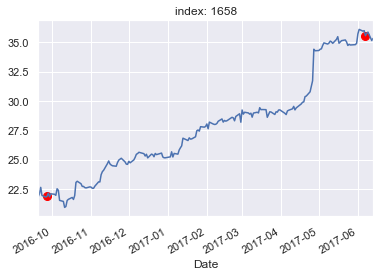

    buy_close= 34.84 buy_date= 2017-07-03 00:00:00 buy_id= 1855
    sell_close= 45.28 sell_date= 2018-01-16 00:00:00 sell_id= 1990
    gain= 10.439999999999998 gain_pct=30.0%
    subset_slopes:
    min= -0.0016336674960015785 max= 0.13111828564914418 mean= 0.07274458568604664 std= 0.037155475700683394
    days in trade= 135
    daily compounded return=0.19%
    buy_id= 1850 sell_id= 1995


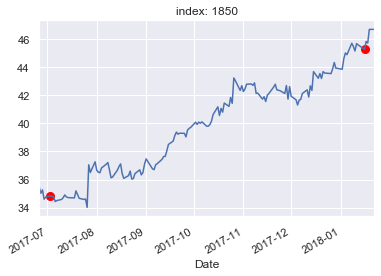

    buy_close= 43.85 buy_date= 2018-02-23 00:00:00 buy_id= 2017
    sell_close= 43.61 sell_date= 2018-04-02 00:00:00 sell_id= 2042
    gain= -0.240000000000002 gain_pct=-0.5%
    subset_slopes:
    min= -0.0004472351258471008 max= 0.061289895767409064 mean= 0.03859949875909706 std= 0.018906728468647
    days in trade= 25
    daily compounded return=-0.02%
    buy_id= 2012 sell_id= 2047


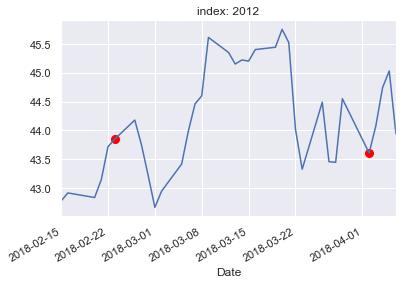

    buy_close= 45.84 buy_date= 2018-04-20 00:00:00 buy_id= 2056
    sell_close= 45.5 sell_date= 2018-06-05 00:00:00 sell_id= 2087
    gain= -0.3400000000000034 gain_pct=-0.7%
    subset_slopes:
    min= -0.0006334687138362938 max= 0.034277121940760935 mean= 0.020726194292635572 std= 0.010409927416704032
    days in trade= 31
    daily compounded return=-0.02%
    buy_id= 2051 sell_id= 2092


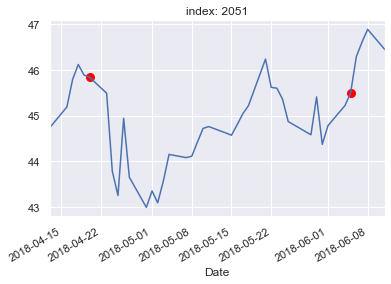

    buy_close= 44.01 buy_date= 2018-06-28 00:00:00 buy_id= 2104
    sell_close= 46.08 sell_date= 2018-08-31 00:00:00 sell_id= 2149
    gain= 2.0700000000000003 gain_pct=4.7%
    subset_slopes:
    min= -4.520312174349783e-06 max= 0.03550618483176038 mean= 0.02255155764408193 std= 0.00882981033968949
    days in trade= 45
    daily compounded return=0.1%
    buy_id= 2099 sell_id= 2154


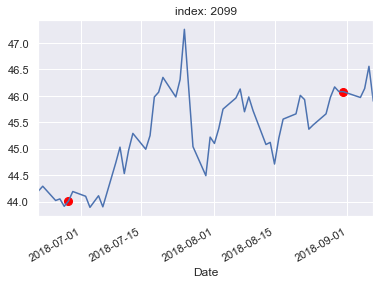

    buy_close= 38.95 buy_date= 2018-10-29 00:00:00 buy_id= 2189
    sell_close= 42.46 sell_date= 2018-11-26 00:00:00 sell_id= 2208
    gain= 3.509999999999998 gain_pct=9.0%
    subset_slopes:
    min= -0.004414398858124002 max= 0.08143426335048076 mean= 0.05236682924994235 std= 0.025420149995283286
    days in trade= 19
    daily compounded return=0.45%
    buy_id= 2184 sell_id= 2213


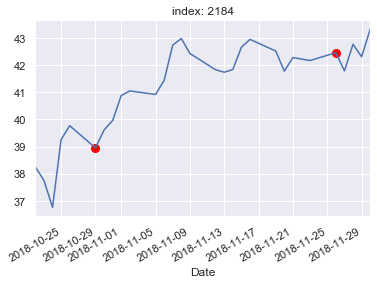

    buy_close= 40.61 buy_date= 2018-12-27 00:00:00 buy_id= 2229
    sell_close= 52.48 sell_date= 2019-04-22 00:00:00 sell_id= 2307
    gain= 11.869999999999997 gain_pct=29.2%
    subset_slopes:
    min= -0.0062980078708250176 max= 0.1653712344758489 mean= 0.1258825945683506 std= 0.04790179325644651
    days in trade= 78
    daily compounded return=0.33%
    buy_id= 2224 sell_id= 2312


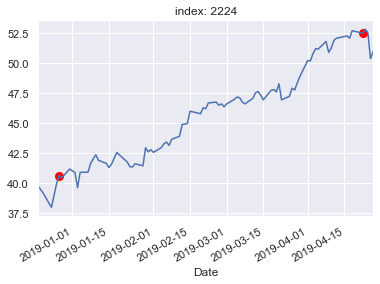

    buy_close= 46.75 buy_date= 2019-05-31 00:00:00 buy_id= 2335
    sell_close= 50.28 sell_date= 2019-07-02 00:00:00 sell_id= 2357
    gain= 3.530000000000001 gain_pct=7.6%
    subset_slopes:
    min= -0.00798313464932221 max= 0.0701481788326177 mean= 0.043699387261534835 std= 0.02324316529207816
    days in trade= 22
    daily compounded return=0.33%
    buy_id= 2330 sell_id= 2362


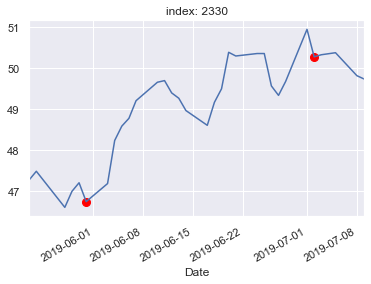

    buy_close= 44.88 buy_date= 2019-09-24 00:00:00 buy_id= 2415
    buy_id= 2410 sell_id= 2430


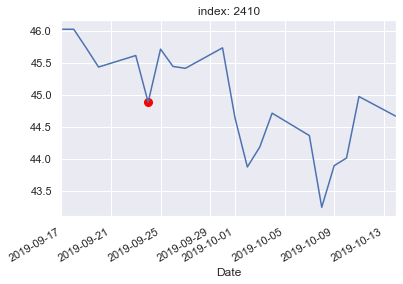


*******************
*** GURE        ***
*******************

    buy_close= 45.95 buy_date= 2010-07-27 00:00:00 buy_id= 109
    sell_close= 46.1 sell_date= 2010-08-04 00:00:00 sell_id= 115
    gain= 0.14999999999999858 gain_pct=0.3%
    subset_slopes:
    min= -0.0036041462264861934 max= 0.006965506564796442 mean= 0.003574654084854245 std= 0.0037079747439331856
    days in trade= 6
    daily compounded return=0.05%
    buy_id= 104 sell_id= 120


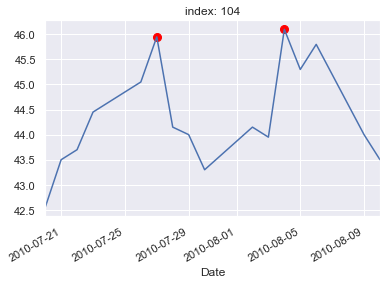

    buy_close= 32.55 buy_date= 2010-09-24 00:00:00 buy_id= 151
    sell_close= 55.65 sell_date= 2010-12-14 00:00:00 sell_id= 207
    gain= 23.1 gain_pct=71.0%
    subset_slopes:
    min= -0.006785590506623862 max= 0.374617001974471 mean= 0.2456813836770094 std= 0.11917233151142209
    days in trade= 56
    daily compounded return=0.96%
    buy_id= 146 sell_id= 212


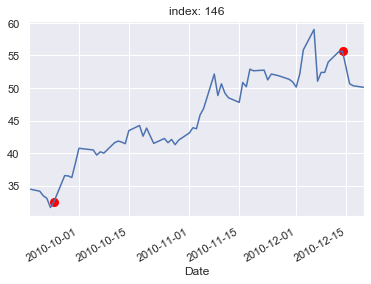

    buy_close= 13.5 buy_date= 2011-06-17 00:00:00 buy_id= 335
    sell_close= 18.25 sell_date= 2011-07-14 00:00:00 sell_id= 353
    gain= 4.75 gain_pct=35.2%
    subset_slopes:
    min= -0.003745446435187816 max= 0.06905089247421259 mean= 0.04300554399617557 std= 0.022655056646128855
    days in trade= 18
    daily compounded return=1.69%
    buy_id= 330 sell_id= 358


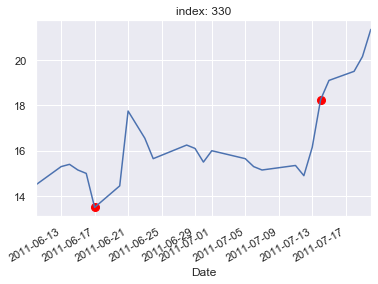

    buy_close= 9.95 buy_date= 2011-09-07 00:00:00 buy_id= 391
    sell_close= 10.45 sell_date= 2011-10-05 00:00:00 sell_id= 411
    gain= 0.5 gain_pct=5.0%
    subset_slopes:
    min= -0.0065192536685234614 max= 0.047433785952893714 mean= 0.029390929252422992 std= 0.015677129305248932
    days in trade= 20
    daily compounded return=0.24%
    buy_id= 386 sell_id= 416


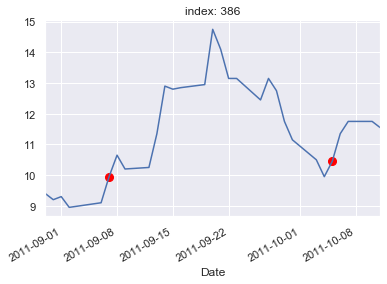

    buy_close= 9.7 buy_date= 2011-12-19 00:00:00 buy_id= 463
    sell_close= 15.65 sell_date= 2012-02-22 00:00:00 sell_id= 506
    gain= 5.950000000000001 gain_pct=61.3%
    subset_slopes:
    min= -0.004669420210616337 max= 0.1505448578771862 mean= 0.09271339053572451 std= 0.04829557381108144
    days in trade= 43
    daily compounded return=1.12%
    buy_id= 458 sell_id= 511


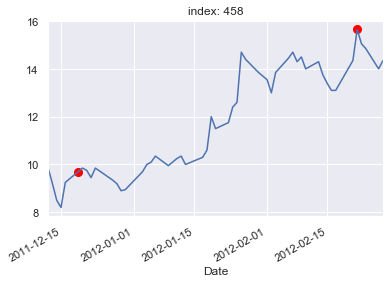

    buy_close= 5.2 buy_date= 2012-08-07 00:00:00 buy_id= 622
    sell_close= 6.0 sell_date= 2012-09-12 00:00:00 sell_id= 647
    gain= 0.7999999999999998 gain_pct=15.4%
    subset_slopes:
    min= -0.0009301496108076179 max= 0.02262096273944003 mean= 0.01329920232067277 std= 0.0074196517995601145
    days in trade= 25
    daily compounded return=0.57%
    buy_id= 617 sell_id= 652


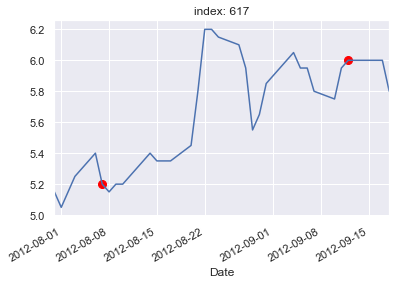

    buy_close= 5.8 buy_date= 2012-09-18 00:00:00 buy_id= 651
    sell_close= 6.65 sell_date= 2012-11-08 00:00:00 sell_id= 686
    gain= 0.8500000000000005 gain_pct=14.7%
    subset_slopes:
    min= -0.0004711738825742273 max= 0.033910060199818126 mean= 0.021312638403691103 std= 0.011029968697030946
    days in trade= 35
    daily compounded return=0.39%
    buy_id= 646 sell_id= 691


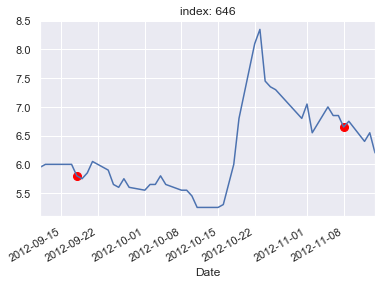

    buy_close= 5.15 buy_date= 2013-04-23 00:00:00 buy_id= 798
    sell_close= 13.75 sell_date= 2013-12-03 00:00:00 sell_id= 954
    gain= 8.6 gain_pct=167.0%
    subset_slopes:
    min= -0.0010282100763330249 max= 0.1082862685456778 mean= 0.046119769196389486 std= 0.03434141278025112
    days in trade= 156
    daily compounded return=0.63%
    buy_id= 793 sell_id= 959


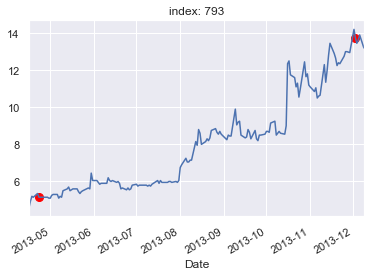

    buy_close= 10.9 buy_date= 2014-01-24 00:00:00 buy_id= 989
    sell_close= 13.0 sell_date= 2014-03-14 00:00:00 sell_id= 1023
    gain= 2.0999999999999996 gain_pct=19.3%
    subset_slopes:
    min= -8.158641492528318e-05 max= 0.057968391922685214 mean= 0.03364341016719868 std= 0.0184931528488913
    days in trade= 34
    daily compounded return=0.52%
    buy_id= 984 sell_id= 1028


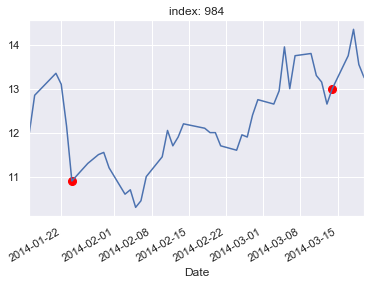

    buy_close= 10.15 buy_date= 2014-05-15 00:00:00 buy_id= 1066
    sell_close= 9.9 sell_date= 2014-06-13 00:00:00 sell_id= 1086
    gain= -0.25 gain_pct=-2.5%
    subset_slopes:
    min= -0.00224882109775848 max= 0.013090883988645885 mean= 0.007725819304344661 std= 0.004487719379034096
    days in trade= 20
    daily compounded return=-0.13%
    buy_id= 1061 sell_id= 1091


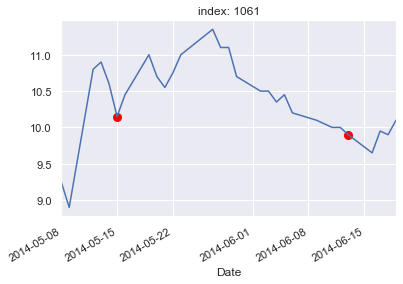

    buy_close= 10.8 buy_date= 2014-06-25 00:00:00 buy_id= 1094
    sell_close= 9.9 sell_date= 2014-07-08 00:00:00 sell_id= 1102
    gain= -0.9000000000000004 gain_pct=-8.3%
    subset_slopes:
    min= -0.000541056326104794 max= 0.00152601511674888 mean= 0.0008212505377096502 std= 0.0006878445631035695
    days in trade= 8
    daily compounded return=-1.08%
    buy_id= 1089 sell_id= 1107


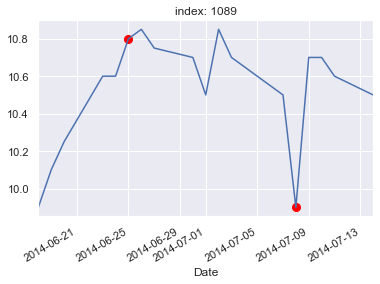

    buy_close= 5.2 buy_date= 2014-12-16 00:00:00 buy_id= 1215
    sell_close= 12.5 sell_date= 2015-05-12 00:00:00 sell_id= 1315
    gain= 7.3 gain_pct=140.4%
    subset_slopes:
    min= -0.002355178170781791 max= 0.15028563809612194 mean= 0.0670931104767104 std= 0.04563790088208526
    days in trade= 100
    daily compounded return=0.88%
    buy_id= 1210 sell_id= 1320


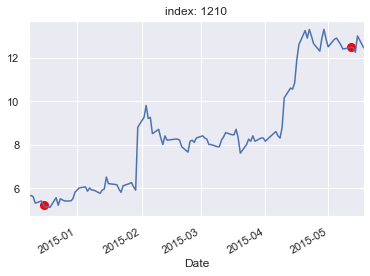

    buy_close= 7.45 buy_date= 2015-09-21 00:00:00 buy_id= 1406
    sell_close= 9.4 sell_date= 2015-11-10 00:00:00 sell_id= 1442
    gain= 1.9500000000000002 gain_pct=26.2%
    subset_slopes:
    min= -0.0025787071112013393 max= 0.05613837376319886 mean= 0.034507755627460716 std= 0.01780535590934902
    days in trade= 36
    daily compounded return=0.65%
    buy_id= 1401 sell_id= 1447


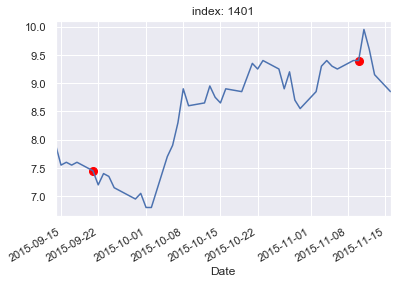

    buy_close= 7.2 buy_date= 2016-01-28 00:00:00 buy_id= 1495
    sell_close= 9.05 sell_date= 2016-03-10 00:00:00 sell_id= 1524
    gain= 1.8500000000000005 gain_pct=25.7%
    subset_slopes:
    min= -0.0015755207328158605 max= 0.05678350737313842 mean= 0.03557548184244713 std= 0.017591774922237027
    days in trade= 29
    daily compounded return=0.79%
    buy_id= 1490 sell_id= 1529


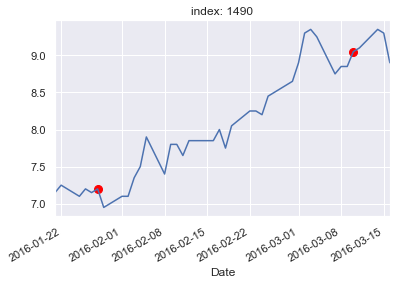

    buy_close= 7.25 buy_date= 2016-05-06 00:00:00 buy_id= 1564
    sell_close= 8.0 sell_date= 2016-06-22 00:00:00 sell_id= 1596
    gain= 0.75 gain_pct=10.3%
    subset_slopes:
    min= -0.0010977065098547456 max= 0.01779305440489143 mean= 0.009870093042871425 std= 0.006125487570946553
    days in trade= 32
    daily compounded return=0.31%
    buy_id= 1559 sell_id= 1601


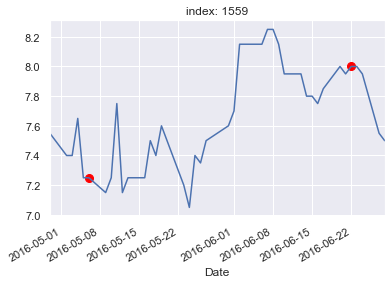

    buy_close= 8.0 buy_date= 2016-06-23 00:00:00 buy_id= 1597
    sell_close= 11.4 sell_date= 2016-11-22 00:00:00 sell_id= 1703
    gain= 3.4000000000000004 gain_pct=42.5%
    subset_slopes:
    min= -5.312064681906037e-05 max= 0.07424723999966787 mean= 0.032654991832090426 std= 0.021020154061791776
    days in trade= 106
    daily compounded return=0.33%
    buy_id= 1592 sell_id= 1708


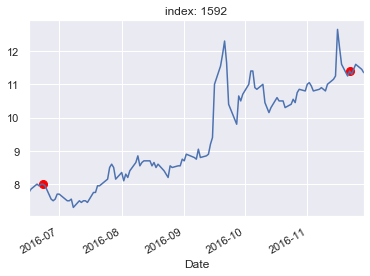

    buy_close= 9.1 buy_date= 2017-04-12 00:00:00 buy_id= 1799
    sell_close= 9.5 sell_date= 2017-05-05 00:00:00 sell_id= 1815
    gain= 0.40000000000000036 gain_pct=4.4%
    subset_slopes:
    min= -0.0020733108161810065 max= 0.009626308020585839 mean= 0.005888431225463009 std= 0.003445874991497127
    days in trade= 16
    daily compounded return=0.27%
    buy_id= 1794 sell_id= 1820


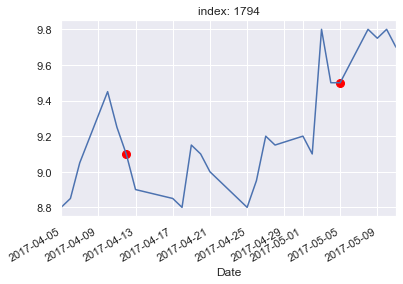

    buy_close= 8.0 buy_date= 2017-06-28 00:00:00 buy_id= 1852
    sell_close= 8.9 sell_date= 2017-09-25 00:00:00 sell_id= 1913
    gain= 0.9000000000000004 gain_pct=11.3%
    subset_slopes:
    min= -0.0026761914448840685 max= 0.026730195581107452 mean= 0.01399758373820111 std= 0.008364456363957728
    days in trade= 61
    daily compounded return=0.18%
    buy_id= 1847 sell_id= 1918


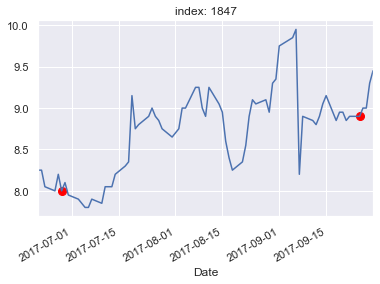

    buy_close= 7.25 buy_date= 2017-12-18 00:00:00 buy_id= 1972
    sell_close= 7.6 sell_date= 2018-01-23 00:00:00 sell_id= 1995
    gain= 0.34999999999999964 gain_pct=4.8%
    subset_slopes:
    min= -0.00021003413765097179 max= 0.006432021576805447 mean= 0.0038879931695115235 std= 0.0020738311337629807
    days in trade= 23
    daily compounded return=0.2%
    buy_id= 1967 sell_id= 2000


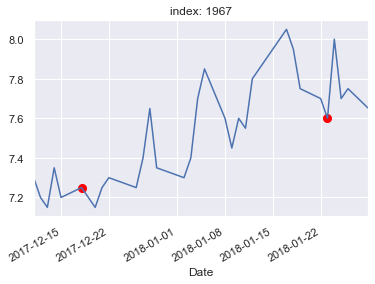

    buy_close= 7.1 buy_date= 2018-05-09 00:00:00 buy_id= 2069
    sell_close= 7.15 sell_date= 2018-05-31 00:00:00 sell_id= 2084
    gain= 0.05000000000000071 gain_pct=0.7%
    subset_slopes:
    min= -0.0005044861781273724 max= 0.0034473794820453207 mean= 0.0020802359722822553 std= 0.0012200172445159627
    days in trade= 15
    daily compounded return=0.05%
    buy_id= 2064 sell_id= 2089


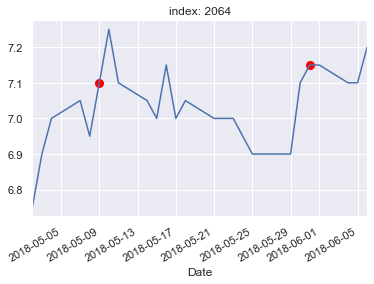

    buy_close= 3.75 buy_date= 2018-12-17 00:00:00 buy_id= 2222
    sell_close= 5.75 sell_date= 2019-02-13 00:00:00 sell_id= 2261
    gain= 2.0 gain_pct=53.3%
    subset_slopes:
    min= -0.0004218636725088487 max= 0.06297084923337781 mean= 0.03742248268059921 std= 0.020165731896966667
    days in trade= 39
    daily compounded return=1.1%
    buy_id= 2217 sell_id= 2266


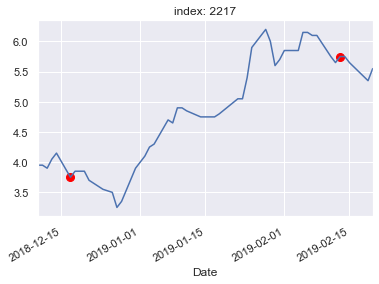

    buy_close= 5.25 buy_date= 2019-03-08 00:00:00 buy_id= 2277
    sell_close= 6.75 sell_date= 2019-04-25 00:00:00 sell_id= 2310
    gain= 1.5 gain_pct=28.6%
    subset_slopes:
    min= -0.002682037378882285 max= 0.04559023064840684 mean= 0.029141595068508167 std= 0.014347554621176737
    days in trade= 33
    daily compounded return=0.77%
    buy_id= 2272 sell_id= 2315


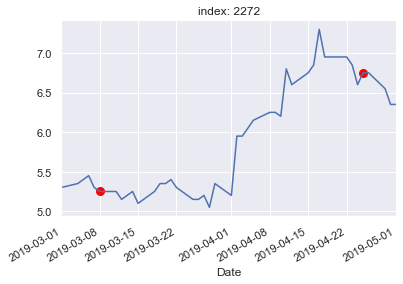

    buy_close= 2.6 buy_date= 2019-12-13 00:00:00 buy_id= 2472
    buy_id= 2467 sell_id= 2487


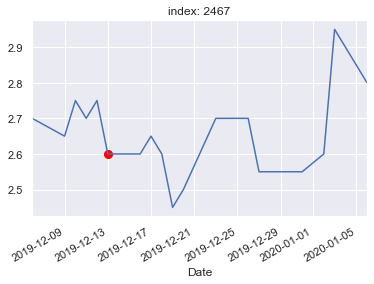


*******************
*** HWC        ***
*******************

    buy_close= 20.82 buy_date= 2010-08-30 00:00:00 buy_id= 133
    sell_close= 26.17 sell_date= 2010-12-28 00:00:00 sell_id= 216
    gain= 5.350000000000001 gain_pct=25.7%
    subset_slopes:
    min= -6.836589102121593e-05 max= 0.08413758340702415 mean= 0.05320905950240545 std= 0.019348698112278535
    days in trade= 83
    daily compounded return=0.28%
    buy_id= 128 sell_id= 221


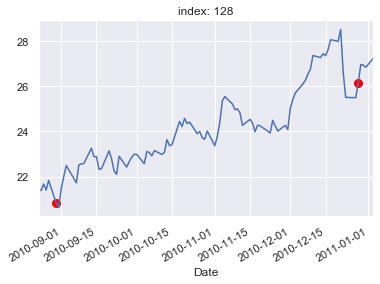

    buy_close= 24.1 buy_date= 2011-06-24 00:00:00 buy_id= 340
    sell_close= 24.28 sell_date= 2011-07-08 00:00:00 sell_id= 349
    gain= 0.17999999999999972 gain_pct=0.7%
    subset_slopes:
    min= -0.0010381892970059425 max= 0.007390566677262456 mean= 0.004544267422438963 std= 0.002777474457586458
    days in trade= 9
    daily compounded return=0.08%
    buy_id= 335 sell_id= 354


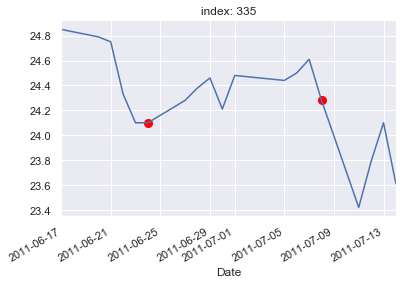

    buy_close= 23.19 buy_date= 2011-09-15 00:00:00 buy_id= 397
    sell_close= 24.04 sell_date= 2011-11-04 00:00:00 sell_id= 433
    gain= 0.8499999999999979 gain_pct=3.7%
    subset_slopes:
    min= -0.0038261480677164172 max= 0.07108208423971973 mean= 0.04215298823924672 std= 0.023130841666715012
    days in trade= 36
    daily compounded return=0.1%
    buy_id= 392 sell_id= 438


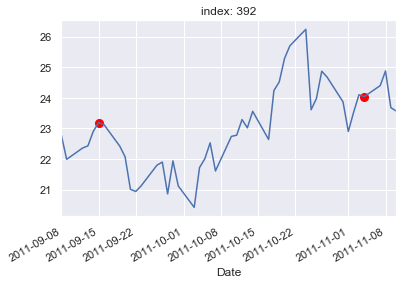

    buy_close= 23.6 buy_date= 2011-11-18 00:00:00 buy_id= 443
    sell_close= 28.68 sell_date= 2012-03-29 00:00:00 sell_id= 532
    gain= 5.079999999999998 gain_pct=21.5%
    subset_slopes:
    min= -0.0014263909092164795 max= 0.11314062553055493 mean= 0.05016322430723024 std= 0.032522084215897244
    days in trade= 89
    daily compounded return=0.22%
    buy_id= 438 sell_id= 537


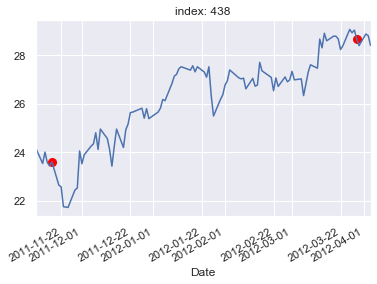

    buy_close= 23.53 buy_date= 2012-06-08 00:00:00 buy_id= 581
    sell_close= 23.63 sell_date= 2012-07-24 00:00:00 sell_id= 612
    gain= 0.09999999999999787 gain_pct=0.4%
    subset_slopes:
    min= -0.0010437893173964596 max= 0.03604337723783857 mean= 0.022740540007390793 std= 0.01099446337671616
    days in trade= 31
    daily compounded return=0.01%
    buy_id= 576 sell_id= 617


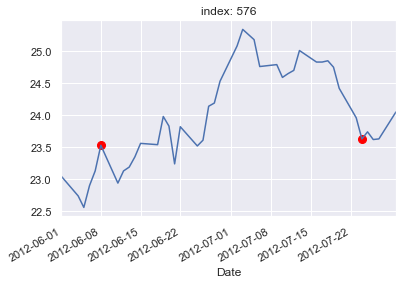

    buy_close= 24.46 buy_date= 2012-08-06 00:00:00 buy_id= 621
    sell_close= 25.51 sell_date= 2012-09-27 00:00:00 sell_id= 658
    gain= 1.0500000000000007 gain_pct=4.3%
    subset_slopes:
    min= -0.0007341744598470257 max= 0.04992342828093754 mean= 0.028993425091153647 std= 0.01608875224219871
    days in trade= 37
    daily compounded return=0.11%
    buy_id= 616 sell_id= 663


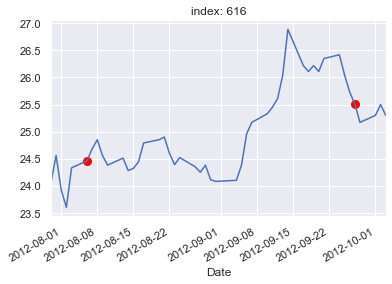

    buy_close= 25.66 buy_date= 2012-10-31 00:00:00 buy_id= 680
    sell_close= 27.0 sell_date= 2013-01-03 00:00:00 sell_id= 723
    gain= 1.3399999999999999 gain_pct=5.2%
    subset_slopes:
    min= -0.003578779592874781 max= 0.051161914614155535 mean= 0.030505254051082176 std= 0.015005877660253707
    days in trade= 43
    daily compounded return=0.12%
    buy_id= 675 sell_id= 728


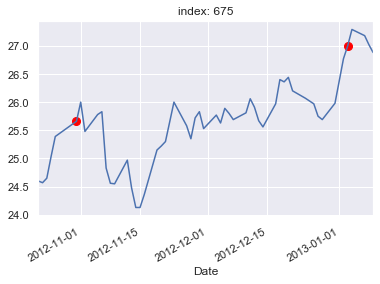

    buy_close= 23.47 buy_date= 2013-05-13 00:00:00 buy_id= 812
    sell_close= 27.87 sell_date= 2013-08-09 00:00:00 sell_id= 874
    gain= 4.400000000000002 gain_pct=18.7%
    subset_slopes:
    min= -0.001975093291779473 max= 0.12432427550933767 mean= 0.0665888010507725 std= 0.04114950228570239
    days in trade= 62
    daily compounded return=0.28%
    buy_id= 807 sell_id= 879


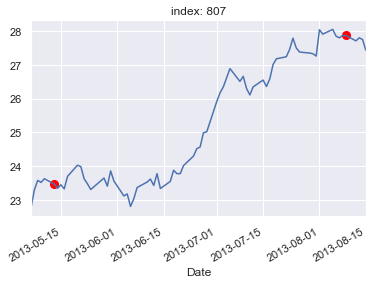

    buy_close= 26.25 buy_date= 2013-09-25 00:00:00 buy_id= 906
    sell_close= 30.17 sell_date= 2014-01-06 00:00:00 sell_id= 976
    gain= 3.9200000000000017 gain_pct=14.9%
    subset_slopes:
    min= -0.000681259651578614 max= 0.0807107186446423 mean= 0.054946636223245755 std= 0.021714075300002404
    days in trade= 70
    daily compounded return=0.2%
    buy_id= 901 sell_id= 981


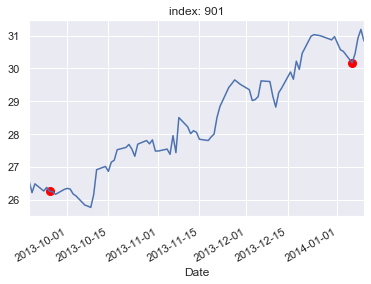

    buy_close= 29.21 buy_date= 2014-02-13 00:00:00 buy_id= 1003
    sell_close= 31.48 sell_date= 2014-03-26 00:00:00 sell_id= 1031
    gain= 2.2699999999999996 gain_pct=7.8%
    subset_slopes:
    min= -0.005631464808438125 max= 0.08055754155708783 mean= 0.05094332897154492 std= 0.02561488520937471
    days in trade= 28
    daily compounded return=0.27%
    buy_id= 998 sell_id= 1036


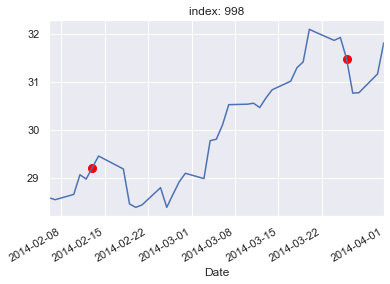

    buy_close= 27.78 buy_date= 2014-05-15 00:00:00 buy_id= 1066
    sell_close= 29.85 sell_date= 2014-06-25 00:00:00 sell_id= 1094
    gain= 2.0700000000000003 gain_pct=7.5%
    subset_slopes:
    min= -0.000338126781940673 max= 0.05798436976129295 mean= 0.03809858837675798 std= 0.017329310348536478
    days in trade= 28
    daily compounded return=0.26%
    buy_id= 1061 sell_id= 1099


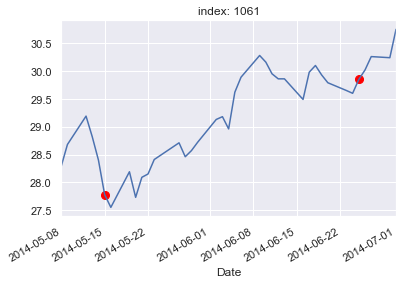

    buy_close= 27.75 buy_date= 2014-08-15 00:00:00 buy_id= 1130
    sell_close= 28.51 sell_date= 2014-09-05 00:00:00 sell_id= 1144
    gain= 0.7600000000000016 gain_pct=2.7%
    subset_slopes:
    min= -0.0024736556844580093 max= 0.015716224930571343 mean= 0.00997609949943344 std= 0.005432151412548013
    days in trade= 14
    daily compounded return=0.19%
    buy_id= 1125 sell_id= 1149


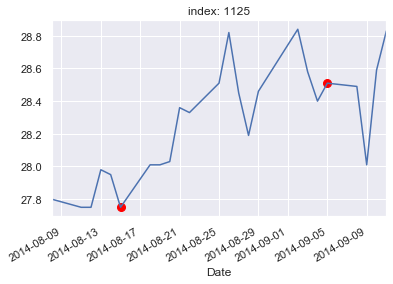

    buy_close= 27.66 buy_date= 2014-10-02 00:00:00 buy_id= 1163
    sell_close= 30.38 sell_date= 2014-11-10 00:00:00 sell_id= 1190
    gain= 2.719999999999999 gain_pct=9.8%
    subset_slopes:
    min= -0.00548664902157725 max= 0.07211756482259091 mean= 0.044205309499823195 std= 0.023626348576000825
    days in trade= 27
    daily compounded return=0.35%
    buy_id= 1158 sell_id= 1195


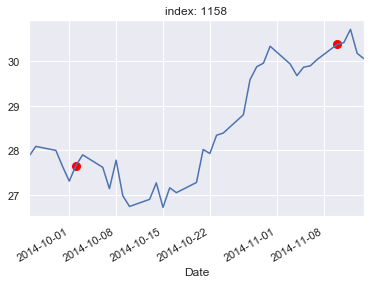

    buy_close= 22.51 buy_date= 2015-01-23 00:00:00 buy_id= 1240
    sell_close= 26.23 sell_date= 2015-03-30 00:00:00 sell_id= 1285
    gain= 3.719999999999999 gain_pct=16.5%
    subset_slopes:
    min= -6.0164386752603605e-05 max= 0.09798012962813729 mean= 0.04532897924489395 std= 0.03284373778035149
    days in trade= 45
    daily compounded return=0.34%
    buy_id= 1235 sell_id= 1290


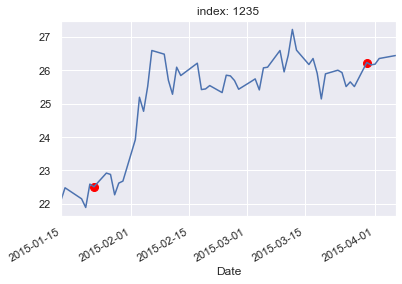

    buy_close= 25.48 buy_date= 2015-05-05 00:00:00 buy_id= 1310
    sell_close= 28.67 sell_date= 2015-06-22 00:00:00 sell_id= 1343
    gain= 3.1900000000000013 gain_pct=12.5%
    subset_slopes:
    min= -0.0026638324254903978 max= 0.08264857138191672 mean= 0.049275340369130435 std= 0.027141944495449898
    days in trade= 33
    daily compounded return=0.36%
    buy_id= 1305 sell_id= 1348


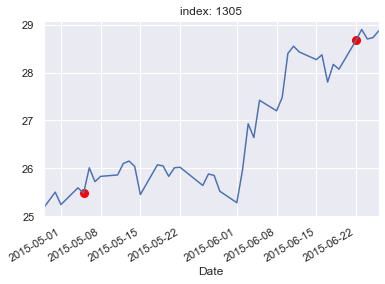

    buy_close= 24.62 buy_date= 2015-09-17 00:00:00 buy_id= 1404
    sell_close= 26.51 sell_date= 2015-11-11 00:00:00 sell_id= 1443
    gain= 1.8900000000000006 gain_pct=7.7%
    subset_slopes:
    min= -0.0001271570590759552 max= 0.05481791449139095 mean= 0.025937124785403016 std= 0.019770193930574026
    days in trade= 39
    daily compounded return=0.19%
    buy_id= 1399 sell_id= 1448


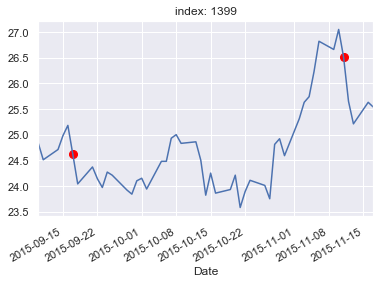

    buy_close= 21.53 buy_date= 2016-01-29 00:00:00 buy_id= 1496
    sell_close= 22.36 sell_date= 2016-03-10 00:00:00 sell_id= 1524
    gain= 0.8299999999999983 gain_pct=3.9%
    subset_slopes:
    min= -0.00532624179971819 max= 0.06418632878175856 mean= 0.03574516454242601 std= 0.021781826286041053
    days in trade= 28
    daily compounded return=0.14%
    buy_id= 1491 sell_id= 1529


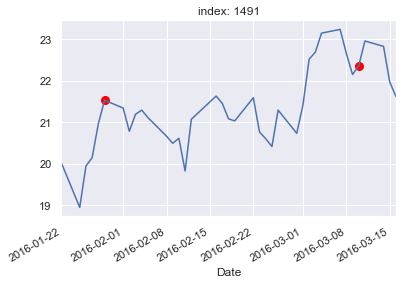

    buy_close= 22.29 buy_date= 2016-03-17 00:00:00 buy_id= 1529
    sell_close= 43.89 sell_date= 2017-02-24 00:00:00 sell_id= 1766
    gain= 21.6 gain_pct=96.9%
    subset_slopes:
    min= -0.00039666388283166043 max= 0.29434441712731996 mean= 0.0911289548326306 std= 0.07433965483318819
    days in trade= 237
    daily compounded return=0.29%
    buy_id= 1524 sell_id= 1771


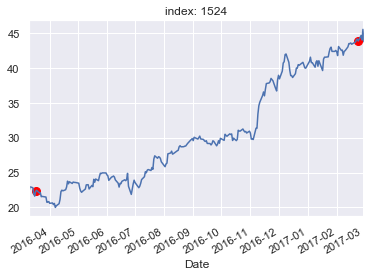

    buy_close= 42.47 buy_date= 2017-03-31 00:00:00 buy_id= 1791
    sell_close= 44.66 sell_date= 2017-06-28 00:00:00 sell_id= 1852
    gain= 2.1899999999999977 gain_pct=5.2%
    subset_slopes:
    min= -0.0007078232763646497 max= 0.08927252856829426 mean= 0.050091690549881836 std= 0.024120488010535006
    days in trade= 61
    daily compounded return=0.08%
    buy_id= 1786 sell_id= 1857


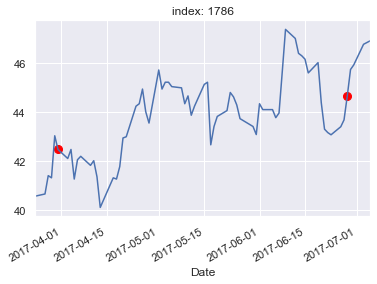

    buy_close= 41.66 buy_date= 2017-08-25 00:00:00 buy_id= 1893
    sell_close= 49.41 sell_date= 2018-02-09 00:00:00 sell_id= 2008
    gain= 7.75 gain_pct=18.6%
    subset_slopes:
    min= -0.0073633351217310405 max= 0.18953693093222057 mean= 0.08316381432042318 std= 0.055315924691601924
    days in trade= 115
    daily compounded return=0.15%
    buy_id= 1888 sell_id= 2013


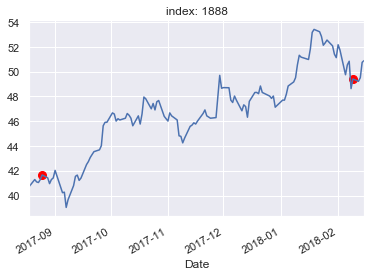

    buy_close= 50.46 buy_date= 2018-02-20 00:00:00 buy_id= 2014
    sell_close= 49.22 sell_date= 2018-03-01 00:00:00 sell_id= 2021
    gain= -1.240000000000002 gain_pct=-2.5%
    subset_slopes:
    min= -0.00023201448892962162 max= 0.0013854782411684141 mean= 0.0007824773108150598 std= 0.0005709286605757479
    days in trade= 7
    daily compounded return=-0.36%
    buy_id= 2009 sell_id= 2026


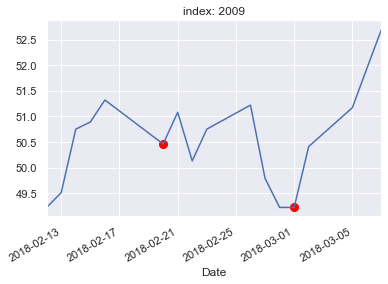

    buy_close= 47.44 buy_date= 2018-04-27 00:00:00 buy_id= 2061
    sell_close= 49.5 sell_date= 2018-05-25 00:00:00 sell_id= 2081
    gain= 2.0600000000000023 gain_pct=4.3%
    subset_slopes:
    min= -0.0013833952119810533 max= 0.05177470129009265 mean= 0.033279330474459454 std= 0.015962867625647217
    days in trade= 20
    daily compounded return=0.21%
    buy_id= 2056 sell_id= 2086


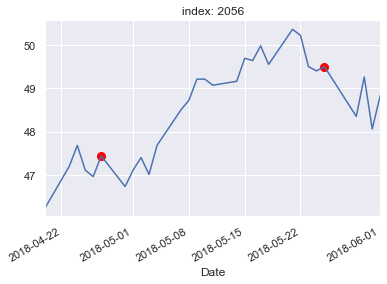

    buy_close= 45.79 buy_date= 2018-07-05 00:00:00 buy_id= 2108
    sell_close= 49.88 sell_date= 2018-08-17 00:00:00 sell_id= 2139
    gain= 4.090000000000003 gain_pct=8.9%
    subset_slopes:
    min= -0.008268803458570062 max= 0.1012773970589862 mean= 0.06060057476002562 std= 0.032904824345268285
    days in trade= 31
    daily compounded return=0.28%
    buy_id= 2103 sell_id= 2144


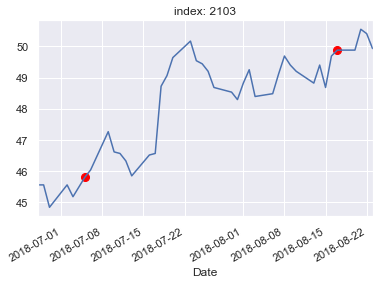

    buy_close= 33.2 buy_date= 2018-12-21 00:00:00 buy_id= 2226
    sell_close= 42.63 sell_date= 2019-02-25 00:00:00 sell_id= 2268
    gain= 9.43 gain_pct=28.4%
    subset_slopes:
    min= -0.0019556599492176474 max= 0.21117577202110738 mean= 0.12741271248042926 std= 0.0668393759161842
    days in trade= 42
    daily compounded return=0.6%
    buy_id= 2221 sell_id= 2273


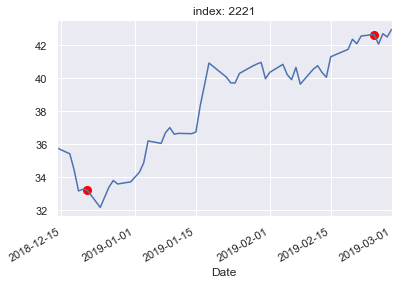

    buy_close= 37.1 buy_date= 2019-03-22 00:00:00 buy_id= 2287
    sell_close= 42.1 sell_date= 2019-04-23 00:00:00 sell_id= 2308
    gain= 5.0 gain_pct=13.5%
    subset_slopes:
    min= -0.0013798342194917268 max= 0.053739383997871926 mean= 0.03288911856022161 std= 0.017211558186903685
    days in trade= 21
    daily compounded return=0.6%
    buy_id= 2282 sell_id= 2313


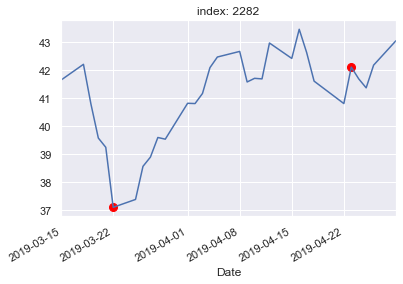

    buy_close= 39.34 buy_date= 2019-06-18 00:00:00 buy_id= 2347
    sell_close= 38.95 sell_date= 2019-07-09 00:00:00 sell_id= 2361
    gain= -0.39000000000000057 gain_pct=-1.0%
    subset_slopes:
    min= -0.0025953516938344023 max= 0.022365798348332078 mean= 0.014220818674078015 std= 0.007508530343929414
    days in trade= 14
    daily compounded return=-0.07%
    buy_id= 2342 sell_id= 2366


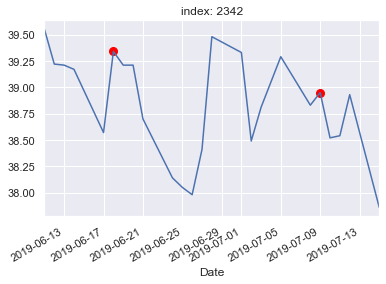

    buy_close= 33.48 buy_date= 2019-08-27 00:00:00 buy_id= 2396
    sell_close= 43.87 sell_date= 2020-01-02 00:00:00 sell_id= 2484
    gain= 10.39 gain_pct=31.0%
    subset_slopes:
    min= -0.0004431966452145275 max= 0.10948569558827614 mean= 0.07838252214386082 std= 0.023349769176309154
    days in trade= 88
    daily compounded return=0.31%
    buy_id= 2391 sell_id= 2489


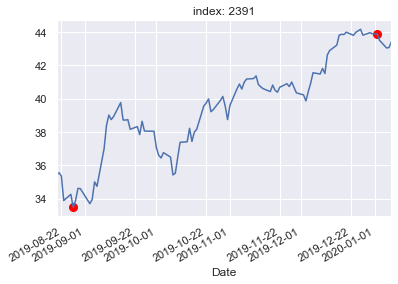


*******************
*** MBI        ***
*******************

    buy_close= 6.25 buy_date= 2010-06-21 00:00:00 buy_id= 84
    sell_close= 12.13 sell_date= 2010-10-25 00:00:00 sell_id= 172
    gain= 5.880000000000001 gain_pct=94.1%
    subset_slopes:
    min= -0.0067754910056780915 max= 0.09911738984378626 mean= 0.059058105966101844 std= 0.02507932390853002
    days in trade= 88
    daily compounded return=0.76%
    buy_id= 79 sell_id= 177


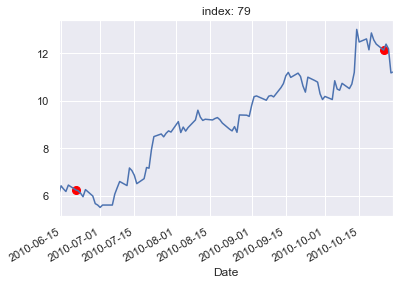

    buy_close= 10.36 buy_date= 2010-12-03 00:00:00 buy_id= 200
    sell_close= 12.33 sell_date= 2011-01-20 00:00:00 sell_id= 232
    gain= 1.9700000000000006 gain_pct=19.0%
    subset_slopes:
    min= -0.009242484786010863 max= 0.07735513285583373 mean= 0.04691970787272176 std= 0.024893951987475276
    days in trade= 32
    daily compounded return=0.55%
    buy_id= 195 sell_id= 237


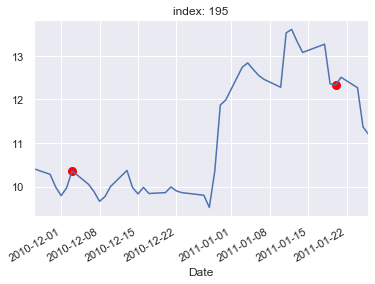

    buy_close= 8.29 buy_date= 2011-06-14 00:00:00 buy_id= 332
    sell_close= 9.04 sell_date= 2011-07-12 00:00:00 sell_id= 351
    gain= 0.75 gain_pct=9.0%
    subset_slopes:
    min= -0.002663786922594724 max= 0.03523870696743536 mean= 0.022473957990908705 std= 0.011303381028232131
    days in trade= 19
    daily compounded return=0.45%
    buy_id= 327 sell_id= 356


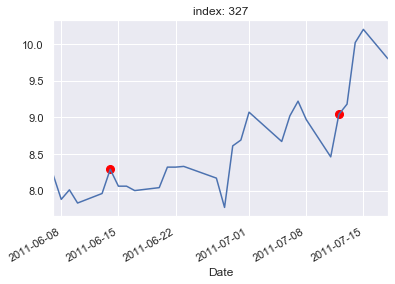

    buy_close= 7.1 buy_date= 2011-08-26 00:00:00 buy_id= 384
    sell_close= 12.35 sell_date= 2012-01-19 00:00:00 sell_id= 483
    gain= 5.25 gain_pct=73.9%
    subset_slopes:
    min= -0.0020969721432342325 max= 0.13749844621476193 mean= 0.05032913571691555 std= 0.04461923467510854
    days in trade= 99
    daily compounded return=0.56%
    buy_id= 379 sell_id= 488


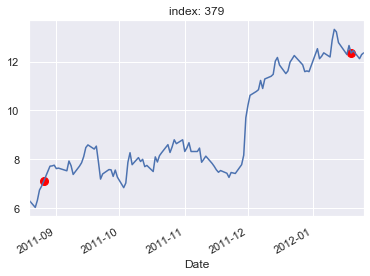

    buy_close= 9.71 buy_date= 2012-04-03 00:00:00 buy_id= 535
    sell_close= 10.28 sell_date= 2012-04-12 00:00:00 sell_id= 541
    gain= 0.5699999999999985 gain_pct=5.9%
    subset_slopes:
    min= -0.0003528521210043323 max= 0.0028620079496057826 mean= 0.0018779721805766887 std= 0.0011340354932959402
    days in trade= 6
    daily compounded return=0.96%
    buy_id= 530 sell_id= 546


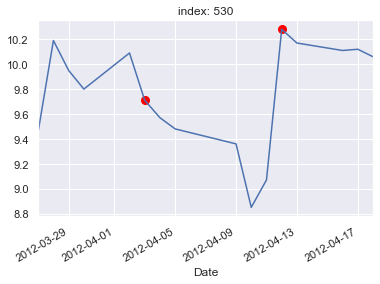

    buy_close= 8.5 buy_date= 2012-05-24 00:00:00 buy_id= 571
    sell_close= 10.61 sell_date= 2012-07-09 00:00:00 sell_id= 601
    gain= 2.1099999999999994 gain_pct=24.8%
    subset_slopes:
    min= -0.0015522978461390835 max= 0.05463452177093764 mean= 0.03279575177488076 std= 0.01755319937008722
    days in trade= 30
    daily compounded return=0.74%
    buy_id= 566 sell_id= 606


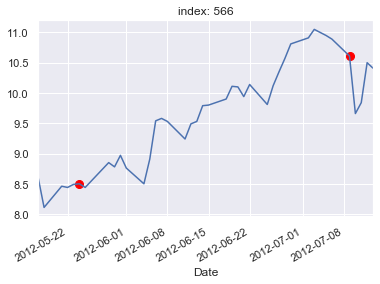

    buy_close= 9.86 buy_date= 2012-07-30 00:00:00 buy_id= 616
    sell_close= 11.85 sell_date= 2012-09-13 00:00:00 sell_id= 648
    gain= 1.9900000000000002 gain_pct=20.2%
    subset_slopes:
    min= -0.001613835215419357 max= 0.04766153145927454 mean= 0.0273365532418966 std= 0.015584900339371228
    days in trade= 32
    daily compounded return=0.58%
    buy_id= 611 sell_id= 653


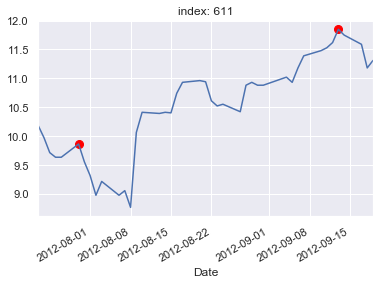

    buy_close= 8.42 buy_date= 2012-12-10 00:00:00 buy_id= 707
    sell_close= 8.13 sell_date= 2012-12-19 00:00:00 sell_id= 714
    gain= -0.28999999999999915 gain_pct=-3.4%
    subset_slopes:
    min= -0.001911875424962517 max= 0.0021157795902730925 mean= 0.0009323926177423455 std= 0.0013316119549946876
    days in trade= 7
    daily compounded return=-0.49%
    buy_id= 702 sell_id= 719


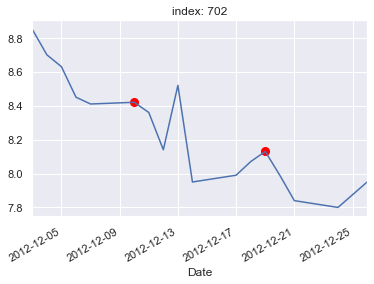

    buy_close= 7.78 buy_date= 2012-12-27 00:00:00 buy_id= 719
    sell_close= 12.42 sell_date= 2013-03-12 00:00:00 sell_id= 769
    gain= 4.64 gain_pct=59.6%
    subset_slopes:
    min= -0.00039086043867264664 max= 0.1070672045241956 mean= 0.05996288641896953 std= 0.03436025873865422
    days in trade= 50
    daily compounded return=0.94%
    buy_id= 714 sell_id= 774


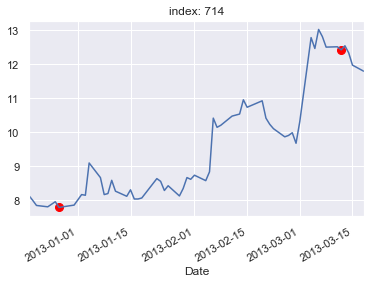

    buy_close= 10.47 buy_date= 2013-04-09 00:00:00 buy_id= 788
    sell_close= 14.37 sell_date= 2013-05-30 00:00:00 sell_id= 824
    gain= 3.8999999999999986 gain_pct=37.2%
    subset_slopes:
    min= -0.00978936357928184 max= 0.14973361991830458 mean= 0.0946817550272516 std= 0.047846827894171634
    days in trade= 36
    daily compounded return=0.88%
    buy_id= 783 sell_id= 829


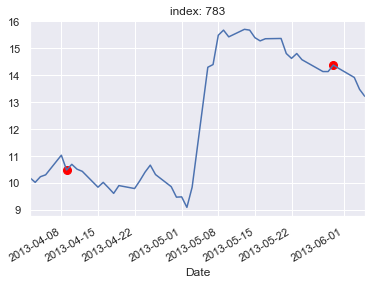

    buy_close= 13.18 buy_date= 2013-07-03 00:00:00 buy_id= 848
    sell_close= 13.52 sell_date= 2013-07-11 00:00:00 sell_id= 853
    gain= 0.33999999999999986 gain_pct=2.6%
    subset_slopes:
    min= -0.0009987370826731734 max= 0.0013804683591036593 mean= 0.0006010921755006393 std= 0.0008919009778303694
    days in trade= 5
    daily compounded return=0.51%
    buy_id= 843 sell_id= 858


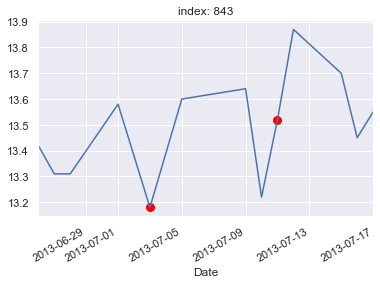

    buy_close= 9.67 buy_date= 2013-10-10 00:00:00 buy_id= 917
    sell_close= 12.76 sell_date= 2013-11-25 00:00:00 sell_id= 949
    gain= 3.09 gain_pct=32.0%
    subset_slopes:
    min= -0.00014117218027642764 max= 0.06869483251637476 mean= 0.0416263654841979 std= 0.02147617607684135
    days in trade= 32
    daily compounded return=0.87%
    buy_id= 912 sell_id= 954


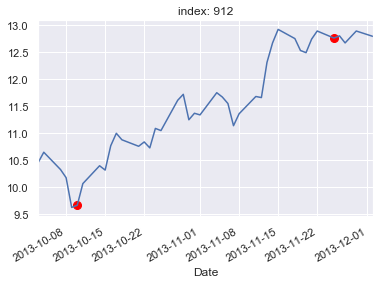

    buy_close= 11.78 buy_date= 2014-01-13 00:00:00 buy_id= 981
    sell_close= 14.18 sell_date= 2014-03-17 00:00:00 sell_id= 1024
    gain= 2.4000000000000004 gain_pct=20.4%
    subset_slopes:
    min= -0.0006469755412918943 max= 0.09805718714238054 mean= 0.056583282990342015 std= 0.031622040786461136
    days in trade= 43
    daily compounded return=0.43%
    buy_id= 976 sell_id= 1029


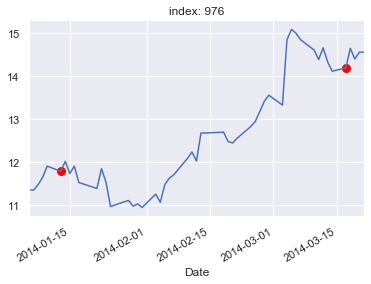

    buy_close= 12.24 buy_date= 2014-05-13 00:00:00 buy_id= 1064
    sell_close= 11.89 sell_date= 2014-06-02 00:00:00 sell_id= 1077
    gain= -0.34999999999999964 gain_pct=-2.9%
    subset_slopes:
    min= -0.0004690283132386952 max= 0.0147302629763999 mean= 0.009638067117497765 std= 0.004625784359298426
    days in trade= 13
    daily compounded return=-0.23%
    buy_id= 1059 sell_id= 1082


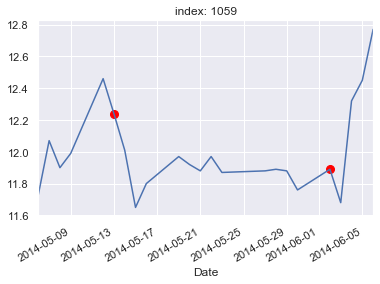

    buy_close= 9.58 buy_date= 2014-07-31 00:00:00 buy_id= 1119
    sell_close= 10.38 sell_date= 2014-08-26 00:00:00 sell_id= 1137
    gain= 0.8000000000000007 gain_pct=8.4%
    subset_slopes:
    min= -0.0010224185505744998 max= 0.018199763606753905 mean= 0.011944671086139379 std= 0.005530346104363076
    days in trade= 18
    daily compounded return=0.45%
    buy_id= 1114 sell_id= 1142


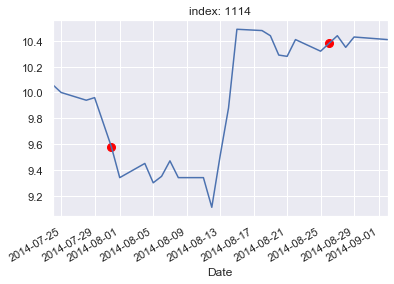

    buy_close= 9.22 buy_date= 2014-10-08 00:00:00 buy_id= 1167
    sell_close= 10.26 sell_date= 2014-11-18 00:00:00 sell_id= 1196
    gain= 1.0399999999999991 gain_pct=11.3%
    subset_slopes:
    min= -0.002529140478234382 max= 0.0364220496988672 mean= 0.02229941978470972 std= 0.011803663712359727
    days in trade= 29
    daily compounded return=0.37%
    buy_id= 1162 sell_id= 1201


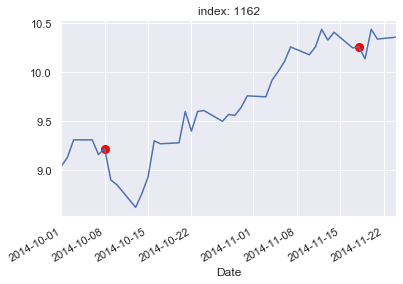

    buy_close= 8.56 buy_date= 2015-02-05 00:00:00 buy_id= 1249
    sell_close= 9.2 sell_date= 2015-04-01 00:00:00 sell_id= 1287
    gain= 0.6399999999999988 gain_pct=7.5%
    subset_slopes:
    min= -0.0005083397108673893 max= 0.025665325907729297 mean= 0.01731590977281261 std= 0.007696398910306698
    days in trade= 38
    daily compounded return=0.19%
    buy_id= 1244 sell_id= 1292


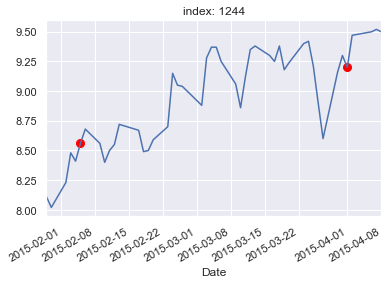

    buy_close= 6.19 buy_date= 2015-07-28 00:00:00 buy_id= 1368
    sell_close= 7.51 sell_date= 2015-10-30 00:00:00 sell_id= 1435
    gain= 1.3199999999999994 gain_pct=21.3%
    subset_slopes:
    min= -0.0034745964701947685 max= 0.029399229567204088 mean= 0.015612069467009073 std= 0.009684797313027581
    days in trade= 67
    daily compounded return=0.29%
    buy_id= 1363 sell_id= 1440


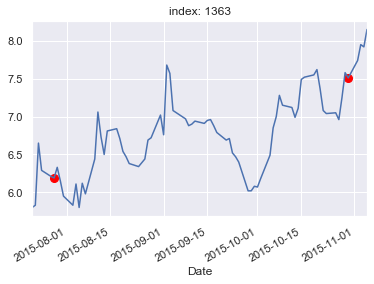

    buy_close= 6.24 buy_date= 2015-12-23 00:00:00 buy_id= 1472
    sell_close= 8.62 sell_date= 2016-03-28 00:00:00 sell_id= 1535
    gain= 2.379999999999999 gain_pct=38.1%
    subset_slopes:
    min= -0.000910850086619952 max= 0.08533701415148798 mean= 0.03783937521045772 std= 0.029827943153730264
    days in trade= 63
    daily compounded return=0.51%
    buy_id= 1467 sell_id= 1540


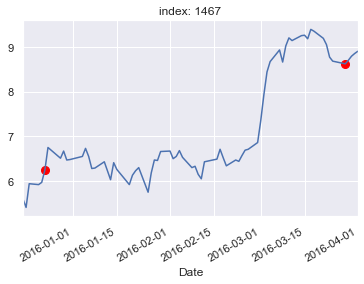

    buy_close= 6.8 buy_date= 2016-06-15 00:00:00 buy_id= 1591
    sell_close= 8.13 sell_date= 2016-08-12 00:00:00 sell_id= 1632
    gain= 1.330000000000001 gain_pct=19.6%
    subset_slopes:
    min= -0.001723801350145493 max= 0.04772867316287588 mean= 0.028248666027120586 std= 0.015366609423696487
    days in trade= 41
    daily compounded return=0.44%
    buy_id= 1586 sell_id= 1637


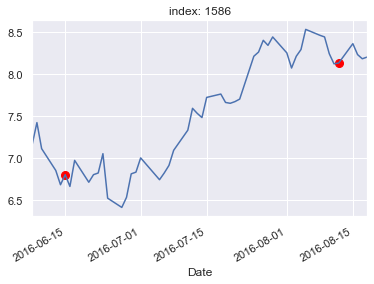

    buy_close= 7.9 buy_date= 2016-10-04 00:00:00 buy_id= 1668
    sell_close= 10.98 sell_date= 2017-01-03 00:00:00 sell_id= 1730
    gain= 3.08 gain_pct=39.0%
    subset_slopes:
    min= -6.880474468307085e-05 max= 0.10066244732971441 mean= 0.05159807145681199 std= 0.03398032182081355
    days in trade= 62
    daily compounded return=0.53%
    buy_id= 1663 sell_id= 1735


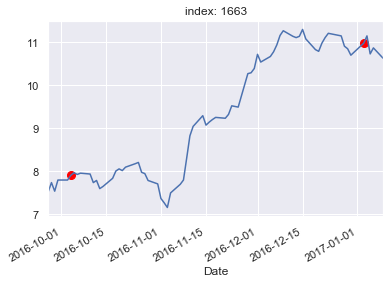

    buy_close= 7.97 buy_date= 2017-05-17 00:00:00 buy_id= 1823
    sell_close= 9.67 sell_date= 2017-08-08 00:00:00 sell_id= 1880
    gain= 1.7000000000000002 gain_pct=21.3%
    subset_slopes:
    min= -0.0013962849803785815 max= 0.05804690012527658 mean= 0.03391284028424953 std= 0.018634765181978312
    days in trade= 57
    daily compounded return=0.34%
    buy_id= 1818 sell_id= 1885


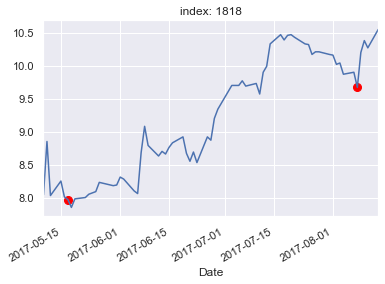

    buy_close= 6.65 buy_date= 2017-10-24 00:00:00 buy_id= 1934
    sell_close= 8.48 sell_date= 2017-11-28 00:00:00 sell_id= 1958
    gain= 1.83 gain_pct=27.5%
    subset_slopes:
    min= -0.005694630048084903 max= 0.04599719356318932 mean= 0.02891662208022061 std= 0.014958659524823734
    days in trade= 24
    daily compounded return=1.02%
    buy_id= 1929 sell_id= 1963


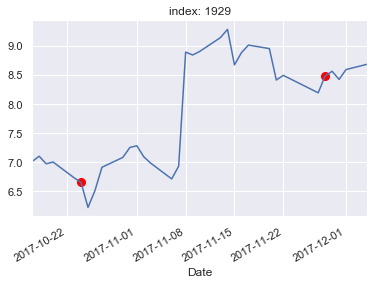

    buy_close= 7.39 buy_date= 2018-01-17 00:00:00 buy_id= 1991
    sell_close= 9.13 sell_date= 2018-04-09 00:00:00 sell_id= 2047
    gain= 1.740000000000001 gain_pct=23.5%
    subset_slopes:
    min= -0.0016055953128573108 max= 0.04699584754369823 mean= 0.02907564189631909 std= 0.0141509958346994
    days in trade= 56
    daily compounded return=0.38%
    buy_id= 1986 sell_id= 2052


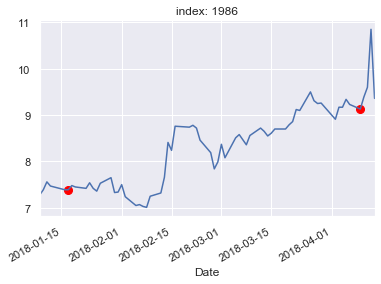

    buy_close= 8.92 buy_date= 2018-05-11 00:00:00 buy_id= 2071
    sell_close= 10.63 sell_date= 2018-09-14 00:00:00 sell_id= 2158
    gain= 1.7100000000000009 gain_pct=19.2%
    subset_slopes:
    min= -0.002899342109667913 max= 0.04417529067466752 mean= 0.02178375885531595 std= 0.011114537420685362
    days in trade= 87
    daily compounded return=0.2%
    buy_id= 2066 sell_id= 2163


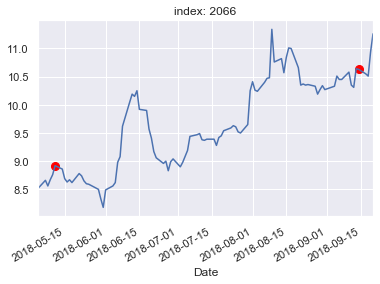

    buy_close= 8.53 buy_date= 2018-12-19 00:00:00 buy_id= 2224
    sell_close= 10.47 sell_date= 2019-03-07 00:00:00 sell_id= 2276
    gain= 1.9400000000000013 gain_pct=22.7%
    subset_slopes:
    min= -8.925604841891754e-05 max= 0.03294716270172593 mean= 0.023593380951194735 std= 0.009129666715298974
    days in trade= 52
    daily compounded return=0.39%
    buy_id= 2219 sell_id= 2281


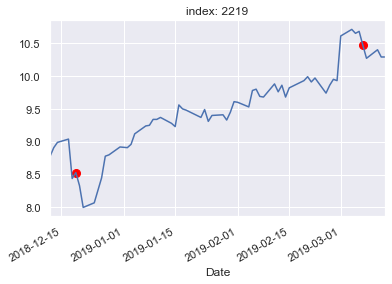

    buy_close= 9.07 buy_date= 2019-06-07 00:00:00 buy_id= 2340
    sell_close= 9.51 sell_date= 2019-07-15 00:00:00 sell_id= 2365
    gain= 0.4399999999999995 gain_pct=4.9%
    subset_slopes:
    min= -0.0018443903389506744 max= 0.013765057239233158 mean= 0.008355912218698905 std= 0.004530719649892453
    days in trade= 25
    daily compounded return=0.19%
    buy_id= 2335 sell_id= 2370


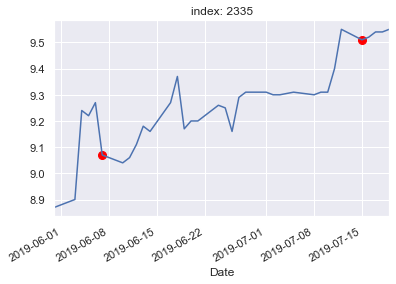

    buy_close= 9.06 buy_date= 2019-08-15 00:00:00 buy_id= 2388
    sell_close= 9.5 sell_date= 2019-11-01 00:00:00 sell_id= 2443
    gain= 0.4399999999999995 gain_pct=4.9%
    subset_slopes:
    min= -0.00010230632368823933 max= 0.012959844391954078 mean= 0.007909056917169819 std= 0.0035719737771870656
    days in trade= 55
    daily compounded return=0.09%
    buy_id= 2383 sell_id= 2448


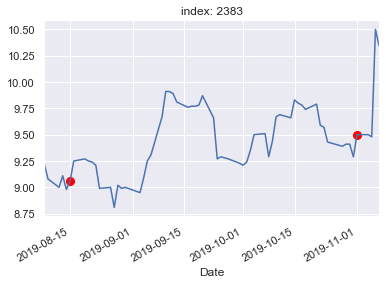

    buy_close= 9.2 buy_date= 2020-01-14 00:00:00 buy_id= 2492
    buy_id= 2487 sell_id= 2507


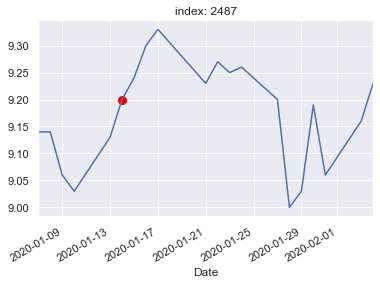


*******************
*** PANW        ***
*******************

    buy_close= 54.66 buy_date= 2012-12-21 00:00:00 buy_id= 106
    sell_close= 58.55 sell_date= 2013-03-01 00:00:00 sell_id= 152
    gain= 3.8900000000000006 gain_pct=7.1%
    subset_slopes:
    min= -0.0027797593466516446 max= 0.14412532610737117 mean= 0.09326756052901647 std= 0.0461490653144039
    days in trade= 46
    daily compounded return=0.15%
    buy_id= 101 sell_id= 157


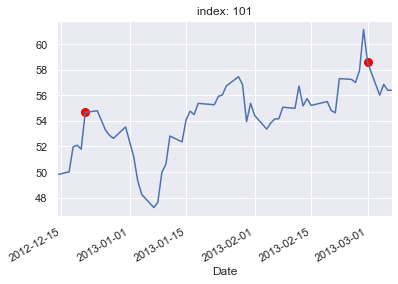

    buy_close= 42.08 buy_date= 2013-06-26 00:00:00 buy_id= 233
    sell_close= 49.51 sell_date= 2013-08-08 00:00:00 sell_id= 263
    gain= 7.43 gain_pct=17.7%
    subset_slopes:
    min= -0.025381597242557064 max= 0.21829583753770976 mean= 0.13325794060823787 std= 0.07151185353502962
    days in trade= 30
    daily compounded return=0.54%
    buy_id= 228 sell_id= 268


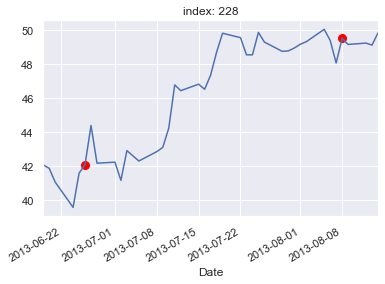

    buy_close= 43.05 buy_date= 2013-10-30 00:00:00 buy_id= 321
    sell_close= 78.26 sell_date= 2014-03-10 00:00:00 sell_id= 409
    gain= 35.21000000000001 gain_pct=81.8%
    subset_slopes:
    min= -0.01847217634548315 max= 0.4666395946497275 mean= 0.3370261362138379 std= 0.12089009955932328
    days in trade= 88
    daily compounded return=0.68%
    buy_id= 316 sell_id= 414


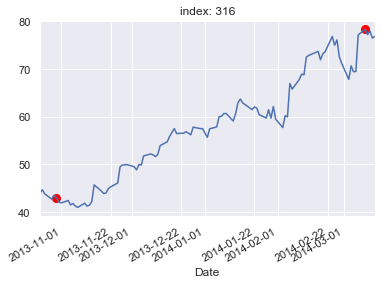

    buy_close= 65.27 buy_date= 2014-05-01 00:00:00 buy_id= 446
    sell_close= 191.25 sell_date= 2015-07-17 00:00:00 sell_id= 751
    gain= 125.98 gain_pct=193.0%
    subset_slopes:
    min= -0.013408028385242687 max= 0.8356636450756127 mean= 0.3855267202623275 std= 0.18180370077886998
    days in trade= 305
    daily compounded return=0.35%
    buy_id= 441 sell_id= 756


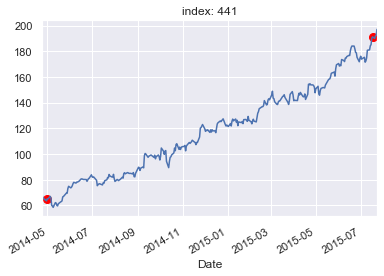

    buy_close= 164.22 buy_date= 2015-08-31 00:00:00 buy_id= 782
    sell_close= 180.77 sell_date= 2015-09-24 00:00:00 sell_id= 799
    gain= 16.55000000000001 gain_pct=10.1%
    subset_slopes:
    min= -0.01901508042436717 max= 0.20383292838445755 mean= 0.12988590258934812 std= 0.06664317514241302
    days in trade= 17
    daily compounded return=0.57%
    buy_id= 777 sell_id= 804


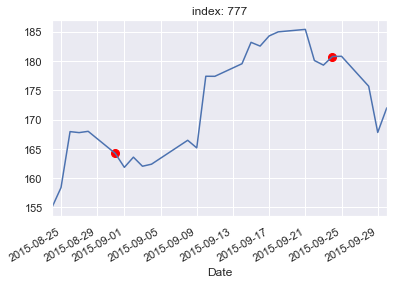

    buy_close= 157.9 buy_date= 2015-10-29 00:00:00 buy_id= 824
    sell_close= 189.99 sell_date= 2015-12-10 00:00:00 sell_id= 853
    gain= 32.09 gain_pct=20.3%
    subset_slopes:
    min= -0.026132523993510404 max= 0.8314151356040327 mean= 0.5466332859243329 std= 0.2535530271958188
    days in trade= 29
    daily compounded return=0.64%
    buy_id= 819 sell_id= 858


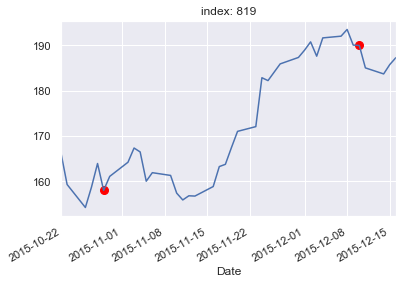

    buy_close= 123.74 buy_date= 2016-02-12 00:00:00 buy_id= 896
    sell_close= 156.19 sell_date= 2016-03-28 00:00:00 sell_id= 925
    gain= 32.45 gain_pct=26.2%
    subset_slopes:
    min= -0.04367810518087367 max= 0.8107102883066091 mean= 0.4913109070691731 std= 0.26075779123169673
    days in trade= 29
    daily compounded return=0.81%
    buy_id= 891 sell_id= 930


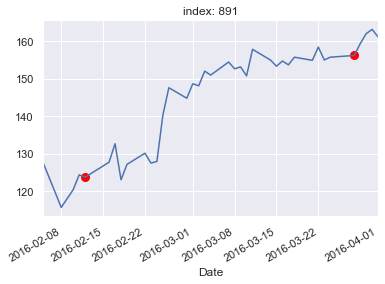

    buy_close= 125.94 buy_date= 2016-07-08 00:00:00 buy_id= 997
    sell_close= 146.0 sell_date= 2016-10-17 00:00:00 sell_id= 1067
    gain= 20.060000000000002 gain_pct=15.9%
    subset_slopes:
    min= -0.01990297669577501 max= 0.6924179522461031 mean= 0.3870842539640886 std= 0.21678541822568617
    days in trade= 70
    daily compounded return=0.21%
    buy_id= 992 sell_id= 1072


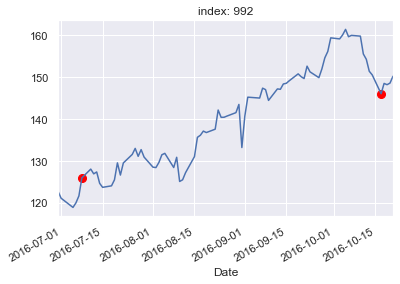

    buy_close= 126.11 buy_date= 2016-12-21 00:00:00 buy_id= 1113
    sell_close= 149.64 sell_date= 2017-02-06 00:00:00 sell_id= 1143
    gain= 23.529999999999987 gain_pct=18.7%
    subset_slopes:
    min= -0.0759392719370453 max= 0.8037273083417631 mean= 0.5025605156733927 std= 0.26181375246931804
    days in trade= 30
    daily compounded return=0.57%
    buy_id= 1108 sell_id= 1148


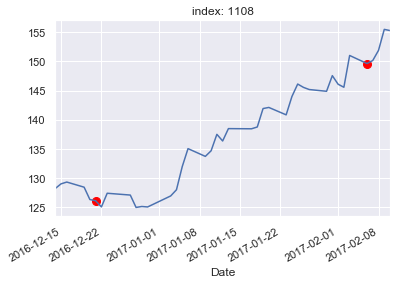

    buy_close= 113.38 buy_date= 2017-04-12 00:00:00 buy_id= 1189
    sell_close= 136.15 sell_date= 2017-07-07 00:00:00 sell_id= 1248
    gain= 22.77000000000001 gain_pct=20.1%
    subset_slopes:
    min= -0.0019051019313991446 max= 0.7303543521577467 mean= 0.4201626276896185 std= 0.23936824794245404
    days in trade= 59
    daily compounded return=0.31%
    buy_id= 1184 sell_id= 1253


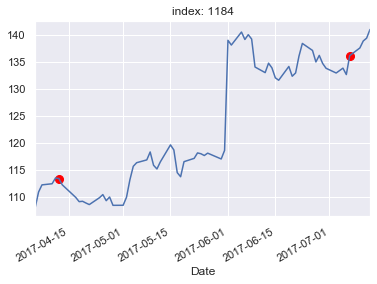

    buy_close= 127.72 buy_date= 2017-08-10 00:00:00 buy_id= 1272
    sell_close= 148.23 sell_date= 2017-10-23 00:00:00 sell_id= 1323
    gain= 20.50999999999999 gain_pct=16.1%
    subset_slopes:
    min= -0.014202889850906786 max= 0.4349909909084033 mean= 0.25334048938211473 std= 0.14348657886543745
    days in trade= 51
    daily compounded return=0.29%
    buy_id= 1267 sell_id= 1328


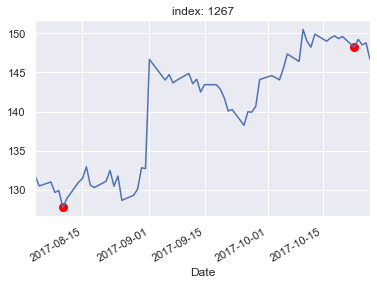

    buy_close= 150.64 buy_date= 2017-11-24 00:00:00 buy_id= 1346
    sell_close= 236.1 sell_date= 2018-09-13 00:00:00 sell_id= 1547
    gain= 85.46000000000001 gain_pct=56.7%
    subset_slopes:
    min= -0.0038904499153318284 max= 0.959809622334518 mean= 0.40603404635241086 std= 0.24918332635783996
    days in trade= 201
    daily compounded return=0.22%
    buy_id= 1341 sell_id= 1552


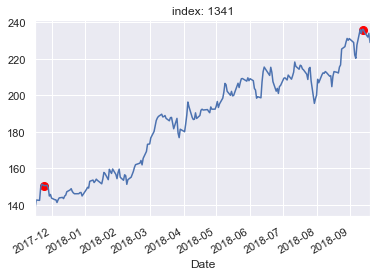

    buy_close= 176.54 buy_date= 2018-11-28 00:00:00 buy_id= 1600
    sell_close= 240.77 sell_date= 2019-04-09 00:00:00 sell_id= 1689
    gain= 64.23000000000002 gain_pct=36.4%
    subset_slopes:
    min= -0.04473205213099618 max= 1.3898973060819912 mean= 0.7359660398841725 std= 0.4575976615563158
    days in trade= 89
    daily compounded return=0.35%
    buy_id= 1595 sell_id= 1694


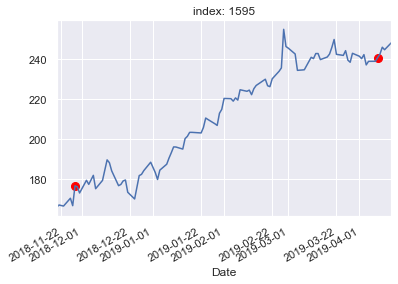

    buy_close= 205.35 buy_date= 2019-06-18 00:00:00 buy_id= 1737
    sell_close= 223.4 sell_date= 2019-07-25 00:00:00 sell_id= 1763
    gain= 18.05000000000001 gain_pct=8.8%
    subset_slopes:
    min= -0.002033203083499302 max= 0.6704934154489308 mean= 0.431874858726561 std= 0.20445994530746572
    days in trade= 26
    daily compounded return=0.32%
    buy_id= 1732 sell_id= 1768


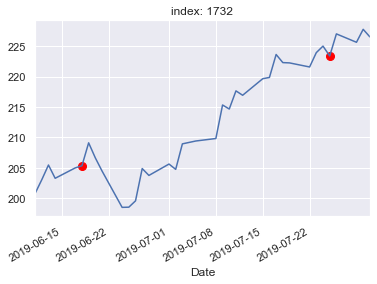

    buy_close= 206.84 buy_date= 2019-09-10 00:00:00 buy_id= 1795
    sell_close= 246.74 sell_date= 2019-11-21 00:00:00 sell_id= 1847
    gain= 39.900000000000006 gain_pct=19.3%
    subset_slopes:
    min= -0.0007196247539127398 max= 1.0183172712087298 mean= 0.5169918526839553 std= 0.3233738255202478
    days in trade= 52
    daily compounded return=0.34%
    buy_id= 1790 sell_id= 1852


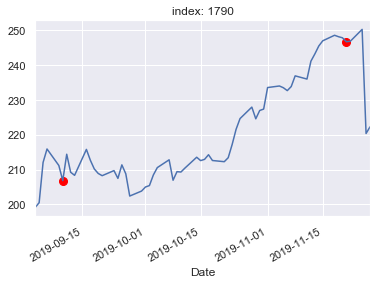

    buy_close= 229.69 buy_date= 2019-12-16 00:00:00 buy_id= 1863
    buy_id= 1858 sell_id= 1878


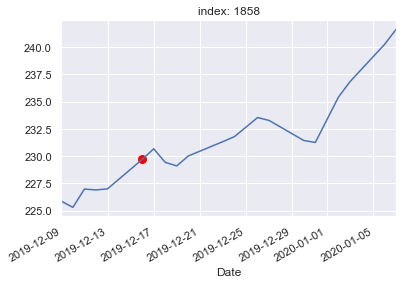


*******************
*** SIBN        ***
*******************

    buy_close= 17.68 buy_date= 2018-11-16 00:00:00 buy_id= 22
    sell_close= 19.92 sell_date= 2019-01-04 00:00:00 sell_id= 53
    gain= 2.240000000000002 gain_pct=12.7%
    subset_slopes:
    min= -0.0011041482858864526 max= 0.07856659359504192 mean= 0.04932307967053079 std= 0.024099640550680576
    days in trade= 31
    daily compounded return=0.39%
    buy_id= 17 sell_id= 58


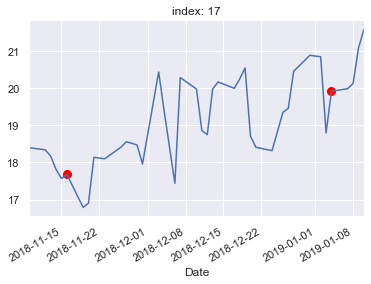

    buy_close= 19.06 buy_date= 2019-02-21 00:00:00 buy_id= 85
    sell_close= 20.0 sell_date= 2019-03-05 00:00:00 sell_id= 93
    gain= 0.9400000000000013 gain_pct=4.9%
    subset_slopes:
    min= -0.002626568752496894 max= 0.007014901660067352 mean= 0.003933947812053251 std= 0.003215307695635237
    days in trade= 8
    daily compounded return=0.6%
    buy_id= 80 sell_id= 98


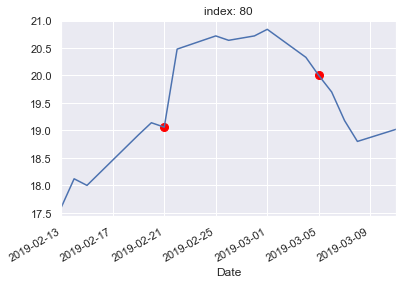

    buy_close= 16.45 buy_date= 2019-05-10 00:00:00 buy_id= 140
    sell_close= 20.18 sell_date= 2019-07-18 00:00:00 sell_id= 187
    gain= 3.7300000000000004 gain_pct=22.7%
    subset_slopes:
    min= -0.0032312687333053702 max= 0.09760392790077077 mean= 0.05147617372354069 std= 0.03171723590480212
    days in trade= 47
    daily compounded return=0.44%
    buy_id= 135 sell_id= 192


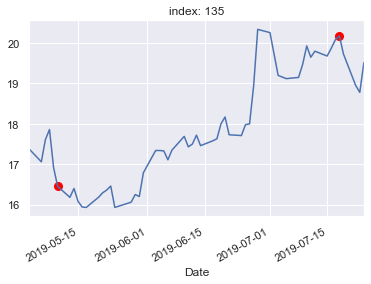

    buy_close= 18.99 buy_date= 2019-08-09 00:00:00 buy_id= 203
    sell_close= 19.04 sell_date= 2019-09-03 00:00:00 sell_id= 219
    gain= 0.05000000000000071 gain_pct=0.3%
    subset_slopes:
    min= -0.002079085578230888 max= 0.021860423209666635 mean= 0.013170124273342187 std= 0.007509791712015154
    days in trade= 16
    daily compounded return=0.02%
    buy_id= 198 sell_id= 224


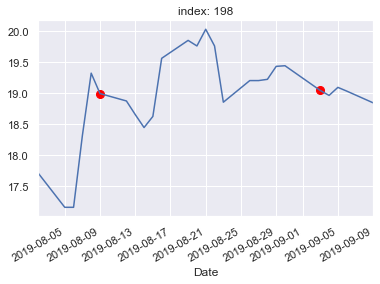

    buy_close= 16.29 buy_date= 2019-10-23 00:00:00 buy_id= 255
    sell_close= 22.04 sell_date= 2020-01-22 00:00:00 sell_id= 316
    gain= 5.75 gain_pct=35.3%
    subset_slopes:
    min= -0.002038353044241603 max= 0.12741331537762335 mean= 0.07414887218293807 std= 0.03756283704923924
    days in trade= 61
    daily compounded return=0.5%
    buy_id= 250 sell_id= 321


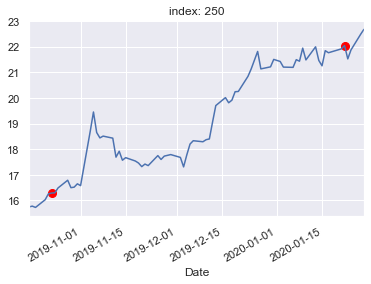


*******************
*** SPPI        ***
*******************

    buy_close= 3.8973 buy_date= 2010-06-24 00:00:00 buy_id= 87
    sell_close= 4.1637 sell_date= 2010-08-02 00:00:00 sell_id= 113
    gain= 0.2664000000000004 gain_pct=6.8%
    subset_slopes:
    min= -0.0010934679298704175 max= 0.0069601911687504625 mean= 0.004408690444946226 std= 0.0023400104189486306
    days in trade= 26
    daily compounded return=0.25%
    buy_id= 82 sell_id= 118


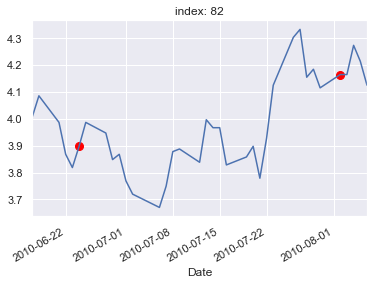

    buy_close= 3.8085 buy_date= 2010-09-02 00:00:00 buy_id= 136
    sell_close= 6.5613 sell_date= 2011-01-14 00:00:00 sell_id= 229
    gain= 2.7528 gain_pct=72.3%
    subset_slopes:
    min= -0.00039183828526612174 max= 0.07041196563841634 mean= 0.02672798911263776 std= 0.022431429753340542
    days in trade= 93
    daily compounded return=0.59%
    buy_id= 131 sell_id= 234


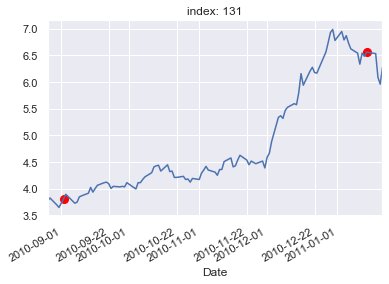

    buy_close= 5.8903 buy_date= 2011-01-28 00:00:00 buy_id= 238
    sell_close= 8.8404 sell_date= 2011-04-15 00:00:00 sell_id= 292
    gain= 2.950100000000001 gain_pct=50.1%
    subset_slopes:
    min= -0.00042199962208844255 max= 0.07115767583717325 mean= 0.04392212059493166 std= 0.02348675023708481
    days in trade= 54
    daily compounded return=0.75%
    buy_id= 233 sell_id= 297


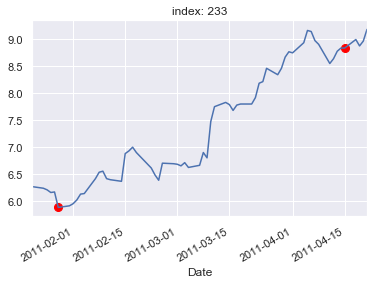

    buy_close= 8.9687 buy_date= 2011-05-24 00:00:00 buy_id= 318
    sell_close= 10.4881 sell_date= 2011-07-20 00:00:00 sell_id= 357
    gain= 1.5193999999999992 gain_pct=16.9%
    subset_slopes:
    min= -0.002095661435669527 max= 0.05343581720052626 mean= 0.033481347490711764 std= 0.01705098168270594
    days in trade= 39
    daily compounded return=0.4%
    buy_id= 313 sell_id= 362


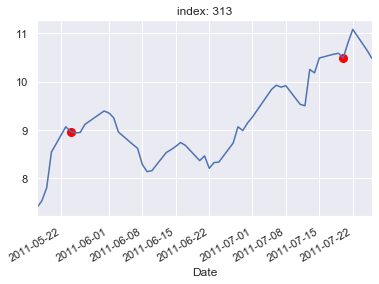

    buy_close= 7.913 buy_date= 2011-09-21 00:00:00 buy_id= 401
    sell_close= 15.2931 sell_date= 2012-01-09 00:00:00 sell_id= 476
    gain= 7.3801000000000005 gain_pct=93.3%
    subset_slopes:
    min= -0.0019594198310937117 max= 0.15753419569491456 mean= 0.08743425459585673 std= 0.04954656041461878
    days in trade= 75
    daily compounded return=0.88%
    buy_id= 396 sell_id= 481


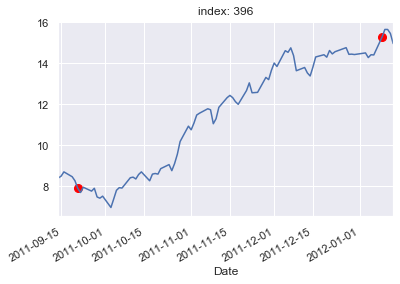

    buy_close= 10.646 buy_date= 2012-04-27 00:00:00 buy_id= 552
    sell_close= 16.1022 sell_date= 2012-07-13 00:00:00 sell_id= 605
    gain= 5.456199999999999 gain_pct=51.3%
    subset_slopes:
    min= -0.006134064519770277 max= 0.15498652119894452 mean= 0.08340243480818238 std= 0.049120469426584316
    days in trade= 53
    daily compounded return=0.78%
    buy_id= 547 sell_id= 610


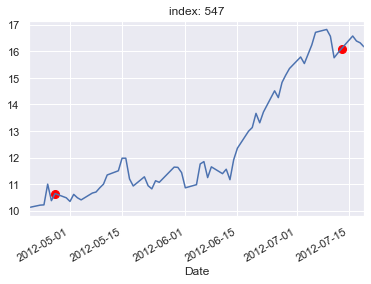

    buy_close= 11.1295 buy_date= 2012-11-20 00:00:00 buy_id= 694
    sell_close= 11.64 sell_date= 2013-01-28 00:00:00 sell_id= 739
    gain= 0.5105000000000004 gain_pct=4.6%
    subset_slopes:
    min= -0.0021169456817506926 max= 0.034413185786194234 mean= 0.023551130055479458 std= 0.011029496225628418
    days in trade= 45
    daily compounded return=0.1%
    buy_id= 689 sell_id= 744


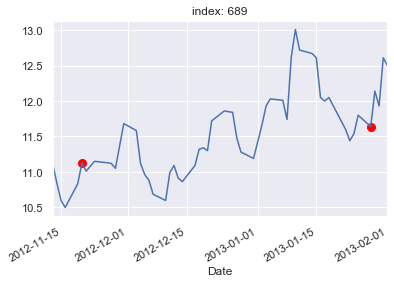

    buy_close= 7.1 buy_date= 2013-04-17 00:00:00 buy_id= 794
    sell_close= 7.76 sell_date= 2013-06-06 00:00:00 sell_id= 829
    gain= 0.6600000000000001 gain_pct=9.3%
    subset_slopes:
    min= -0.00011672571036580592 max= 0.034527597418287925 mean= 0.022713526780595166 std= 0.010907444016326078
    days in trade= 35
    daily compounded return=0.25%
    buy_id= 789 sell_id= 834


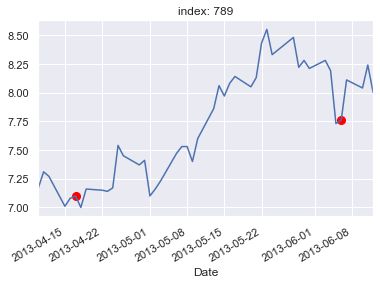

    buy_close= 8.28 buy_date= 2013-06-18 00:00:00 buy_id= 837
    sell_close= 8.54 sell_date= 2013-07-22 00:00:00 sell_id= 860
    gain= 0.2599999999999998 gain_pct=3.1%
    subset_slopes:
    min= -0.0004529972039133412 max= 0.011182305152905414 mean= 0.007021749877884562 std= 0.0036136460811053133
    days in trade= 23
    daily compounded return=0.13%
    buy_id= 832 sell_id= 865


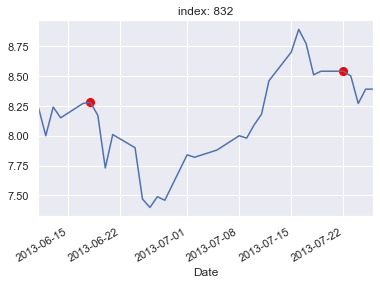

    buy_close= 8.09 buy_date= 2013-08-26 00:00:00 buy_id= 885
    sell_close= 9.36 sell_date= 2013-11-21 00:00:00 sell_id= 947
    gain= 1.2699999999999996 gain_pct=15.7%
    subset_slopes:
    min= -0.0010631006005805688 max= 0.03490110481194364 mean= 0.02222112500817974 std= 0.008450702236037255
    days in trade= 62
    daily compounded return=0.24%
    buy_id= 880 sell_id= 952


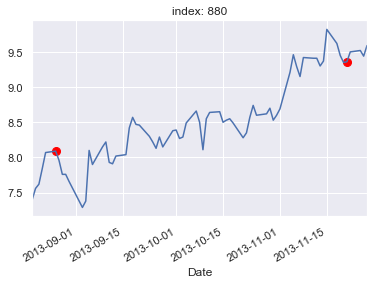

    buy_close= 6.77 buy_date= 2014-04-25 00:00:00 buy_id= 1052
    sell_close= 8.44 sell_date= 2014-06-18 00:00:00 sell_id= 1089
    gain= 1.67 gain_pct=24.7%
    subset_slopes:
    min= -0.002401670932894895 max= 0.043645555736301134 mean= 0.027929477587273203 std= 0.01361909974165678
    days in trade= 37
    daily compounded return=0.6%
    buy_id= 1047 sell_id= 1094


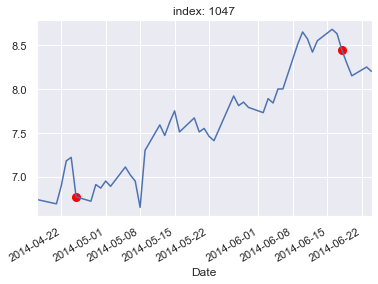

    buy_close= 7.2 buy_date= 2014-07-30 00:00:00 buy_id= 1118
    sell_close= 8.47 sell_date= 2014-09-11 00:00:00 sell_id= 1148
    gain= 1.2700000000000005 gain_pct=17.6%
    subset_slopes:
    min= -0.0033469849686609265 max= 0.031274701196120525 mean= 0.018677123470906012 std= 0.01041250707092745
    days in trade= 30
    daily compounded return=0.54%
    buy_id= 1113 sell_id= 1153


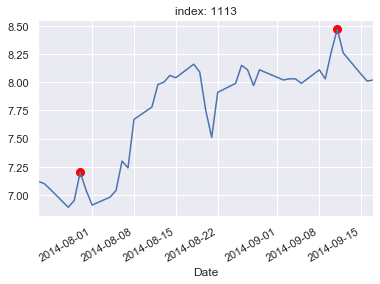

    buy_close= 6.08 buy_date= 2015-04-15 00:00:00 buy_id= 1296
    sell_close= 6.81 sell_date= 2015-07-29 00:00:00 sell_id= 1369
    gain= 0.7299999999999995 gain_pct=12.0%
    subset_slopes:
    min= -0.00045873733448331677 max= 0.02580488762685995 mean= 0.01510001404146395 std= 0.008118919048671413
    days in trade= 73
    daily compounded return=0.16%
    buy_id= 1291 sell_id= 1374


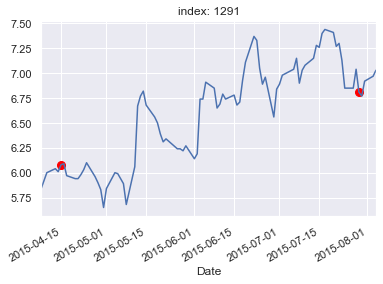

    buy_close= 5.19 buy_date= 2015-11-17 00:00:00 buy_id= 1447
    sell_close= 5.39 sell_date= 2015-12-15 00:00:00 sell_id= 1466
    gain= 0.1999999999999993 gain_pct=3.9%
    subset_slopes:
    min= -0.00190280951923949 max= 0.017536962340067852 mean= 0.01082539125681489 std= 0.005834635763346757
    days in trade= 19
    daily compounded return=0.2%
    buy_id= 1442 sell_id= 1471


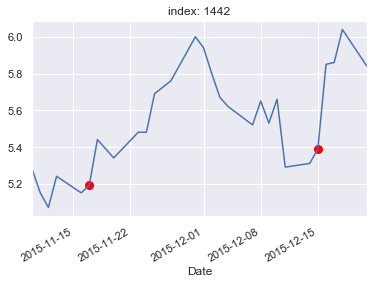

    buy_close= 4.42 buy_date= 2016-02-10 00:00:00 buy_id= 1504
    sell_close= 7.31 sell_date= 2016-05-11 00:00:00 sell_id= 1567
    gain= 2.8899999999999997 gain_pct=65.4%
    subset_slopes:
    min= -0.002462262306070606 max= 0.07158972338000869 mean= 0.03955505904442685 std= 0.022831395094989906
    days in trade= 63
    daily compounded return=0.8%
    buy_id= 1499 sell_id= 1572


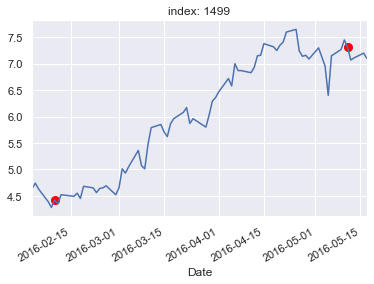

    buy_close= 3.22 buy_date= 2016-11-03 00:00:00 buy_id= 1690
    sell_close= 6.39 sell_date= 2017-04-18 00:00:00 sell_id= 1802
    gain= 3.1699999999999995 gain_pct=98.4%
    subset_slopes:
    min= -0.0010998470115053394 max= 0.056018868448190595 mean= 0.02380515502745025 std= 0.015525640069940899
    days in trade= 112
    daily compounded return=0.61%
    buy_id= 1685 sell_id= 1807


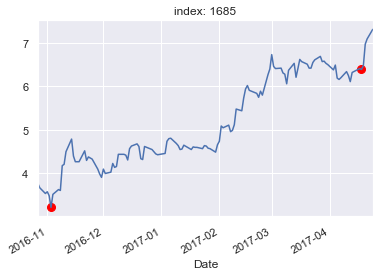

    buy_close= 5.92 buy_date= 2017-05-25 00:00:00 buy_id= 1829
    sell_close= 19.5 sell_date= 2017-11-17 00:00:00 sell_id= 1952
    gain= 13.58 gain_pct=229.4%
    subset_slopes:
    min= -0.0013578182054736487 max= 0.27507265128007496 mean= 0.10536152575962994 std= 0.0798582268148453
    days in trade= 123
    daily compounded return=0.97%
    buy_id= 1824 sell_id= 1957


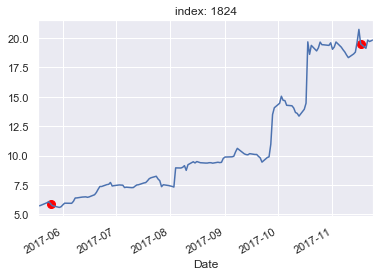

    buy_close= 19.95 buy_date= 2017-12-18 00:00:00 buy_id= 1972
    sell_close= 20.17 sell_date= 2018-02-09 00:00:00 sell_id= 2008
    gain= 0.22000000000000242 gain_pct=1.1%
    subset_slopes:
    min= -0.0022914364962254297 max= 0.08791936411748935 mean= 0.05843137522854944 std= 0.02756972748322801
    days in trade= 36
    daily compounded return=0.03%
    buy_id= 1967 sell_id= 2013


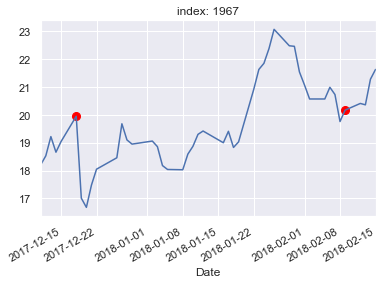

    buy_close= 19.89 buy_date= 2018-04-17 00:00:00 buy_id= 2053
    sell_close= 21.0 sell_date= 2018-08-08 00:00:00 sell_id= 2132
    gain= 1.1099999999999994 gain_pct=5.6%
    subset_slopes:
    min= -0.0005720510619759978 max= 0.10503512416224581 mean= 0.06228714852951927 std= 0.03217371225893372
    days in trade= 79
    daily compounded return=0.07%
    buy_id= 2048 sell_id= 2137


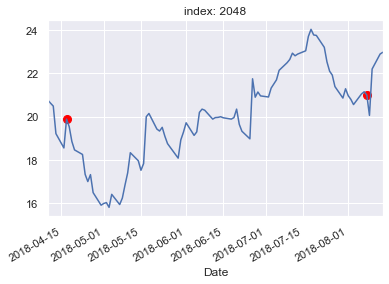

    buy_close= 10.24 buy_date= 2019-01-08 00:00:00 buy_id= 2236
    sell_close= 11.05 sell_date= 2019-02-11 00:00:00 sell_id= 2259
    gain= 0.8100000000000005 gain_pct=7.9%
    subset_slopes:
    min= -0.006529540309736959 max= 0.06284709757606599 mean= 0.03824474886896876 std= 0.02055856150987473
    days in trade= 23
    daily compounded return=0.33%
    buy_id= 2231 sell_id= 2264


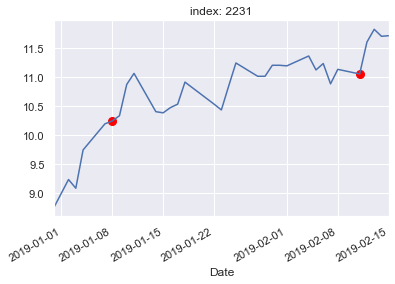

    buy_close= 7.7 buy_date= 2019-06-11 00:00:00 buy_id= 2342
    sell_close= 8.34 sell_date= 2019-06-26 00:00:00 sell_id= 2353
    gain= 0.6399999999999997 gain_pct=8.3%
    subset_slopes:
    min= -0.0010334142800090262 max= 0.007523685056119334 mean= 0.0048957991790640094 std= 0.0025779657940523787
    days in trade= 11
    daily compounded return=0.73%
    buy_id= 2337 sell_id= 2358


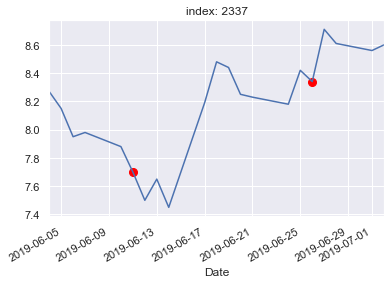

    buy_close= 7.6 buy_date= 2019-08-08 00:00:00 buy_id= 2383
    sell_close= 9.45 sell_date= 2019-09-19 00:00:00 sell_id= 2412
    gain= 1.8499999999999996 gain_pct=24.3%
    subset_slopes:
    min= -0.002210882389423574 max= 0.03782342259578453 mean= 0.021742321107056664 std= 0.012485563028674483
    days in trade= 29
    daily compounded return=0.75%
    buy_id= 2378 sell_id= 2417


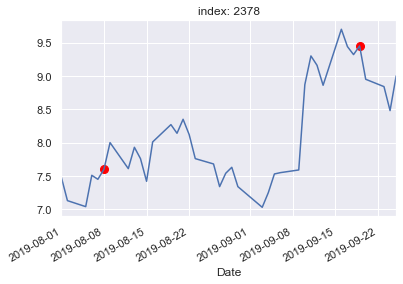

    buy_close= 7.91 buy_date= 2019-10-22 00:00:00 buy_id= 2435
    sell_close= 8.78 sell_date= 2019-11-25 00:00:00 sell_id= 2459
    gain= 0.8699999999999992 gain_pct=11.0%
    subset_slopes:
    min= -0.0035014573978617847 max= 0.04752714022353999 mean= 0.028763685409643653 std= 0.015791401827760652
    days in trade= 24
    daily compounded return=0.44%
    buy_id= 2430 sell_id= 2464


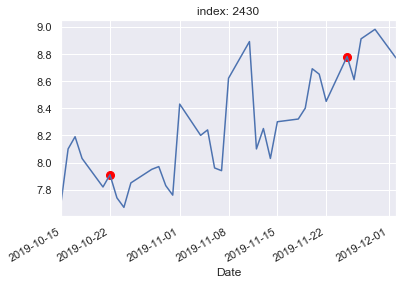

# Sell Signal Models

The code below is mostly a mirror copy of the buy signal model code above. No special tweaks have been made at this point. The performance of the sell signal models is on par with the buy signal models.

*******************
*** ADRO        ***
*******************

min_ids= [23, 104, 286, 385, 433, 511, 711, 767, 838, 929, 1137]
max_ids= [42, 162, 339, 401, 449, 573, 743, 785, 863, 984]


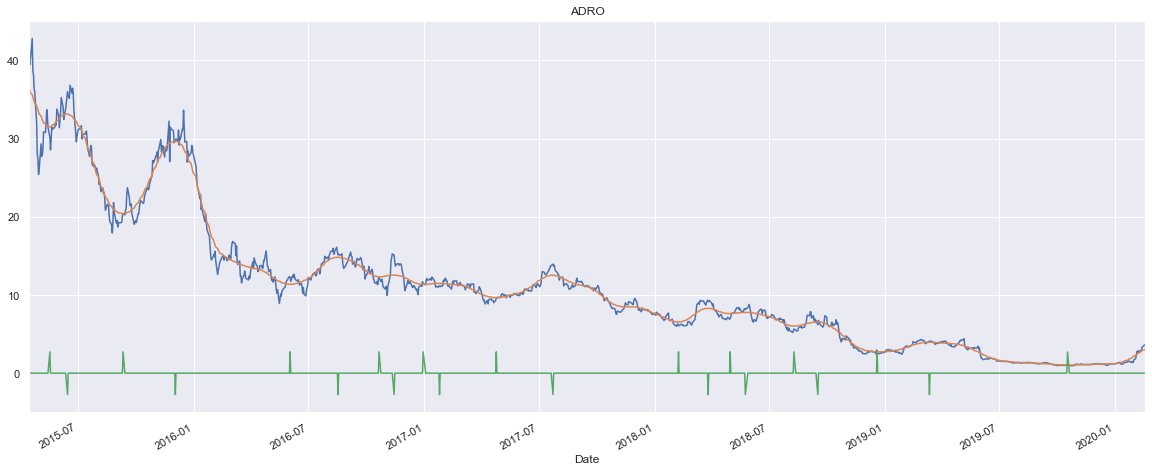

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2015-07-10  0.995749  0.981360  1.001635 -0.010028  -0.034663  0.010492   
2015-07-13  1.004254  0.994437  1.025851 -0.002618   0.020288  0.005111   
2015-07-14  0.995136  0.983463  1.003891 -0.005837   0.017510  0.005065   
2015-07-15  0.991599  0.980937  1.001939 -0.005385   0.011955  0.006497   
2015-07-16  1.040844  0.995648  1.043857  0.022877  -0.023100  0.019897   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2015-07-10  0.005494  -0.019948  0.022894  0.008306  ...  0.084369   
2015-07-13  0.001440  -0.023560  0.020754  0.001931  ...  0.081566   
2015-07-14 -0.012840  -0.025940  0.011038 -0.003080  ...  0.069520   
2015-07-15 -0.009822   0.032633  0.008262 -0.004620  ...  0.065245   
2015-07-16  0.023100  -0.014396  0.014075  0.028289  ...  0.100937   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2015-07-10   -0.037606   0.069978  0.062176    0.084696   0.070091  0.066656   
2015-07-13   -0.105366   0.071596  0.064282    0.063482   0.068148  0.062533   
2015-07-14   -0.066796   0.072145  0.054612   -0.000324   0.067535  0.047936   
2015-07-15   -0.014216   0.072285  0.050985    0.005493   0.067195  0.037830   
2015-07-16   -0.084700   0.077203  0.087334   -0.074322   0.070851  0.070444   

            PctDiff_60  StdDev_60  target  
Date                                       
2015-07-10   -0.373447   0.112623       0  
2015-07-13   -0.289267   0.109175       0  
2015-07-14   -0.297017   0.103518       0  
2015-07-15   -0.382876   0.093208       0  
2015-07-16   -0.294610   0.092651       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9655172413793103 std cross_val_score= 0.01927644808189474




*******************
*** BMCH        ***
*******************

min_ids= [26, 110, 184, 251, 304, 381, 443, 622, 723, 807, 867, 959, 1020, 1184, 1351, 1472]
max_ids= [105, 149, 212, 272, 368, 429, 474, 708, 759, 846, 925, 985, 1106, 1267, 1449]


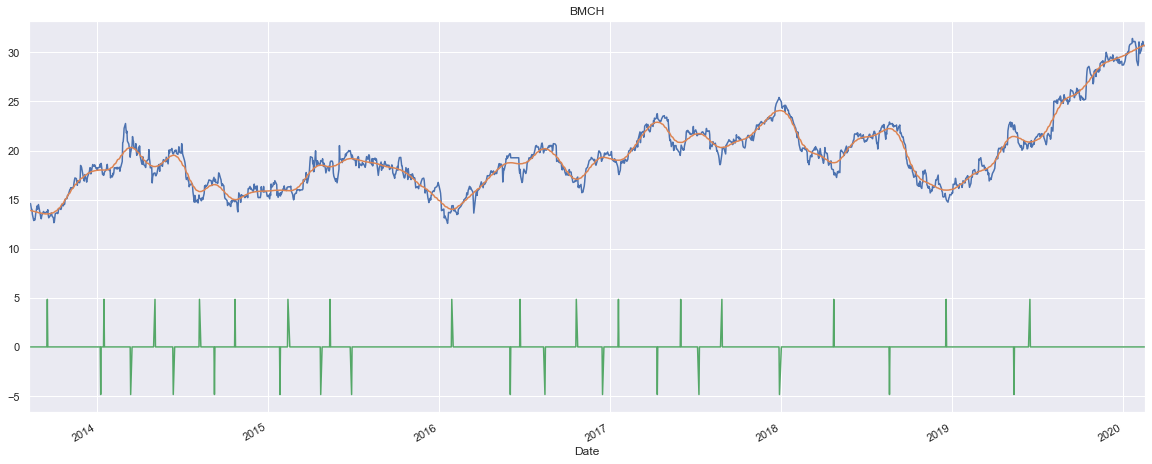

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2013-11-04  0.978763  0.975016  1.011868 -0.023111   0.036852  0.020307   
2013-11-05  0.996259  0.988155  1.003741 -0.011638   0.039900  0.018561   
2013-11-06  0.992597  0.988279  1.011104 -0.007608   0.043183  0.006654   
2013-11-07  1.008723  0.991900  1.008723  0.003115   0.002492  0.005944   
2013-11-08  0.991353  0.989500  1.009883 -0.002471   0.009265  0.005385   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2013-11-04 -0.032605   0.054966  0.020619 -0.055590  ... -0.116531   
2013-11-05 -0.022693   0.058603  0.020041 -0.047631  ... -0.112843   
2013-11-06 -0.023196   0.048735  0.021987 -0.047625  ... -0.116821   
2013-11-07 -0.005358   0.040498  0.016541 -0.028723  ... -0.103011   
2013-11-08 -0.005559   0.042001  0.005728 -0.029895  ... -0.104900   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2013-11-04    0.166771   0.053167 -0.129377    0.110556   0.047841 -0.131376   
2013-11-05    0.160224   0.056634 -0.127071    0.177057   0.051051 -0.131505   
2013-11-06    0.159778   0.059806 -0.131894    0.194941   0.053629 -0.138649   
2013-11-07    0.150156   0.062957 -0.119488    0.168847   0.056720 -0.127954   
2013-11-08    0.176035   0.064311 -0.123423    0.165534   0.059005 -0.133251   

            PctDiff_60  StdDev_60  target  
Date                                       
2013-11-04    0.098688   0.045454       0  
2013-11-05    0.089776   0.048210       0  
2013-11-06    0.117829   0.050972       0  
2013-11-07    0.126480   0.054149       0  
2013-11-08    0.134651   0.056460       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9260232400271532 std cross_val_score= 0.027525068166498832




*******************
*** CVI        ***
*******************

min_ids= [92, 132, 314, 367, 414, 457, 523, 587, 790, 941, 1000, 1169, 1234, 1340, 1524, 1625, 1675, 1794, 1838, 1881, 2029, 2120, 2227, 2404]
max_ids= [21, 115, 288, 360, 384, 418, 510, 554, 761, 824, 973, 1139, 1192, 1292, 1448, 1537, 1660, 1736, 1825, 1857, 1986, 2081, 2187, 2367, 2447]


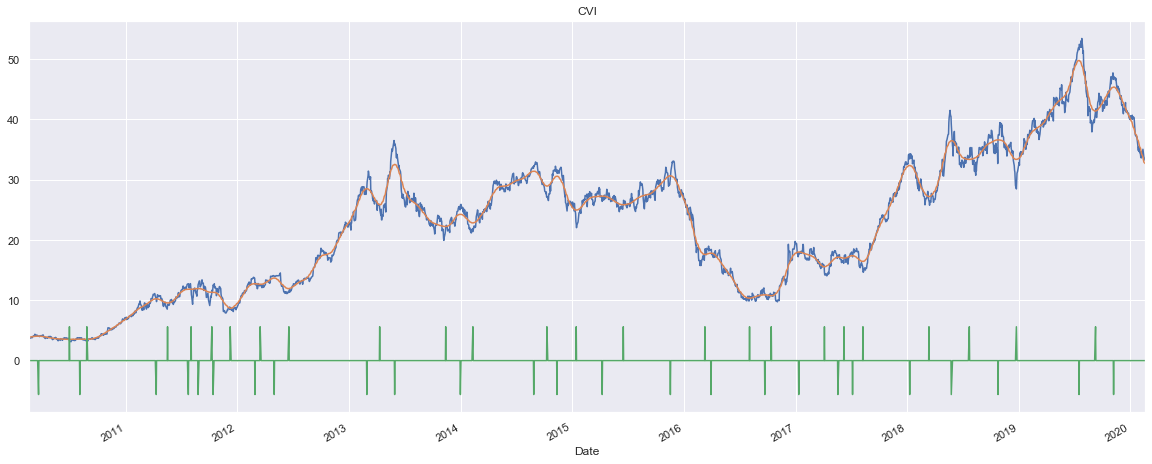

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  0.976684  0.968912  1.005181 -0.018135   0.025907  0.016179   
2010-05-18  1.048649  0.994595  1.054054  0.018018  -0.018919  0.022504   
2010-05-19  1.000000  0.970350  1.035040  0.012579  -0.008086  0.024159   
2010-05-20  1.022663  0.971671  1.022663  0.033050  -0.093484  0.028657   
2010-05-21  0.974648  0.971831  1.036620  0.013146  -0.042254  0.027791   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17 -0.027979   0.056995  0.021316 -0.046373  ... -0.009413   
2010-05-18  0.017838   0.018919  0.015944 -0.007027  ...  0.028288   
2010-05-19  0.012399  -0.013477  0.017322 -0.006739  ...  0.022192   
2010-05-20  0.050425  -0.067989  0.033483  0.043059  ...  0.069594   
2010-05-21  0.033803  -0.053521  0.037950  0.039155  ...  0.060563   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.098446   0.043358  0.015889   -0.113990   0.051653  0.020941   
2010-05-18   -0.154054   0.039440  0.056997   -0.127027   0.053613  0.064459   
2010-05-19   -0.099730   0.036989  0.051453   -0.121294   0.053062  0.061545   
2010-05-20   -0.141643   0.039018  0.100724   -0.195467   0.056177  0.114636   
2010-05-21   -0.090141   0.040136  0.090454   -0.183099   0.055931  0.107277   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.002591   0.053014       0  
2010-05-18   -0.037838   0.055836       0  
2010-05-19   -0.002695   0.055735       0  
2010-05-20   -0.062323   0.060072       0  
2010-05-21   -0.064789   0.061105       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8680757703707384 std cross_val_score= 0.038292654816432035




*******************
*** GGG        ***
*******************

min_ids= [88, 135, 399, 461, 602, 679, 784, 960, 994, 1058, 1118, 1164, 1292, 1358, 1401, 1483, 1573, 1663, 1855, 2017, 2056, 2104, 2189, 2229, 2335, 2415]
max_ids= [50, 111, 343, 440, 546, 646, 763, 940, 969, 1021, 1103, 1137, 1211, 1323, 1374, 1446, 1541, 1580, 1837, 1990, 2042, 2087, 2149, 2208, 2307, 2357]


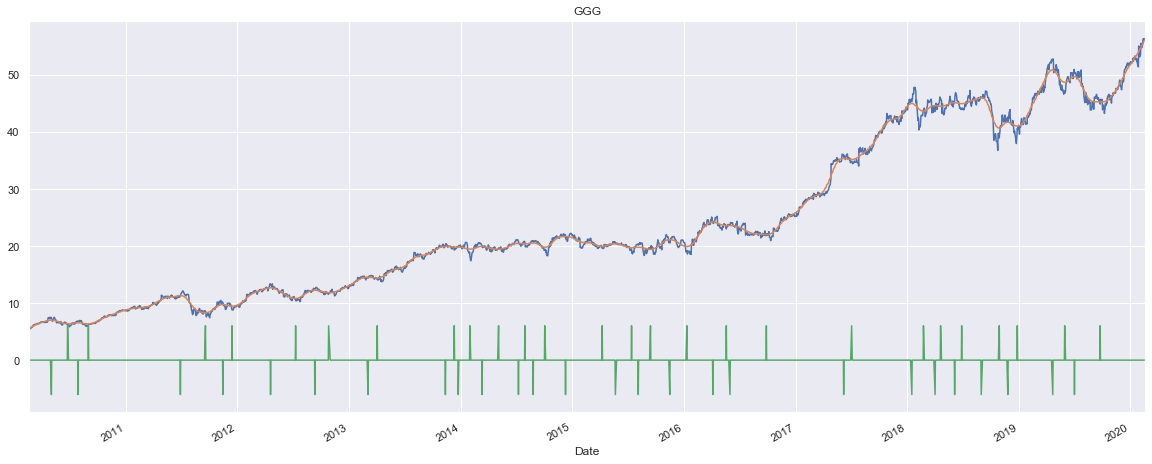

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.028129  0.976090  1.030942  0.025785  -0.056259  0.028421   
2010-05-18  1.030129  0.997131  1.041607  0.020564  -0.077475  0.020808   
2010-05-19  1.017647  0.985294  1.027941  0.023529  -0.067647  0.022830   
2010-05-20  1.018377  0.987749  1.026034  0.036243  -0.088821  0.033979   
2010-05-21  0.956652  0.952167  1.019432 -0.002491  -0.041854  0.020294   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.032349  -0.023910  0.024157  0.011252  ... -0.010361   
2010-05-18  0.043329  -0.048780  0.034469  0.028264  ...  0.010760   
2010-05-19  0.048529  -0.104412  0.040018  0.050147  ...  0.036569   
2010-05-20  0.061868  -0.150077  0.043295  0.088974  ...  0.079020   
2010-05-21  0.019432  -0.085202  0.034086  0.060837  ...  0.053612   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17    0.054852   0.049210 -0.035849    0.118143   0.055211 -0.068776   
2010-05-18    0.037303   0.049455 -0.014315    0.097561   0.054990 -0.046557   
2010-05-19    0.016176   0.050201  0.011797    0.066176   0.055174 -0.019706   
2010-05-20   -0.012251   0.052864  0.054007    0.016845   0.057039  0.023277   
2010-05-21    0.011958   0.051123  0.029663    0.038864   0.054897  0.001470   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.188467   0.077304       0  
2010-05-18    0.210904   0.076223       0  
2010-05-19    0.180882   0.075363       0  
2010-05-20    0.147014   0.075384       0  
2010-05-21    0.159940   0.070568       0  

[5 rows x 28 columns]


mean cross_val_score= 0.7886601096153528 std cross_val_score= 0.039226564699339335




*******************
*** GURE        ***
*******************

min_ids= [109, 151, 335, 391, 463, 622, 651, 798, 989, 1066, 1094, 1215, 1406, 1495, 1564, 1597, 1799, 1852, 1972, 2069, 2222, 2277, 2472]
max_ids= [24, 115, 207, 353, 411, 506, 647, 686, 954, 1023, 1086, 1102, 1315, 1442, 1524, 1596, 1703, 1815, 1913, 1995, 2084, 2261, 2310]


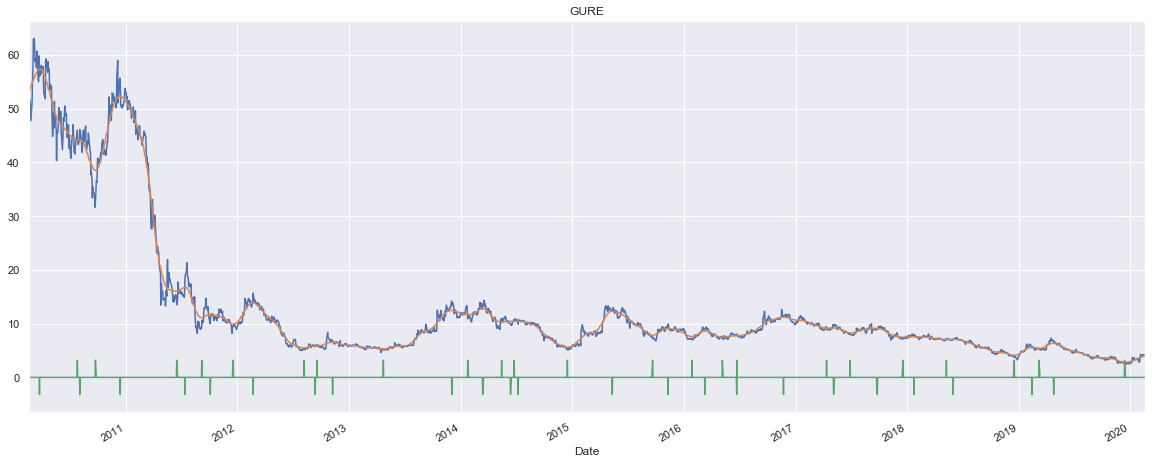

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.030271  0.939457  1.034447  0.032011  -0.063674  0.036673   
2010-05-18  1.053763  0.995699  1.059140  0.028315  -0.104301  0.027463   
2010-05-19  0.987013  0.952381  1.008658  0.014430  -0.061688  0.019640   
2010-05-20  1.070720  0.973945  1.115385  0.100083  -0.188586  0.086754   
2010-05-21  0.870718  0.851934  1.004420 -0.029466  -0.027624  0.070010   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.025470  -0.027140  0.043652  0.013883  ...  0.113187   
2010-05-18  0.056989   0.003226  0.043909  0.034624  ...  0.138566   
2010-05-19  0.043290  -0.102814  0.045435  0.036255  ...  0.139322   
2010-05-20  0.141191  -0.274194  0.083866  0.172829  ...  0.295575   
2010-05-21 -0.000442  -0.083978  0.064419  0.045414  ...  0.148361   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.204593   0.086592  0.144166   -0.240084   0.085076  0.148365   
2010-05-18   -0.244086   0.091122  0.173286   -0.239785   0.091057  0.181183   
2010-05-19   -0.199134   0.094884  0.174868   -0.271645   0.094439  0.187193   
2010-05-20   -0.316377   0.122248  0.335622   -0.506203   0.117259  0.357920   
2010-05-21   -0.164641   0.112405  0.182222   -0.328177   0.105975  0.208195   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.092902   0.092574       0  
2010-05-18   -0.105376   0.097754       0  
2010-05-19   -0.099567   0.100732       0  
2010-05-20   -0.184864   0.122510       0  
2010-05-21   -0.070718   0.110998       0  

[5 rows x 28 columns]


mean cross_val_score= 0.840782872187174 std cross_val_score= 0.0474436928194289




*******************
*** HWC        ***
*******************

min_ids= [133, 340, 397, 443, 581, 621, 680, 812, 906, 1003, 1066, 1130, 1163, 1240, 1310, 1404, 1496, 1529, 1791, 1893, 2014, 2061, 2108, 2226, 2287, 2347, 2396]
max_ids= [29, 216, 349, 433, 532, 612, 658, 723, 874, 976, 1031, 1094, 1144, 1190, 1285, 1343, 1443, 1524, 1766, 1852, 2008, 2021, 2081, 2139, 2268, 2308, 2361, 2484]


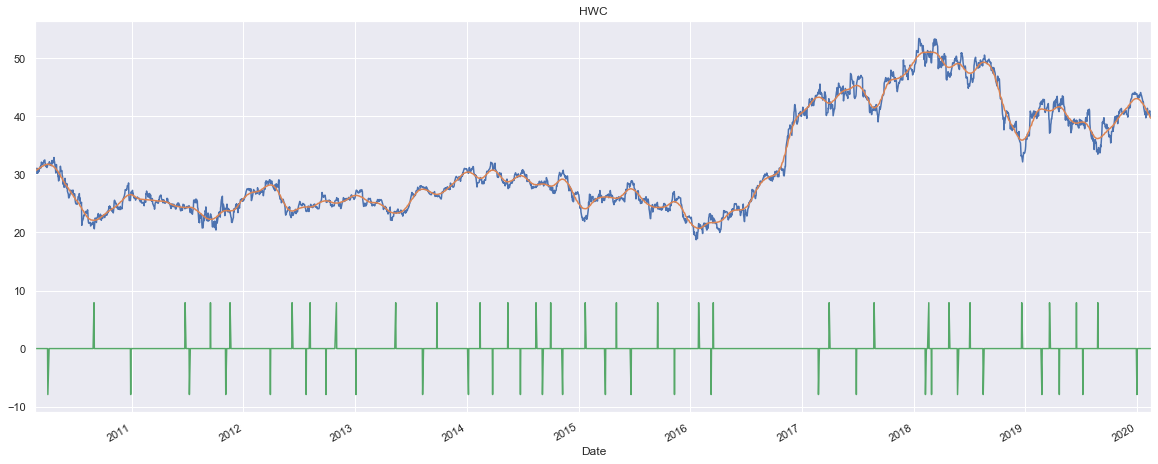

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  0.999348  0.963796  1.012068  0.002718  -0.024462  0.008644   
2010-05-18  1.039597  0.991611  1.040268  0.017785  -0.041611  0.015556   
2010-05-19  1.001346  0.988896  1.025908  0.011440  -0.027254  0.017535   
2010-05-20  1.034556  0.998942  1.042666  0.032910  -0.081100  0.028536   
2010-05-21  0.983287  0.971448  1.022284  0.007428  -0.037604  0.024535   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.005806   0.015003  0.012393 -0.016667  ...  0.016732   
2010-05-18  0.029799  -0.025168  0.020270  0.012248  ...  0.043412   
2010-05-19  0.021198  -0.056864  0.019211  0.015242  ...  0.043854   
2010-05-20  0.051269  -0.094499  0.032276  0.062094  ...  0.090009   
2010-05-21  0.025487  -0.063022  0.032009  0.048015  ...  0.073062   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.034573   0.035064  0.023106   -0.042401   0.030690  0.020238   
2010-05-18   -0.079866   0.036441  0.051245   -0.062416   0.032494  0.049055   
2010-05-19   -0.070996   0.037173  0.052550   -0.068641   0.033479  0.051609   
2010-05-20   -0.117066   0.042278  0.100141   -0.129760   0.038044  0.100447   
2010-05-21   -0.098538   0.043769  0.083759   -0.116643   0.039409  0.085370   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.000326   0.028475       0  
2010-05-18   -0.037584   0.029954       0  
2010-05-19   -0.016151   0.030430       0  
2010-05-20   -0.095557   0.034498       0  
2010-05-21   -0.076950   0.035840       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8334533803586508 std cross_val_score= 0.044018508098818375




*******************
*** MBI        ***
*******************

min_ids= [84, 200, 332, 384, 535, 571, 616, 707, 719, 788, 848, 917, 981, 1064, 1119, 1167, 1249, 1368, 1472, 1591, 1668, 1823, 1934, 1991, 2071, 2224, 2340, 2388, 2492]
max_ids= [48, 172, 232, 351, 483, 541, 601, 648, 714, 769, 824, 853, 949, 1024, 1077, 1137, 1196, 1287, 1435, 1535, 1632, 1730, 1880, 1958, 2047, 2158, 2276, 2365, 2443]


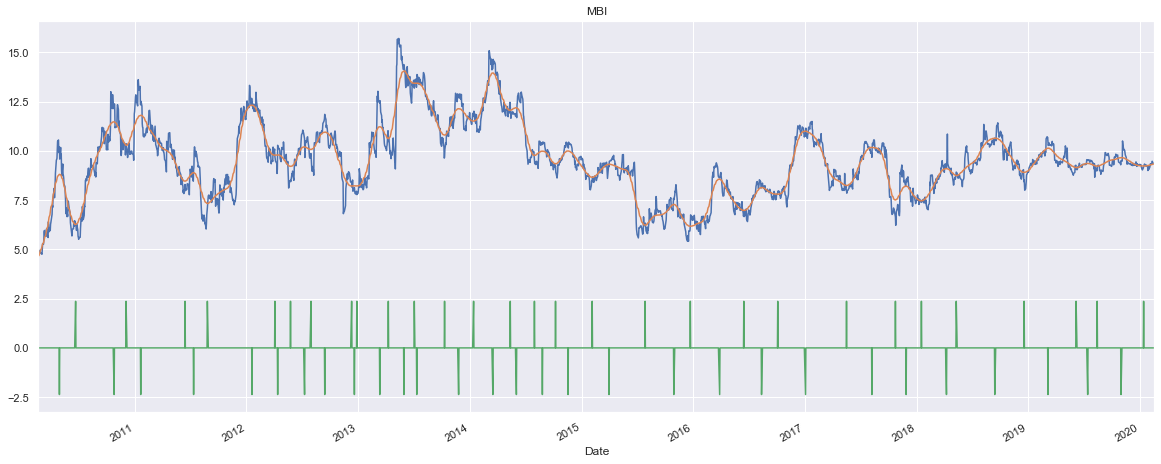

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.012210  0.971917  1.021978  0.022385  -0.068376  0.027092   
2010-05-18  1.068615  0.991105  1.073698  0.032190  -0.095299  0.028901   
2010-05-19  1.029216  0.981408  1.057105  0.044267  -0.103586  0.043831   
2010-05-20  1.066079  0.982379  1.083700  0.087127  -0.202643  0.079476   
2010-05-21  0.922535  0.919718  1.016901  0.006573  -0.108451  0.051023   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.040781  -0.139194  0.031647  0.088767  ...  0.095686   
2010-05-18  0.060737  -0.111817  0.044494  0.110419  ...  0.142906   
2010-05-19  0.076228  -0.162019  0.055568  0.130013  ...  0.196282   
2010-05-20  0.136858  -0.265786  0.088511  0.217181  ...  0.319139   
2010-05-21  0.056338  -0.170423  0.078735  0.144507  ...  0.262488   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17    0.172161   0.121694 -0.024854    0.305250   0.200021 -0.111477   
2010-05-18    0.080051   0.122620  0.021036    0.280813   0.203242 -0.069102   
2010-05-19    0.053121   0.124944  0.072392    0.236388   0.207610 -0.021049   
2010-05-20   -0.108664   0.145205  0.188612    0.127753   0.226363  0.087176   
2010-05-21   -0.083099   0.143776  0.143380    0.149296   0.213709  0.048005   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17    0.389499   0.231002       0  
2010-05-18    0.374841   0.237331       0  
2010-05-19    0.361222   0.244153       0  
2010-05-20    0.283407   0.265905       0  
2010-05-21    0.314085   0.250784       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8407911512923683 std cross_val_score= 0.009942135270206308




*******************
*** PANW        ***
*******************

min_ids= [106, 233, 321, 446, 782, 824, 896, 997, 1113, 1189, 1272, 1346, 1600, 1737, 1795, 1863]
max_ids= [36, 152, 263, 409, 751, 799, 853, 925, 1067, 1143, 1248, 1323, 1547, 1689, 1763, 1847]


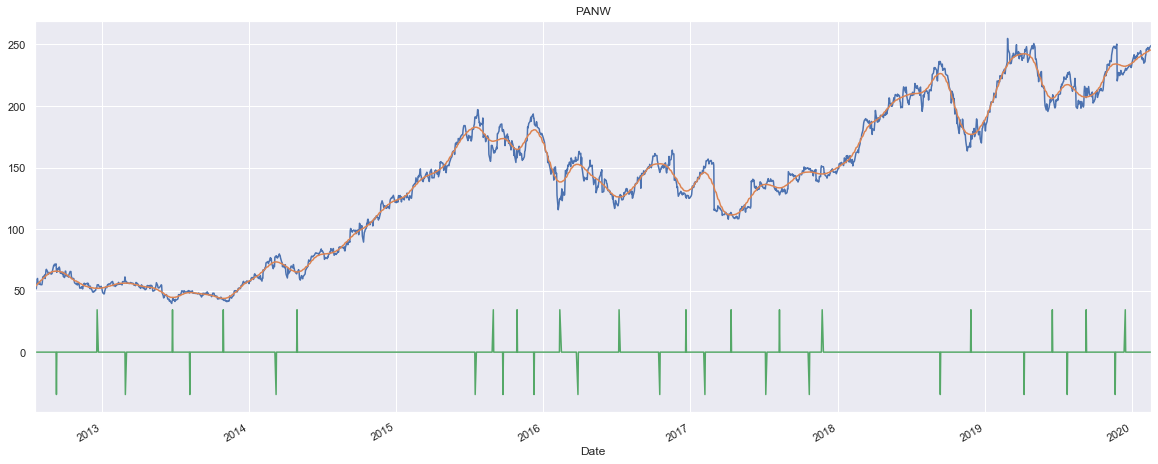

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2012-10-15  0.962777  0.959878  1.003814 -0.036512   0.062700  0.035108   
2012-10-16  1.004880  0.980631  1.005948 -0.013370   0.070307  0.022894   
2012-10-17  0.995878  0.984885  1.022901  0.000611   0.038779  0.000550   
2012-10-18  1.035218  0.996607  1.035218  0.039149  -0.058966  0.033909   
2012-10-19  1.030323  0.983006  1.046151  0.040875  -0.092469  0.046395   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2012-10-15 -0.045400   0.053089  0.027790 -0.038047  ... -0.000976   
2012-10-16 -0.034680   0.055056  0.033470 -0.032896  ... -0.003640   
2012-10-17 -0.021252   0.061985  0.031826 -0.032412  ... -0.004865   
2012-10-18  0.038708   0.015186  0.028180  0.017625  ...  0.047889   
2012-10-19  0.061446  -0.048984  0.043240  0.046201  ...  0.074758   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2012-10-15    0.017849   0.050801 -0.008153    0.064531   0.045064 -0.038416   
2012-10-16   -0.070764   0.048934 -0.007490    0.043465   0.044747 -0.035135   
2012-10-17   -0.068702   0.047109 -0.004495    0.087023   0.043082 -0.031560   
2012-10-18   -0.153635   0.046963  0.053104   -0.013409   0.045898  0.025557   
2012-10-19   -0.178607   0.046939  0.083691   -0.107964   0.048911  0.057720   

            PctDiff_60  StdDev_60  target  
Date                                       
2012-10-15    0.189474   0.069020       0  
2012-10-16    0.214427   0.065191       0  
2012-10-17    0.152672   0.063512       0  
2012-10-18    0.047658   0.066615       0  
2012-10-19    0.002333   0.068667       0  

[5 rows x 28 columns]


mean cross_val_score= 0.887841500036622 std cross_val_score= 0.03552968249669444




*******************
*** SIBN        ***
*******************

min_ids= [22, 85, 140, 203, 255]
max_ids= [53, 93, 187, 219, 316]


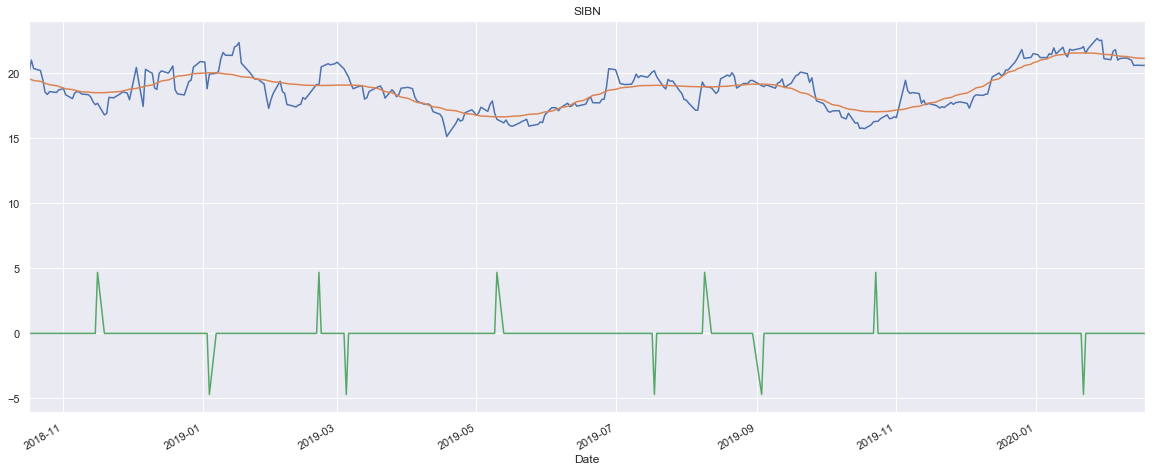

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2019-01-15  0.972727  0.970909  1.024091 -0.019091   0.018636  0.016539   
2019-01-16  1.000000  0.975577  1.041610 -0.012965   0.033017  0.018318   
2019-01-17  0.984340  0.976286  1.027740 -0.008799   0.044295  0.008008   
2019-01-18  1.088108  0.989889  1.088108  0.046862  -0.059220  0.040993   
2019-01-22  1.025513  0.947974  1.046023  0.052360  -0.106053  0.060149   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2019-01-15 -0.023545   0.085000  0.015529 -0.058636  ... -0.095803   
2019-01-16 -0.019086   0.046585  0.015789 -0.057621  ... -0.094045   
2019-01-17 -0.022819   0.034004  0.020017 -0.051857  ... -0.100925   
2019-01-18  0.045643  -0.029369  0.031011  0.024362  ... -0.030332   
2019-01-22  0.072736  -0.068534  0.050905  0.064332  ...  0.011756   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2019-01-15    0.160455   0.051085 -0.124071    0.155000   0.059747 -0.127288   
2019-01-16    0.187698   0.051252 -0.124840    0.161465   0.062219 -0.130793   
2019-01-17    0.085459   0.054056 -0.130311    0.176734   0.064352 -0.138635   
2019-01-18    0.065961   0.058107 -0.061552    0.116996   0.069415 -0.072653   
2019-01-22    0.127564   0.054765 -0.022911    0.091046   0.071501 -0.036060   

            PctDiff_60  StdDev_60  target  
Date                                       
2019-01-15    0.088182   0.055333       0  
2019-01-16    0.050204   0.056674       0  
2019-01-17    0.089485   0.058569       0  
2019-01-18    0.027443   0.063460       0  
2019-01-22    0.024512   0.066087       0  

[5 rows x 28 columns]


mean cross_val_score= 0.9781818181818182 std cross_val_score= 0.01781447085660494




*******************
*** SPPI        ***
*******************

min_ids= [87, 136, 238, 318, 401, 552, 694, 794, 837, 885, 1052, 1118, 1296, 1447, 1504, 1690, 1829, 1972, 2053, 2236, 2342, 2383, 2435]
max_ids= [7, 113, 229, 292, 357, 476, 605, 739, 829, 860, 947, 1089, 1148, 1369, 1466, 1567, 1802, 1952, 2008, 2132, 2259, 2353, 2412, 2459]


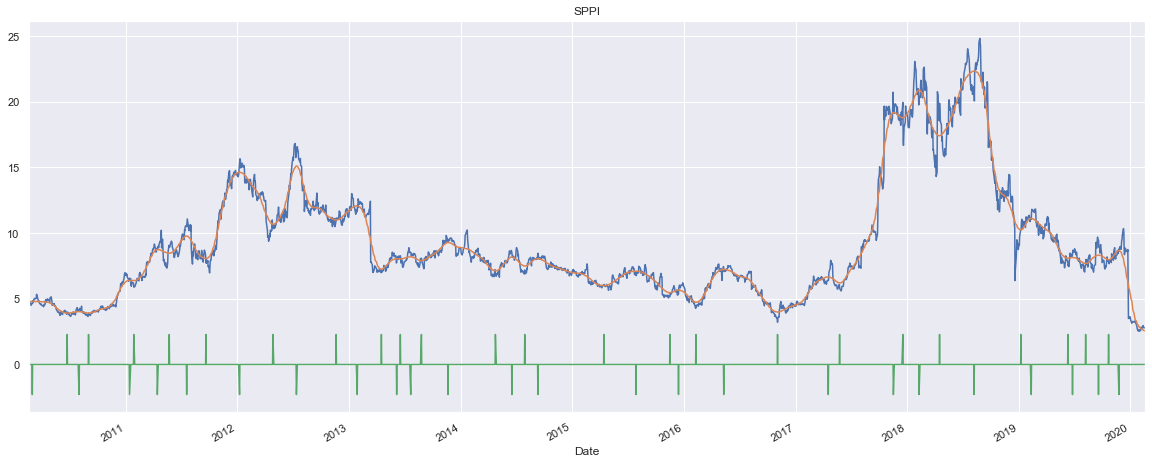

Open       Low      High    MACD_3  PctDiff_3  StdDev_3  \
Date                                                                      
2010-05-17  1.008897  0.984459  1.028897  0.014077  -0.044460  0.017260   
2010-05-18  1.017970  0.979775  1.026967  0.010485  -0.044937  0.010133   
2010-05-19  1.030358  0.985981  1.035047  0.030366  -0.060740  0.026938   
2010-05-20  1.004731  0.973941  1.011840  0.022904  -0.066335  0.028267   
2010-05-21  0.990515  0.981005  1.018995  0.006340  -0.057008  0.008996   

              MACD_5  PctDiff_5  StdDev_5   MACD_10  ...   MACD_30  \
Date                                                 ...             
2010-05-17  0.021338  -0.031127  0.017961  0.040008  ...  0.067860   
2010-05-18  0.026516  -0.031454  0.023432  0.038651  ...  0.079401   
2010-05-19  0.047654  -0.098132  0.031714  0.064711  ...  0.120476   
2010-05-20  0.042174  -0.101881  0.033271  0.071557  ...  0.134511   
2010-05-21  0.028981  -0.078386  0.031925  0.063660  ...  0.133889   

            PctDiff_30  StdDev_30   MACD_45  PctDiff_45  StdDev_45   MACD_60  \
Date                                                                           
2010-05-17   -0.011126   0.050822  0.074380   -0.124462   0.054922  0.075714   
2010-05-18   -0.013483   0.052048  0.083098   -0.150572   0.056120  0.086482   
2010-05-19   -0.053731   0.057259  0.120191   -0.266357   0.057299  0.127525   
2010-05-20   -0.056872   0.061581  0.131010   -0.229844   0.059765  0.141898   
2010-05-21   -0.099764   0.066331  0.128058   -0.254153   0.060274  0.142917   

            PctDiff_60  StdDev_60  target  
Date                                       
2010-05-17   -0.068898   0.051549       0  
2010-05-18   -0.078645   0.053337       0  
2010-05-19   -0.126169   0.057925       0  
2010-05-20   -0.099527   0.061360       0  
2010-05-21   -0.102147   0.064063       0  

[5 rows x 28 columns]


mean cross_val_score= 0.8762298610766148 std cross_val_score= 0.03908978825741701






In [30]:
for ticker in tickers:
    
    gc.collect()
    
    print("*******************")
    print("***", ticker, " "*6, "***" )
    print("*******************")
    print('')
    
    hist = ticker_stats(ticker, 3, False)
    hist = smooth(hist)
    
    target = 'target'
    hist[target] = 0
    mean_close = hist.Close.mean()

    min_ids = argrelmin(hist.smooth.values)[0].tolist()
    print("min_ids=", min_ids)
    
    max_ids = argrelmax(hist.smooth.values)[0].tolist()
    print("max_ids=", max_ids)

    hist[target].iloc[min_ids] = 1
    hist[target].iloc[max_ids] = -1

    plt.figure(figsize=(20,8))
    hist.Close.plot()
    hist.smooth.plot()
    (hist[target]*(mean_close/4)).plot()
    plt.title(ticker)
    plt.show()
    
    # NB: we do not include smooth in data!
    data = hist[['Close', 'Open', 'Low', 'High']]
    data = features(data, target)
    
    encoder = WOEEncoder()
    binner = KBinsDiscretizer(n_bins=5, encode='ordinal')
    objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
    imputer = SimpleImputer(strategy='constant', fill_value=0.0)
    clf = LogisticRegression(class_weight='balanced', random_state=42)

    pipe = make_pipeline(binner, objectify, encoder, imputer, clf)

    used_cols = [c for c in data.columns.tolist() if c not in [target]]
    data[target] = data[target].apply(lambda x: 1 if x == -1 else 0)
    X, y = data[used_cols].values, data[target].values
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print('')
    print("mean cross_val_score=", scores.mean(), "std cross_val_score=", scores.std())
    print('\n\n\n')